# Intraprediction Project



## ENCODER DECODER



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import tensorflow as tf
import random
import sys
import os
from optparse import OptionParser
import numpy as np
from torch import optim
from PIL import Image
from torch.autograd import Function, Variable
import matplotlib.pyplot as plt
import matplotlib 
from torchvision import transforms
from torch.utils.data import Dataset
import cv2
import glob
import pickle
from tqdm import tqdm
%matplotlib inline

### [ TODO 1 ] First define following layers to be used later
- **Conv2d + BatchNorm2d + ReLu ** as **single conv2d layer** ,
- **Maxpool2d + single conv2d layer ** as **down layer**,
- **Upsample + single conv2d layer ** as **up layer** ,
-  **Conv2d ** as **outconv layer** 

You can check out the documentation in this link to understand how to use the methods called in the provided template:

 https://pytorch.org/docs/stable/nn.html
 
  ![single_conv](single_conv_layer.png)
  ![down_layer](down_layer.png)
  ![up_layer](Up_layer.png)
  ![outconv_layer](outconv_layer.png)
  

In [3]:
################################################ [TODO] ###################################################
# DEFINE SINGLE_CONV CLASS
class single_conv(nn.Module):
    '''(conv => BN => ReLU) '''
    def __init__(self, in_ch, out_ch):
        super(single_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.Conv2d(in_ch,out_ch,3,padding = (1,1)), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )

    def forward(self, x):
        #paddings = tf.constant([[0, 0,],[0, 0,],[1, 1,], [1, 1]])
        #x = tf.pad(x, paddings, "SYMMETRIC")
        x = self.conv(x)
        return x



################################################ [TODO] ###################################################
# DEFINE DOWN CLASS
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.down = nn.Conv2d(in_ch,in_ch,kernel_size=3,stride =2) #(channel in, channel out, filter)
        self.conv = single_conv(in_ch, out_ch) # use previously defined single_cov
    def forward(self, x):
        x = self.down(x)
        x = self.conv(x)
        return x
    

################################################ [TODO] ###################################################
# DEFINE UP CLASS
# Note that this class will not only upsample x1, but also concatenate up-sampled x1 with x2 to generate the final output

class up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(up, self).__init__()       
        self.up = nn.Upsample(2,'bilinear') # use nn.Upsample( )
        self.conv = single_conv(in_ch,out_ch) # use previously defined single_cov

    def forward(self, x):
        # This part is tricky, so we provide it for you
        # First we upsample x1
        x = nn.functional.interpolate(x, size=None, scale_factor=2, mode='bilinear')
        x = self.conv(x)
        return x
    
class resize(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(resize, self).__init__()       
        self.up = nn.Upsample(2,'bilinear') # use nn.Upsample( )
        self.conv = nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.Conv2d(in_ch,out_ch,3), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x, siz):
        x = nn.functional.interpolate(x, size=(siz+2,siz+2),  mode='bilinear')
        x = self.conv(x)
        return x

################################################ [TODO] ###################################################
# DEFINE OUTCONV CLASS
class quat(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(quat, self).__init__()
        self.down = down(in_ch,out_ch)
    def forward(self, x):
        x = self.down(x)
        #Quatization
        T = 1
        x = (x > T).float() * 1
        return x

class upT(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(upT, self).__init__()
        self.up =  nn.Sequential(
            nn.BatchNorm2d(in_ch), # Channels in
            nn.ConvTranspose2d(in_ch,out_ch,kernel_size=3, stride=2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x):
        x = self.up(x)
        return x


In [4]:
################################################ [TODO] ###################################################
# Build your network with predefined classes: single_conv, up, down, outconv
# The number of input and output channels should follow the U-Net Structure shown above.
import torch.nn.functional as F
class UNet(nn.Module):
    def __init__(self, n_channels):
        super(UNet, self).__init__()
        self.inc = single_conv(n_channels, 6) # conv2d +  batchnorm + relu 
        self.down1 = resize(6, 8)              # maxpool2d + conv2d + batchnorm + relu
        self.down2 = resize(8, 8)              # maxpool2d + conv2d + batchnorm + relu
        self.down3 = resize(8,8)                # maxpool2d + conv2d + batchnorm + relu +Quatization
        self.up1 = upT(8,6)                   # upsample + pad + conv2d + batchnorm + relu
        self.up2 = upT(6,3)             # conv2d
        self.upF =  nn.Sequential(nn.Conv2d(3,3,4), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
        self.upF2 =  nn.Sequential(nn.Conv2d(8,8,2), #(channel in, channel out, filter)
            nn.Tanh(), #Channel in
        )
    def forward(self, x):
        #ENCODE
        x = self.inc(x) #16x16
        x = self.down1(x,12) #12x12
        x = self.down2(x,8) #8x8
        x = self.down3(x,4) #4x4
        #x = self.upF2(x) #3x3
        #x = self.quat(x) 
        #DECODE
        x = self.up1(x) #8x8
        x = self.up2(x) #18x18
        #x = self.up3(x)
        x = self.upF(x) #16x16
        #Differentiable traingle function
        #x = (1 - 2*torch.acos(0.99*torch.sin(2*3.14*x))/3.14)/2
        #x = x[:,:,8:24,8:24];
        return x    

### [ TODO 2 ] Define evaulation function:
Based on what we have learnt in class, Dice coefficient is defined as 
![dice.png](dice.png)
For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate intersection of A and B as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

In order to quantify the area of A union B, some researchers use the simple sum whereas other researchers prefer to use the squared sum for this calculation. You can use either way.



In [7]:
################################################ [TODO] ###################################################
# define dice coefficient 
class MseCoeff(Function):
    """Dice coeff for one pair of input image and target image"""
    def forward(self, input, target):
        self.save_for_backward(input, target)
        ################################################ [TODO] ###################################################
        # Calculate intersection and union. 
        # You can convert the input image into a vector with input.contiguous().view(-1)
        # Then use torch.dot(A, B) to calculate the intersection.
        # Use torch.sum(A) to get the sum.
        input = input.contiguous().view(-1)
        target = target.contiguous().view(-1)
        # Calculate Mean Squared Error
        diff = input - target;
        dot =  torch.dot(diff,diff)
        dot = dot/input.numel()
        return dot


################################################ [TODO] ###################################################
# Calculate dice coefficients for batches
def mse_coeff(input, target):
    """Dice coeff for batches"""
    s = torch.FloatTensor(1).zero_()    
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
    MSE = MseCoeff()
    for i, (c, b) in enumerate(zip(input, target)):
        s += MSE.forward(c,b);
    s = s / (i + 1)
    return s

def grad(input):
    #satcal = input[2,:,:]
    x_right = F.pad(input, (0, 1, 0, 0))
    x_left = F.pad(input, (1, 0, 0, 0 ))
    y_up =   F.pad(input, (0, 0, 1, 0 )) 
    y_down =   F.pad(input, (0, 0, 0,1))
    dx = x_right - x_left;
    dy = y_up - y_down;
    return dx[:,1:16, 1:16], dy[:,1:16, 1:16]

def grad2(input):
    #satcal = input[2,:,:]
    x_right = F.pad(input, (0, 2, 0, 0))
    x_left = F.pad(input, (2, 0, 0, 0 ))
    x_center = F.pad(input,(1,1,0,0))
    y_up =   F.pad(input, (0, 0, 2, 0 )) 
    y_down =   F.pad(input, (0, 0, 0,2))
    y_center = F.pad(input,(0,0,1,1))
    dx = 2*x_center - x_right - x_left;
    dy = 2*y_center - y_up - y_down;
    return dx[:,2:15, 2:15]/4, dy[:,2:15, 2:15]/4

def grad_loss(input, target, epoch):
    s = torch.FloatTensor(1).zero_()    
    # For each pair of input and target, call DiceCoeff().forward(input, target) to calculate dice coefficient
    # Then average
   # print(input.shape)
   # print(target.shape)
    MSE = MseCoeff()
    s = 0;
    for i, (c, b) in enumerate(zip(input, target)): 
        if (epoch%10)  < 5:
            p,q,r = 0.75, 0.125, 0.125
        else:
            p,q,r  = 0.4,0.3, 0.3
        #else:
        #    p,q,r  = 0.6, 0.2, 0.2
        Gx_target, Gy_target = grad2(b)
        Gx_in , Gy_in = grad2(c)
        s += p*MSE.forward(c,b);
        s += q*MSE.forward(Gx_in,Gx_target);
        s += r*MSE.forward(Gy_in, Gy_target);
    s = s / (i+1)
    return s



### Load images and masks

This part is to convert data into HSV form and normalize. Added this part down this.

In [8]:
#validation = glob.glob('./Data/Validation/*')
#train = glob.glob('./Data/Train/*')
#test = glob.glob('./Data/Test/*')
#valiDataset = []
#trainDataset = []
#testDataset = []
##Loads the following in a list of (3, 16,16) and (3, 20,20)
#for i in range(len(validation)):
#    f=open(validation[i],'rb')
#    b=pickle.load(f)
#    #flip the data dimension
#    for q in range(b.shape[3]):
#        img = b[:,:,:,q]+128/255;
#        b[:,:,:,q] = matplotlib.colors.rgb_to_hsv(img) - 0.5 
#    b = np.transpose(b, axes=[3, 2, 0, 1]) 
#    f.close()
#    valiDataset.append(b)
    
#for i in range(len(test)):
#    f=open(test[i],'rb')
#    b=pickle.load(f)
#    for q in range(b.shape[3]):
#        img = b[:,:,:,q]+128/255;
#        b[:,:,:,q] = matplotlib.colors.rgb_to_hsv(img) - 0.5
#    b = np.transpose(b, axes=[3, 2, 0, 1]) 
#    f.close()
#    testDataset.append(b)
    
#for i in range(len(train)):
#    f=open(train[i],'rb')
#    b=pickle.load(f)
#    for q in range(b.shape[3]):
#        if i ==0:
#            img = b[:,:,:,q]+128/255
#        else:
#            img = (b[:,:,:,q])/255;
#        b[:,:,:,q] = matplotlib.colors.rgb_to_hsv(img) - 0.5
#    b = np.transpose(b, axes=[3, 2, 0, 1]) 
#    f.close()
#    trainDataset.append(b)

In [9]:
## Save the HSV form 
#HSVTrain16 = trainDataset[0]
#HSVTrain20 = trainDataset[1]
#HSVvali16 = valiDataset[0]
#HSVvali20 = valiDataset[1]
#HSVtest16 = testDataset[0]
#HSVtest20 = testDataset[1]
#f1=open('trainHSV_16','wb')
#pickle.dump(HSVTrain16,f1)
#f1.close()
#f2=open('validationHSV_16','wb')
#pickle.dump(HSVvali16,f2)
#f2.close()
#f3=open('testHSV_16','wb')
#pickle.dump(HSVtest16,f3)
#f3.close()
#f4=open('trainHSV_20','wb')
#pickle.dump(HSVTrain20,f4)
#f4.close()
#f5=open('validationHSV_20','wb')
#pickle.dump(HSVvali20,f5)
#f5.close()
#f6=open('testHSV_20','wb')
#pickle.dump(HSVtest20,f6)
#f6.close()

In [10]:
validation = glob.glob('./Data/ValidationHSV/*')
train = glob.glob('./Data/TrainHSV/*')
test = glob.glob('./Data/TestHSV/*')
valiDataset = []
trainDataset = []
testDataset = []
#Loads the following in a list of (3, 16,16) and (3, 20,20)
for i in range(len(validation)):
    f=open(validation[i],'rb')
    b=pickle.load(f)
    f.close()
    valiDataset.append(b)
    
for i in range(len(test)):
    f=open(test[i],'rb')
    b=pickle.load(f)
    f.close()
    testDataset.append(b)
    
for i in range(len(train)):
    f=open(train[i],'rb')
    b=pickle.load(f)
    f.close()
    trainDataset.append(b)

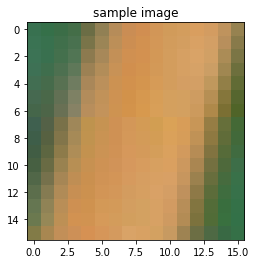

In [12]:
#### Let us display some of the images to make sure the data loading and processing is correct.
### the original size of the image is: 1280*1918, but we resize the image to 80*100 for 
### training the segmentation network
img_num = 5000
a = testDataset[0][img_num] + 0.5
a = np.transpose(a, axes = [1,2,0])
a = matplotlib.colors.hsv_to_rgb(a)
plt.imshow(a)
plt.title("sample image")
plt.show()

### Create datasets in the format that you can later use Torch  "DataLoader" during training and define  data augmentation 

In [9]:
#### define transform classes for  data augmentation
class Flip(object):
    """
    Flip the image left or right for data augmentation, but prefer original image.
    """
    def __init__(self,ori_probability=0.60):
        self.ori_probability = ori_probability
 
    def __call__(self, sample):
        if random.uniform(0,1) < self.ori_probability:
            return sample
        else:
            img, label = sample['img'], sample['label']
            img_flip = img[:,:,::-1]
            label_flip = label[:,::-1]
            
            return {'img': img_flip, 'label': label_flip}
        
class ToTensor(object):
    """
    Convert ndarrays in sample to Tensors.
    """
    def __init__(self):
        pass

    def __call__(self, sample):
        image, label = sample['img'], sample['label']

        return {'img': torch.from_numpy(image.copy()).type(torch.FloatTensor),
                'label': torch.from_numpy(label.copy()).type(torch.FloatTensor)}

In [10]:
# the dataset class
class CustomDataset(Dataset):
    def __init__(self, images, image_masks,  transforms=None):   # initial logic happens like transform
        self.image = images
        self.image_masks = image_masks
        self.transforms = transforms
    
    def __len__(self):  # return count of sample we have

        return len(self.image_masks)
    
    def __getitem__(self, index):
        orig = self.image[index];
        image = self.image_masks[index]
        sample = {'img': orig, 'label': image}
        if transforms:
            sample = self.transforms(sample)            
        return sample

#train_dataset = CustomDataset(((trainDataset[1]-128)/255), trainDataset[0], transforms=transforms.Compose([Flip(),ToTensor()]))
train_dataset = CustomDataset(trainDataset[0], trainDataset[0], transforms=transforms.Compose([Flip(),ToTensor()]))
val_dataset = CustomDataset(valiDataset[0], valiDataset[0], transforms=transforms.Compose([Flip(),ToTensor()]))

In [11]:
print(trainDataset[1][0].shape)

(3, 20, 20)


### [ TODO 3 ] Start training your network

In [336]:
################################################ [TODO] ###################################################
# Create a UNET object. Input channels = 3, output channels = 1
net = UNet(3);

In [16]:
################################################ [TODO] ###################################################
# This function is used to evaluate the network after each epoch of training
# Input: network and validation dataset
# Output: average dice_coeff
def eval_net(net, dataset):
    # set net mode to evaluation
    net.eval()
    tot = 0
    for i, b in enumerate(dataset):
        img = b['img']
        label = b['label']
        img = img.type(torch.FloatTensor);
        ################################################ [TODO] ################################################### 
        # Feed in the image to get predicted mask
        pred_img = net.forward(img)
        tot += mse_coeff(pred_img,label);
    return tot / (i + 1)

In [32]:
################################################ [TODO] ###################################################
# Specify number of epochs, image scale factor, batch size and learning rate
epochs = 100
# i.e, 4
batch_size = 50 # i.e, 16
lr = 0.01        # i.e, 0.01
lr_lambda = lambda epoch: 0.95 ** epoch
N_train = len(train_dataset)
model_save_path = './model/'  # directory to same the model after each epoch. 


################################################ [TODO] ###################################################
# Define an optimizer for your model.
# Pytorch has built-in package called optim. Most commonly used methods are already supported.
# Here we use stochastic gradient descent to optimize
# For usage of SGD, you can read https://pytorch.org/docs/stable/_modules/torch/optim/sgd.html
# Also you can use ADAM as the optimizer
# For usage of ADAM, you can read https://www.programcreek.com/python/example/92667/torch.optim.Adam

optimizer = optim.SGD(net.parameters(), lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
#suggested parameter settings: momentum=0.9, weight_decay=0.0005

#OR optimizer = optim.Adam(...)


# The loss function we use is binary cross entropy: nn.BCELoss()
criterion = nn.MSELoss()
# note that although we want to use DICE for evaluation, we use BCELoss for training in this example

################################################ [TODO] ###################################################
# Start training
for epoch in range(epochs):
    print('Starting epoch {}/{}.'.format(epoch + 1, epochs))
    scheduler.step()
    net.train()
    # Reload images and masks for training and validation and perform random shuffling at the begining of each epoch
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
    epoch_loss = 0
    for i, b in enumerate(train_loader):
        ################################################ [TODO] ###################################################
        # Get images and masks from each batch
        imgs = b['img']
        label = b['label']
        imgs = imgs.type(torch.FloatTensor);
        ################################################ [TODO] ###################################################
        # Feed your images into the network
        img_pred = net.forward(imgs)
        #print(img_pred.shape)
        #print(label.shape)
        # Flatten the predicted masks and true masks. For example, A_flat = A.view(-1)
        #img_pred_flat = img_pred.view(-1)
        #label_flat = label.view(-1)
        ################################################ [TODO] ###################################################
        # Calculate the loss by comparing the predicted masks vector and true masks vector
        # And sum the losses together 
        loss = grad_loss(img_pred, label, epoch)
        #loss = criterion(img_pred_flat, label_flat)
        epoch_loss += loss.item()

        print('{0:.4f} --- loss: {1:.6f}'.format(i * batch_size / N_train, loss.item()))

        # optimizer.zero_grad() clears x.grad for every parameter x in the optimizer. 
        # It’s important to call this before loss.backward(), otherwise you’ll accumulate the gradients from multiple passes.
        optimizer.zero_grad()
        # loss.backward() computes dloss/dx for every parameter x which has requires_grad=True. 
        # These are accumulated into x.grad for every parameter x
        # x.grad += dloss/dx
        loss.backward()
        # optimizer.step updates the value of x using the gradient x.grad. 
        # x += -lr * x.grad
        optimizer.step()

    print('Epoch finished ! Loss: {}'.format(epoch_loss / i))
    ################################################ [TODO] ###################################################
    # Perform validation with eval_net() on the validation data
    val_dice = eval_net(net, val_loader)
    print('Validation Dice Coeff: {}'.format(val_dice))
    # Save the model after each epoch
    if os.path.isdir(model_save_path):
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    else:
        os.makedirs(model_save_path, exist_ok=True)
        torch.save(net.state_dict(),model_save_path + 'Car_Seg_Epoch{}.pth'.format(epoch + 1))
    print('Checkpoint {} saved !'.format(epoch + 1))


Starting epoch 1/100.
0.0000 --- loss: 0.008790
0.0007 --- loss: 0.014398
0.0014 --- loss: 0.010671
0.0021 --- loss: 0.010390
0.0029 --- loss: 0.010995
0.0036 --- loss: 0.019524
0.0043 --- loss: 0.017549
0.0050 --- loss: 0.012075
0.0057 --- loss: 0.008876
0.0064 --- loss: 0.012457
0.0071 --- loss: 0.012327
0.0079 --- loss: 0.016567
0.0086 --- loss: 0.010670
0.0093 --- loss: 0.009883
0.0100 --- loss: 0.013396
0.0107 --- loss: 0.015519
0.0114 --- loss: 0.009034
0.0121 --- loss: 0.013206
0.0129 --- loss: 0.008557
0.0136 --- loss: 0.012142
0.0143 --- loss: 0.012442
0.0150 --- loss: 0.012501
0.0157 --- loss: 0.012834
0.0164 --- loss: 0.016080
0.0171 --- loss: 0.010698
0.0179 --- loss: 0.009075
0.0186 --- loss: 0.010408
0.0193 --- loss: 0.017509
0.0200 --- loss: 0.012545
0.0207 --- loss: 0.008897
0.0214 --- loss: 0.014935
0.0221 --- loss: 0.013374
0.0229 --- loss: 0.012722
0.0236 --- loss: 0.015609
0.0243 --- loss: 0.013994
0.0250 --- loss: 0.010495
0.0257 --- loss: 0.014328
0.0264 --- loss:

0.4493 --- loss: 0.009612
0.4500 --- loss: 0.012639
0.4507 --- loss: 0.011284
0.4514 --- loss: 0.019342
0.4521 --- loss: 0.014845
0.4529 --- loss: 0.009152
0.4536 --- loss: 0.011213
0.4543 --- loss: 0.013625
0.4550 --- loss: 0.011211
0.4557 --- loss: 0.007827
0.4564 --- loss: 0.009699
0.4571 --- loss: 0.011903
0.4579 --- loss: 0.012577
0.4586 --- loss: 0.015302
0.4593 --- loss: 0.010471
0.4600 --- loss: 0.011192
0.4607 --- loss: 0.010959
0.4614 --- loss: 0.011877
0.4621 --- loss: 0.009652
0.4629 --- loss: 0.012441
0.4636 --- loss: 0.009835
0.4643 --- loss: 0.010650
0.4650 --- loss: 0.011284
0.4657 --- loss: 0.008989
0.4664 --- loss: 0.013344
0.4671 --- loss: 0.012389
0.4679 --- loss: 0.017653
0.4686 --- loss: 0.019797
0.4693 --- loss: 0.008255
0.4700 --- loss: 0.014171
0.4707 --- loss: 0.012885
0.4714 --- loss: 0.011288
0.4721 --- loss: 0.011185
0.4729 --- loss: 0.011208
0.4736 --- loss: 0.008483
0.4743 --- loss: 0.011091
0.4750 --- loss: 0.006580
0.4757 --- loss: 0.012454
0.4764 --- l

0.8993 --- loss: 0.011158
0.9000 --- loss: 0.010590
0.9007 --- loss: 0.009915
0.9014 --- loss: 0.007797
0.9021 --- loss: 0.013296
0.9029 --- loss: 0.012478
0.9036 --- loss: 0.007359
0.9043 --- loss: 0.012696
0.9050 --- loss: 0.014390
0.9057 --- loss: 0.007873
0.9064 --- loss: 0.018741
0.9071 --- loss: 0.010630
0.9079 --- loss: 0.011525
0.9086 --- loss: 0.009015
0.9093 --- loss: 0.013044
0.9100 --- loss: 0.012895
0.9107 --- loss: 0.013025
0.9114 --- loss: 0.010849
0.9121 --- loss: 0.015453
0.9129 --- loss: 0.010723
0.9136 --- loss: 0.013618
0.9143 --- loss: 0.009768
0.9150 --- loss: 0.011934
0.9157 --- loss: 0.013002
0.9164 --- loss: 0.012019
0.9171 --- loss: 0.013651
0.9179 --- loss: 0.015817
0.9186 --- loss: 0.006581
0.9193 --- loss: 0.010420
0.9200 --- loss: 0.015428
0.9207 --- loss: 0.011016
0.9214 --- loss: 0.015958
0.9221 --- loss: 0.008264
0.9229 --- loss: 0.014291
0.9236 --- loss: 0.009188
0.9243 --- loss: 0.010725
0.9250 --- loss: 0.009736
0.9257 --- loss: 0.011273
0.9264 --- l

0.3450 --- loss: 0.014278
0.3457 --- loss: 0.014955
0.3464 --- loss: 0.012048
0.3471 --- loss: 0.015485
0.3479 --- loss: 0.010483
0.3486 --- loss: 0.016998
0.3493 --- loss: 0.010111
0.3500 --- loss: 0.009864
0.3507 --- loss: 0.018166
0.3514 --- loss: 0.011065
0.3521 --- loss: 0.008164
0.3529 --- loss: 0.012442
0.3536 --- loss: 0.011830
0.3543 --- loss: 0.010751
0.3550 --- loss: 0.015196
0.3557 --- loss: 0.008694
0.3564 --- loss: 0.013884
0.3571 --- loss: 0.017430
0.3579 --- loss: 0.013748
0.3586 --- loss: 0.008089
0.3593 --- loss: 0.014918
0.3600 --- loss: 0.015718
0.3607 --- loss: 0.014250
0.3614 --- loss: 0.009930
0.3621 --- loss: 0.011632
0.3629 --- loss: 0.012558
0.3636 --- loss: 0.014943
0.3643 --- loss: 0.008782
0.3650 --- loss: 0.015158
0.3657 --- loss: 0.012981
0.3664 --- loss: 0.015019
0.3671 --- loss: 0.009989
0.3679 --- loss: 0.009520
0.3686 --- loss: 0.009609
0.3693 --- loss: 0.009964
0.3700 --- loss: 0.011236
0.3707 --- loss: 0.013104
0.3714 --- loss: 0.010531
0.3721 --- l

0.7950 --- loss: 0.014186
0.7957 --- loss: 0.011604
0.7964 --- loss: 0.007854
0.7971 --- loss: 0.008799
0.7979 --- loss: 0.013941
0.7986 --- loss: 0.011133
0.7993 --- loss: 0.008103
0.8000 --- loss: 0.011190
0.8007 --- loss: 0.010351
0.8014 --- loss: 0.008757
0.8021 --- loss: 0.016544
0.8029 --- loss: 0.007219
0.8036 --- loss: 0.012472
0.8043 --- loss: 0.013778
0.8050 --- loss: 0.012561
0.8057 --- loss: 0.015475
0.8064 --- loss: 0.010781
0.8071 --- loss: 0.013633
0.8079 --- loss: 0.011691
0.8086 --- loss: 0.013185
0.8093 --- loss: 0.012984
0.8100 --- loss: 0.012559
0.8107 --- loss: 0.014907
0.8114 --- loss: 0.008194
0.8121 --- loss: 0.012536
0.8129 --- loss: 0.006730
0.8136 --- loss: 0.016190
0.8143 --- loss: 0.017070
0.8150 --- loss: 0.009693
0.8157 --- loss: 0.009823
0.8164 --- loss: 0.016892
0.8171 --- loss: 0.009301
0.8179 --- loss: 0.007839
0.8186 --- loss: 0.017646
0.8193 --- loss: 0.011550
0.8200 --- loss: 0.008000
0.8207 --- loss: 0.017837
0.8214 --- loss: 0.007112
0.8221 --- l

0.2407 --- loss: 0.013609
0.2414 --- loss: 0.016061
0.2421 --- loss: 0.013545
0.2429 --- loss: 0.010112
0.2436 --- loss: 0.013344
0.2443 --- loss: 0.012275
0.2450 --- loss: 0.017179
0.2457 --- loss: 0.007951
0.2464 --- loss: 0.014626
0.2471 --- loss: 0.008280
0.2479 --- loss: 0.009457
0.2486 --- loss: 0.012821
0.2493 --- loss: 0.010913
0.2500 --- loss: 0.017785
0.2507 --- loss: 0.011550
0.2514 --- loss: 0.015895
0.2521 --- loss: 0.013610
0.2529 --- loss: 0.011608
0.2536 --- loss: 0.019301
0.2543 --- loss: 0.008915
0.2550 --- loss: 0.008283
0.2557 --- loss: 0.016539
0.2564 --- loss: 0.012999
0.2571 --- loss: 0.013263
0.2579 --- loss: 0.009341
0.2586 --- loss: 0.014694
0.2593 --- loss: 0.007260
0.2600 --- loss: 0.010316
0.2607 --- loss: 0.015305
0.2614 --- loss: 0.017124
0.2621 --- loss: 0.010018
0.2629 --- loss: 0.005233
0.2636 --- loss: 0.010378
0.2643 --- loss: 0.019461
0.2650 --- loss: 0.011910
0.2657 --- loss: 0.008228
0.2664 --- loss: 0.008753
0.2671 --- loss: 0.016157
0.2679 --- l

0.6907 --- loss: 0.014463
0.6914 --- loss: 0.010416
0.6921 --- loss: 0.014665
0.6929 --- loss: 0.015590
0.6936 --- loss: 0.009167
0.6943 --- loss: 0.016169
0.6950 --- loss: 0.010447
0.6957 --- loss: 0.013562
0.6964 --- loss: 0.008576
0.6971 --- loss: 0.008502
0.6979 --- loss: 0.015659
0.6986 --- loss: 0.011961
0.6993 --- loss: 0.010724
0.7000 --- loss: 0.009385
0.7007 --- loss: 0.009781
0.7014 --- loss: 0.010930
0.7021 --- loss: 0.014333
0.7029 --- loss: 0.013815
0.7036 --- loss: 0.014671
0.7043 --- loss: 0.008452
0.7050 --- loss: 0.008988
0.7057 --- loss: 0.009630
0.7064 --- loss: 0.007351
0.7071 --- loss: 0.015411
0.7079 --- loss: 0.011533
0.7086 --- loss: 0.015070
0.7093 --- loss: 0.011013
0.7100 --- loss: 0.009915
0.7107 --- loss: 0.014097
0.7114 --- loss: 0.014806
0.7121 --- loss: 0.015058
0.7129 --- loss: 0.012333
0.7136 --- loss: 0.015906
0.7143 --- loss: 0.007649
0.7150 --- loss: 0.014449
0.7157 --- loss: 0.013394
0.7164 --- loss: 0.014106
0.7171 --- loss: 0.012089
0.7179 --- l

0.1364 --- loss: 0.014078
0.1371 --- loss: 0.010930
0.1379 --- loss: 0.010638
0.1386 --- loss: 0.015671
0.1393 --- loss: 0.008095
0.1400 --- loss: 0.013774
0.1407 --- loss: 0.012774
0.1414 --- loss: 0.012506
0.1421 --- loss: 0.014299
0.1429 --- loss: 0.013293
0.1436 --- loss: 0.010316
0.1443 --- loss: 0.014005
0.1450 --- loss: 0.012548
0.1457 --- loss: 0.012936
0.1464 --- loss: 0.010868
0.1471 --- loss: 0.017337
0.1479 --- loss: 0.014913
0.1486 --- loss: 0.013144
0.1493 --- loss: 0.017082
0.1500 --- loss: 0.009169
0.1507 --- loss: 0.010209
0.1514 --- loss: 0.014425
0.1521 --- loss: 0.010646
0.1529 --- loss: 0.010283
0.1536 --- loss: 0.010337
0.1543 --- loss: 0.015436
0.1550 --- loss: 0.023402
0.1557 --- loss: 0.013401
0.1564 --- loss: 0.012847
0.1571 --- loss: 0.014427
0.1579 --- loss: 0.014700
0.1586 --- loss: 0.010843
0.1593 --- loss: 0.012822
0.1600 --- loss: 0.013549
0.1607 --- loss: 0.015644
0.1614 --- loss: 0.012363
0.1621 --- loss: 0.009667
0.1629 --- loss: 0.012123
0.1636 --- l

0.5864 --- loss: 0.008237
0.5871 --- loss: 0.015097
0.5879 --- loss: 0.009086
0.5886 --- loss: 0.016689
0.5893 --- loss: 0.009442
0.5900 --- loss: 0.006776
0.5907 --- loss: 0.015478
0.5914 --- loss: 0.009382
0.5921 --- loss: 0.009714
0.5929 --- loss: 0.011874
0.5936 --- loss: 0.013106
0.5943 --- loss: 0.017170
0.5950 --- loss: 0.012900
0.5957 --- loss: 0.009692
0.5964 --- loss: 0.011328
0.5971 --- loss: 0.013506
0.5979 --- loss: 0.013391
0.5986 --- loss: 0.014567
0.5993 --- loss: 0.015324
0.6000 --- loss: 0.006728
0.6007 --- loss: 0.011021
0.6014 --- loss: 0.009251
0.6021 --- loss: 0.010825
0.6029 --- loss: 0.009785
0.6036 --- loss: 0.011255
0.6043 --- loss: 0.005685
0.6050 --- loss: 0.012636
0.6057 --- loss: 0.011135
0.6064 --- loss: 0.012290
0.6071 --- loss: 0.012874
0.6079 --- loss: 0.012755
0.6086 --- loss: 0.009943
0.6093 --- loss: 0.007368
0.6100 --- loss: 0.011975
0.6107 --- loss: 0.010747
0.6114 --- loss: 0.011882
0.6121 --- loss: 0.009482
0.6129 --- loss: 0.010065
0.6136 --- l

0.0321 --- loss: 0.012902
0.0329 --- loss: 0.011293
0.0336 --- loss: 0.011371
0.0343 --- loss: 0.012622
0.0350 --- loss: 0.012895
0.0357 --- loss: 0.009146
0.0364 --- loss: 0.011981
0.0371 --- loss: 0.013548
0.0379 --- loss: 0.014896
0.0386 --- loss: 0.015508
0.0393 --- loss: 0.012577
0.0400 --- loss: 0.011288
0.0407 --- loss: 0.011302
0.0414 --- loss: 0.010513
0.0421 --- loss: 0.014664
0.0429 --- loss: 0.011764
0.0436 --- loss: 0.011483
0.0443 --- loss: 0.014831
0.0450 --- loss: 0.015130
0.0457 --- loss: 0.008879
0.0464 --- loss: 0.009696
0.0471 --- loss: 0.010214
0.0479 --- loss: 0.016306
0.0486 --- loss: 0.009039
0.0493 --- loss: 0.014115
0.0500 --- loss: 0.008867
0.0507 --- loss: 0.015340
0.0514 --- loss: 0.010938
0.0521 --- loss: 0.014644
0.0529 --- loss: 0.010300
0.0536 --- loss: 0.009282
0.0543 --- loss: 0.012669
0.0550 --- loss: 0.017693
0.0557 --- loss: 0.013354
0.0564 --- loss: 0.011040
0.0571 --- loss: 0.011379
0.0579 --- loss: 0.011181
0.0586 --- loss: 0.009859
0.0593 --- l

0.4821 --- loss: 0.012643
0.4829 --- loss: 0.012145
0.4836 --- loss: 0.010617
0.4843 --- loss: 0.016447
0.4850 --- loss: 0.011098
0.4857 --- loss: 0.006891
0.4864 --- loss: 0.017273
0.4871 --- loss: 0.016239
0.4879 --- loss: 0.010478
0.4886 --- loss: 0.014203
0.4893 --- loss: 0.010721
0.4900 --- loss: 0.010459
0.4907 --- loss: 0.008917
0.4914 --- loss: 0.011532
0.4921 --- loss: 0.010415
0.4929 --- loss: 0.015546
0.4936 --- loss: 0.010524
0.4943 --- loss: 0.009766
0.4950 --- loss: 0.009887
0.4957 --- loss: 0.011431
0.4964 --- loss: 0.013420
0.4971 --- loss: 0.014010
0.4979 --- loss: 0.012704
0.4986 --- loss: 0.017881
0.4993 --- loss: 0.009107
0.5000 --- loss: 0.012225
0.5007 --- loss: 0.013969
0.5014 --- loss: 0.012777
0.5021 --- loss: 0.011620
0.5029 --- loss: 0.011103
0.5036 --- loss: 0.012528
0.5043 --- loss: 0.019023
0.5050 --- loss: 0.008022
0.5057 --- loss: 0.012190
0.5064 --- loss: 0.010058
0.5071 --- loss: 0.020120
0.5079 --- loss: 0.012444
0.5086 --- loss: 0.016501
0.5093 --- l

0.9321 --- loss: 0.013730
0.9329 --- loss: 0.013317
0.9336 --- loss: 0.013167
0.9343 --- loss: 0.010529
0.9350 --- loss: 0.012350
0.9357 --- loss: 0.012964
0.9364 --- loss: 0.009571
0.9371 --- loss: 0.015555
0.9379 --- loss: 0.011505
0.9386 --- loss: 0.007728
0.9393 --- loss: 0.010936
0.9400 --- loss: 0.012075
0.9407 --- loss: 0.008219
0.9414 --- loss: 0.010445
0.9421 --- loss: 0.008242
0.9429 --- loss: 0.009072
0.9436 --- loss: 0.009764
0.9443 --- loss: 0.010795
0.9450 --- loss: 0.017751
0.9457 --- loss: 0.012076
0.9464 --- loss: 0.015023
0.9471 --- loss: 0.011024
0.9479 --- loss: 0.012803
0.9486 --- loss: 0.013358
0.9493 --- loss: 0.009663
0.9500 --- loss: 0.010872
0.9507 --- loss: 0.012185
0.9514 --- loss: 0.014818
0.9521 --- loss: 0.012220
0.9529 --- loss: 0.013539
0.9536 --- loss: 0.013565
0.9543 --- loss: 0.016238
0.9550 --- loss: 0.012922
0.9557 --- loss: 0.012319
0.9564 --- loss: 0.013055
0.9571 --- loss: 0.013792
0.9579 --- loss: 0.010780
0.9586 --- loss: 0.017115
0.9593 --- l

0.3779 --- loss: 0.007850
0.3786 --- loss: 0.005511
0.3793 --- loss: 0.011234
0.3800 --- loss: 0.010551
0.3807 --- loss: 0.007570
0.3814 --- loss: 0.010965
0.3821 --- loss: 0.009202
0.3829 --- loss: 0.009548
0.3836 --- loss: 0.009364
0.3843 --- loss: 0.008906
0.3850 --- loss: 0.004918
0.3857 --- loss: 0.006620
0.3864 --- loss: 0.008524
0.3871 --- loss: 0.006612
0.3879 --- loss: 0.008740
0.3886 --- loss: 0.010752
0.3893 --- loss: 0.011255
0.3900 --- loss: 0.005454
0.3907 --- loss: 0.008922
0.3914 --- loss: 0.010625
0.3921 --- loss: 0.009913
0.3929 --- loss: 0.010494
0.3936 --- loss: 0.006789
0.3943 --- loss: 0.011417
0.3950 --- loss: 0.012838
0.3957 --- loss: 0.009165
0.3964 --- loss: 0.008080
0.3971 --- loss: 0.009411
0.3979 --- loss: 0.009010
0.3986 --- loss: 0.014508
0.3993 --- loss: 0.010621
0.4000 --- loss: 0.010182
0.4007 --- loss: 0.008166
0.4014 --- loss: 0.010568
0.4021 --- loss: 0.007154
0.4029 --- loss: 0.008983
0.4036 --- loss: 0.010148
0.4043 --- loss: 0.009517
0.4050 --- l

0.8279 --- loss: 0.008501
0.8286 --- loss: 0.008433
0.8293 --- loss: 0.010369
0.8300 --- loss: 0.010719
0.8307 --- loss: 0.010827
0.8314 --- loss: 0.009768
0.8321 --- loss: 0.009474
0.8329 --- loss: 0.008932
0.8336 --- loss: 0.011859
0.8343 --- loss: 0.013567
0.8350 --- loss: 0.009095
0.8357 --- loss: 0.011365
0.8364 --- loss: 0.007318
0.8371 --- loss: 0.008971
0.8379 --- loss: 0.010567
0.8386 --- loss: 0.007942
0.8393 --- loss: 0.008679
0.8400 --- loss: 0.009747
0.8407 --- loss: 0.005072
0.8414 --- loss: 0.005690
0.8421 --- loss: 0.009802
0.8429 --- loss: 0.007093
0.8436 --- loss: 0.008237
0.8443 --- loss: 0.013267
0.8450 --- loss: 0.010682
0.8457 --- loss: 0.007716
0.8464 --- loss: 0.009986
0.8471 --- loss: 0.010514
0.8479 --- loss: 0.010612
0.8486 --- loss: 0.010959
0.8493 --- loss: 0.009633
0.8500 --- loss: 0.006656
0.8507 --- loss: 0.013278
0.8514 --- loss: 0.008930
0.8521 --- loss: 0.009486
0.8529 --- loss: 0.008826
0.8536 --- loss: 0.007686
0.8543 --- loss: 0.016218
0.8550 --- l

0.2736 --- loss: 0.009336
0.2743 --- loss: 0.014009
0.2750 --- loss: 0.008931
0.2757 --- loss: 0.011092
0.2764 --- loss: 0.006345
0.2771 --- loss: 0.009476
0.2779 --- loss: 0.011086
0.2786 --- loss: 0.008485
0.2793 --- loss: 0.008181
0.2800 --- loss: 0.011101
0.2807 --- loss: 0.006960
0.2814 --- loss: 0.013465
0.2821 --- loss: 0.012539
0.2829 --- loss: 0.009837
0.2836 --- loss: 0.009227
0.2843 --- loss: 0.005905
0.2850 --- loss: 0.010843
0.2857 --- loss: 0.007539
0.2864 --- loss: 0.007589
0.2871 --- loss: 0.006578
0.2879 --- loss: 0.006492
0.2886 --- loss: 0.008444
0.2893 --- loss: 0.009320
0.2900 --- loss: 0.010581
0.2907 --- loss: 0.005163
0.2914 --- loss: 0.009542
0.2921 --- loss: 0.011604
0.2929 --- loss: 0.008510
0.2936 --- loss: 0.011416
0.2943 --- loss: 0.008262
0.2950 --- loss: 0.007662
0.2957 --- loss: 0.007668
0.2964 --- loss: 0.013034
0.2971 --- loss: 0.009659
0.2979 --- loss: 0.007970
0.2986 --- loss: 0.007251
0.2993 --- loss: 0.008501
0.3000 --- loss: 0.009115
0.3007 --- l

0.7236 --- loss: 0.011622
0.7243 --- loss: 0.005695
0.7250 --- loss: 0.010125
0.7257 --- loss: 0.010242
0.7264 --- loss: 0.011209
0.7271 --- loss: 0.011467
0.7279 --- loss: 0.010042
0.7286 --- loss: 0.007529
0.7293 --- loss: 0.007522
0.7300 --- loss: 0.009130
0.7307 --- loss: 0.008800
0.7314 --- loss: 0.008483
0.7321 --- loss: 0.011778
0.7329 --- loss: 0.009713
0.7336 --- loss: 0.006429
0.7343 --- loss: 0.010078
0.7350 --- loss: 0.011702
0.7357 --- loss: 0.009834
0.7364 --- loss: 0.007613
0.7371 --- loss: 0.011622
0.7379 --- loss: 0.010944
0.7386 --- loss: 0.006286
0.7393 --- loss: 0.010718
0.7400 --- loss: 0.008765
0.7407 --- loss: 0.010960
0.7414 --- loss: 0.010837
0.7421 --- loss: 0.017166
0.7429 --- loss: 0.007611
0.7436 --- loss: 0.007962
0.7443 --- loss: 0.016023
0.7450 --- loss: 0.009099
0.7457 --- loss: 0.010789
0.7464 --- loss: 0.007705
0.7471 --- loss: 0.010381
0.7479 --- loss: 0.011529
0.7486 --- loss: 0.006806
0.7493 --- loss: 0.008534
0.7500 --- loss: 0.013448
0.7507 --- l

0.1693 --- loss: 0.005595
0.1700 --- loss: 0.010408
0.1707 --- loss: 0.009446
0.1714 --- loss: 0.008945
0.1721 --- loss: 0.010337
0.1729 --- loss: 0.012015
0.1736 --- loss: 0.010488
0.1743 --- loss: 0.011026
0.1750 --- loss: 0.007446
0.1757 --- loss: 0.008939
0.1764 --- loss: 0.007859
0.1771 --- loss: 0.010468
0.1779 --- loss: 0.010238
0.1786 --- loss: 0.006596
0.1793 --- loss: 0.009752
0.1800 --- loss: 0.013465
0.1807 --- loss: 0.012981
0.1814 --- loss: 0.010824
0.1821 --- loss: 0.009824
0.1829 --- loss: 0.011554
0.1836 --- loss: 0.012805
0.1843 --- loss: 0.007627
0.1850 --- loss: 0.009484
0.1857 --- loss: 0.010270
0.1864 --- loss: 0.010508
0.1871 --- loss: 0.006776
0.1879 --- loss: 0.006657
0.1886 --- loss: 0.009416
0.1893 --- loss: 0.006613
0.1900 --- loss: 0.006515
0.1907 --- loss: 0.005538
0.1914 --- loss: 0.005072
0.1921 --- loss: 0.007555
0.1929 --- loss: 0.012567
0.1936 --- loss: 0.010976
0.1943 --- loss: 0.007356
0.1950 --- loss: 0.010187
0.1957 --- loss: 0.006256
0.1964 --- l

0.6193 --- loss: 0.007243
0.6200 --- loss: 0.011842
0.6207 --- loss: 0.008053
0.6214 --- loss: 0.008815
0.6221 --- loss: 0.006306
0.6229 --- loss: 0.014228
0.6236 --- loss: 0.008554
0.6243 --- loss: 0.005994
0.6250 --- loss: 0.006928
0.6257 --- loss: 0.006393
0.6264 --- loss: 0.007293
0.6271 --- loss: 0.010266
0.6279 --- loss: 0.009071
0.6286 --- loss: 0.008047
0.6293 --- loss: 0.008452
0.6300 --- loss: 0.010279
0.6307 --- loss: 0.013149
0.6314 --- loss: 0.009679
0.6321 --- loss: 0.011794
0.6329 --- loss: 0.003704
0.6336 --- loss: 0.009699
0.6343 --- loss: 0.010172
0.6350 --- loss: 0.009096
0.6357 --- loss: 0.010480
0.6364 --- loss: 0.009840
0.6371 --- loss: 0.007328
0.6379 --- loss: 0.007660
0.6386 --- loss: 0.007833
0.6393 --- loss: 0.014847
0.6400 --- loss: 0.009005
0.6407 --- loss: 0.009381
0.6414 --- loss: 0.009687
0.6421 --- loss: 0.007474
0.6429 --- loss: 0.009108
0.6436 --- loss: 0.013075
0.6443 --- loss: 0.008086
0.6450 --- loss: 0.010385
0.6457 --- loss: 0.006916
0.6464 --- l

0.0650 --- loss: 0.010487
0.0657 --- loss: 0.008427
0.0664 --- loss: 0.009032
0.0671 --- loss: 0.008366
0.0679 --- loss: 0.005898
0.0686 --- loss: 0.009453
0.0693 --- loss: 0.009731
0.0700 --- loss: 0.006267
0.0707 --- loss: 0.009693
0.0714 --- loss: 0.016577
0.0721 --- loss: 0.006534
0.0729 --- loss: 0.006963
0.0736 --- loss: 0.008892
0.0743 --- loss: 0.008272
0.0750 --- loss: 0.008412
0.0757 --- loss: 0.008372
0.0764 --- loss: 0.008358
0.0771 --- loss: 0.008305
0.0779 --- loss: 0.008321
0.0786 --- loss: 0.012192
0.0793 --- loss: 0.010098
0.0800 --- loss: 0.009084
0.0807 --- loss: 0.006395
0.0814 --- loss: 0.011292
0.0821 --- loss: 0.011028
0.0829 --- loss: 0.009781
0.0836 --- loss: 0.013399
0.0843 --- loss: 0.009588
0.0850 --- loss: 0.007893
0.0857 --- loss: 0.009459
0.0864 --- loss: 0.006760
0.0871 --- loss: 0.008572
0.0879 --- loss: 0.013677
0.0886 --- loss: 0.011159
0.0893 --- loss: 0.005730
0.0900 --- loss: 0.010016
0.0907 --- loss: 0.013473
0.0914 --- loss: 0.008061
0.0921 --- l

0.5150 --- loss: 0.009966
0.5157 --- loss: 0.009300
0.5164 --- loss: 0.009938
0.5171 --- loss: 0.011077
0.5179 --- loss: 0.007927
0.5186 --- loss: 0.009150
0.5193 --- loss: 0.009697
0.5200 --- loss: 0.008618
0.5207 --- loss: 0.008994
0.5214 --- loss: 0.010658
0.5221 --- loss: 0.008785
0.5229 --- loss: 0.007535
0.5236 --- loss: 0.008108
0.5243 --- loss: 0.011049
0.5250 --- loss: 0.006870
0.5257 --- loss: 0.010554
0.5264 --- loss: 0.012431
0.5271 --- loss: 0.011078
0.5279 --- loss: 0.007665
0.5286 --- loss: 0.010319
0.5293 --- loss: 0.009094
0.5300 --- loss: 0.007302
0.5307 --- loss: 0.005872
0.5314 --- loss: 0.007926
0.5321 --- loss: 0.010146
0.5329 --- loss: 0.008685
0.5336 --- loss: 0.009941
0.5343 --- loss: 0.008886
0.5350 --- loss: 0.010258
0.5357 --- loss: 0.006624
0.5364 --- loss: 0.007235
0.5371 --- loss: 0.009142
0.5379 --- loss: 0.010949
0.5386 --- loss: 0.007444
0.5393 --- loss: 0.010603
0.5400 --- loss: 0.009534
0.5407 --- loss: 0.008654
0.5414 --- loss: 0.007922
0.5421 --- l

0.9650 --- loss: 0.008817
0.9657 --- loss: 0.006055
0.9664 --- loss: 0.009442
0.9671 --- loss: 0.008637
0.9679 --- loss: 0.008412
0.9686 --- loss: 0.009784
0.9693 --- loss: 0.007269
0.9700 --- loss: 0.009236
0.9707 --- loss: 0.007694
0.9714 --- loss: 0.007373
0.9721 --- loss: 0.007771
0.9729 --- loss: 0.011703
0.9736 --- loss: 0.011623
0.9743 --- loss: 0.009010
0.9750 --- loss: 0.011882
0.9757 --- loss: 0.007813
0.9764 --- loss: 0.013304
0.9771 --- loss: 0.008620
0.9779 --- loss: 0.011190
0.9786 --- loss: 0.008781
0.9793 --- loss: 0.013046
0.9800 --- loss: 0.013087
0.9807 --- loss: 0.005968
0.9814 --- loss: 0.006199
0.9821 --- loss: 0.007816
0.9829 --- loss: 0.007532
0.9836 --- loss: 0.006863
0.9843 --- loss: 0.009025
0.9850 --- loss: 0.011709
0.9857 --- loss: 0.010371
0.9864 --- loss: 0.004568
0.9871 --- loss: 0.008367
0.9879 --- loss: 0.010161
0.9886 --- loss: 0.011009
0.9893 --- loss: 0.014215
0.9900 --- loss: 0.006912
0.9907 --- loss: 0.011558
0.9914 --- loss: 0.010180
0.9921 --- l

0.4107 --- loss: 0.007723
0.4114 --- loss: 0.012730
0.4121 --- loss: 0.005999
0.4129 --- loss: 0.008154
0.4136 --- loss: 0.006340
0.4143 --- loss: 0.010212
0.4150 --- loss: 0.009718
0.4157 --- loss: 0.008582
0.4164 --- loss: 0.008218
0.4171 --- loss: 0.007920
0.4179 --- loss: 0.010393
0.4186 --- loss: 0.010777
0.4193 --- loss: 0.010016
0.4200 --- loss: 0.008611
0.4207 --- loss: 0.009089
0.4214 --- loss: 0.008669
0.4221 --- loss: 0.007936
0.4229 --- loss: 0.010123
0.4236 --- loss: 0.006527
0.4243 --- loss: 0.009940
0.4250 --- loss: 0.005860
0.4257 --- loss: 0.013080
0.4264 --- loss: 0.011003
0.4271 --- loss: 0.011397
0.4279 --- loss: 0.006567
0.4286 --- loss: 0.008785
0.4293 --- loss: 0.011946
0.4300 --- loss: 0.009028
0.4307 --- loss: 0.008641
0.4314 --- loss: 0.011144
0.4321 --- loss: 0.009384
0.4329 --- loss: 0.010102
0.4336 --- loss: 0.009604
0.4343 --- loss: 0.007738
0.4350 --- loss: 0.009100
0.4357 --- loss: 0.010037
0.4364 --- loss: 0.008769
0.4371 --- loss: 0.008633
0.4379 --- l

0.8607 --- loss: 0.007746
0.8614 --- loss: 0.009672
0.8621 --- loss: 0.009280
0.8629 --- loss: 0.006459
0.8636 --- loss: 0.007796
0.8643 --- loss: 0.012824
0.8650 --- loss: 0.013492
0.8657 --- loss: 0.009830
0.8664 --- loss: 0.010165
0.8671 --- loss: 0.009976
0.8679 --- loss: 0.010747
0.8686 --- loss: 0.004393
0.8693 --- loss: 0.008068
0.8700 --- loss: 0.009972
0.8707 --- loss: 0.008459
0.8714 --- loss: 0.007913
0.8721 --- loss: 0.010169
0.8729 --- loss: 0.009377
0.8736 --- loss: 0.010818
0.8743 --- loss: 0.011113
0.8750 --- loss: 0.008292
0.8757 --- loss: 0.007064
0.8764 --- loss: 0.009025
0.8771 --- loss: 0.010761
0.8779 --- loss: 0.008621
0.8786 --- loss: 0.010310
0.8793 --- loss: 0.013862
0.8800 --- loss: 0.006507
0.8807 --- loss: 0.012562
0.8814 --- loss: 0.009130
0.8821 --- loss: 0.009718
0.8829 --- loss: 0.012094
0.8836 --- loss: 0.012714
0.8843 --- loss: 0.007472
0.8850 --- loss: 0.011534
0.8857 --- loss: 0.008688
0.8864 --- loss: 0.012415
0.8871 --- loss: 0.007870
0.8879 --- l

0.3064 --- loss: 0.011153
0.3071 --- loss: 0.009780
0.3079 --- loss: 0.015744
0.3086 --- loss: 0.011769
0.3093 --- loss: 0.014510
0.3100 --- loss: 0.012806
0.3107 --- loss: 0.008887
0.3114 --- loss: 0.013197
0.3121 --- loss: 0.011188
0.3129 --- loss: 0.006470
0.3136 --- loss: 0.011160
0.3143 --- loss: 0.014842
0.3150 --- loss: 0.012030
0.3157 --- loss: 0.015709
0.3164 --- loss: 0.008312
0.3171 --- loss: 0.011327
0.3179 --- loss: 0.012797
0.3186 --- loss: 0.008977
0.3193 --- loss: 0.013802
0.3200 --- loss: 0.007116
0.3207 --- loss: 0.014437
0.3214 --- loss: 0.015767
0.3221 --- loss: 0.011885
0.3229 --- loss: 0.011572
0.3236 --- loss: 0.015231
0.3243 --- loss: 0.010966
0.3250 --- loss: 0.018405
0.3257 --- loss: 0.010418
0.3264 --- loss: 0.011800
0.3271 --- loss: 0.007165
0.3279 --- loss: 0.009564
0.3286 --- loss: 0.011329
0.3293 --- loss: 0.012037
0.3300 --- loss: 0.011209
0.3307 --- loss: 0.011065
0.3314 --- loss: 0.013372
0.3321 --- loss: 0.015681
0.3329 --- loss: 0.011833
0.3336 --- l

0.7564 --- loss: 0.007062
0.7571 --- loss: 0.011705
0.7579 --- loss: 0.019359
0.7586 --- loss: 0.012650
0.7593 --- loss: 0.011805
0.7600 --- loss: 0.010814
0.7607 --- loss: 0.013939
0.7614 --- loss: 0.015757
0.7621 --- loss: 0.012054
0.7629 --- loss: 0.013963
0.7636 --- loss: 0.011277
0.7643 --- loss: 0.013945
0.7650 --- loss: 0.017365
0.7657 --- loss: 0.010550
0.7664 --- loss: 0.012254
0.7671 --- loss: 0.010656
0.7679 --- loss: 0.013627
0.7686 --- loss: 0.011180
0.7693 --- loss: 0.012534
0.7700 --- loss: 0.014742
0.7707 --- loss: 0.009789
0.7714 --- loss: 0.013950
0.7721 --- loss: 0.010838
0.7729 --- loss: 0.012234
0.7736 --- loss: 0.015096
0.7743 --- loss: 0.014066
0.7750 --- loss: 0.010743
0.7757 --- loss: 0.007746
0.7764 --- loss: 0.011322
0.7771 --- loss: 0.011851
0.7779 --- loss: 0.011655
0.7786 --- loss: 0.007959
0.7793 --- loss: 0.011307
0.7800 --- loss: 0.013488
0.7807 --- loss: 0.007607
0.7814 --- loss: 0.009000
0.7821 --- loss: 0.009222
0.7829 --- loss: 0.020810
0.7836 --- l

0.2021 --- loss: 0.006982
0.2029 --- loss: 0.011545
0.2036 --- loss: 0.008766
0.2043 --- loss: 0.015662
0.2050 --- loss: 0.015408
0.2057 --- loss: 0.011410
0.2064 --- loss: 0.013197
0.2071 --- loss: 0.010079
0.2079 --- loss: 0.009015
0.2086 --- loss: 0.010980
0.2093 --- loss: 0.013035
0.2100 --- loss: 0.012988
0.2107 --- loss: 0.010713
0.2114 --- loss: 0.007278
0.2121 --- loss: 0.011043
0.2129 --- loss: 0.010748
0.2136 --- loss: 0.017520
0.2143 --- loss: 0.010362
0.2150 --- loss: 0.011927
0.2157 --- loss: 0.014095
0.2164 --- loss: 0.013121
0.2171 --- loss: 0.009203
0.2179 --- loss: 0.019028
0.2186 --- loss: 0.010795
0.2193 --- loss: 0.015390
0.2200 --- loss: 0.013890
0.2207 --- loss: 0.013001
0.2214 --- loss: 0.010904
0.2221 --- loss: 0.010081
0.2229 --- loss: 0.017146
0.2236 --- loss: 0.016662
0.2243 --- loss: 0.011600
0.2250 --- loss: 0.012400
0.2257 --- loss: 0.008687
0.2264 --- loss: 0.011129
0.2271 --- loss: 0.016285
0.2279 --- loss: 0.010639
0.2286 --- loss: 0.011196
0.2293 --- l

0.6521 --- loss: 0.010214
0.6529 --- loss: 0.011275
0.6536 --- loss: 0.012901
0.6543 --- loss: 0.009070
0.6550 --- loss: 0.020221
0.6557 --- loss: 0.008009
0.6564 --- loss: 0.006413
0.6571 --- loss: 0.014942
0.6579 --- loss: 0.014071
0.6586 --- loss: 0.013104
0.6593 --- loss: 0.017347
0.6600 --- loss: 0.012763
0.6607 --- loss: 0.014052
0.6614 --- loss: 0.012606
0.6621 --- loss: 0.014036
0.6629 --- loss: 0.007637
0.6636 --- loss: 0.011014
0.6643 --- loss: 0.011698
0.6650 --- loss: 0.008246
0.6657 --- loss: 0.012333
0.6664 --- loss: 0.008964
0.6671 --- loss: 0.009692
0.6679 --- loss: 0.009495
0.6686 --- loss: 0.009236
0.6693 --- loss: 0.016342
0.6700 --- loss: 0.011287
0.6707 --- loss: 0.010998
0.6714 --- loss: 0.017191
0.6721 --- loss: 0.014697
0.6729 --- loss: 0.010399
0.6736 --- loss: 0.009343
0.6743 --- loss: 0.009626
0.6750 --- loss: 0.012586
0.6757 --- loss: 0.013069
0.6764 --- loss: 0.015074
0.6771 --- loss: 0.010788
0.6779 --- loss: 0.010905
0.6786 --- loss: 0.011641
0.6793 --- l

0.0979 --- loss: 0.013584
0.0986 --- loss: 0.013461
0.0993 --- loss: 0.011862
0.1000 --- loss: 0.010246
0.1007 --- loss: 0.011301
0.1014 --- loss: 0.008307
0.1021 --- loss: 0.012843
0.1029 --- loss: 0.013432
0.1036 --- loss: 0.014745
0.1043 --- loss: 0.010062
0.1050 --- loss: 0.006740
0.1057 --- loss: 0.008701
0.1064 --- loss: 0.008050
0.1071 --- loss: 0.007345
0.1079 --- loss: 0.010257
0.1086 --- loss: 0.013871
0.1093 --- loss: 0.011801
0.1100 --- loss: 0.012404
0.1107 --- loss: 0.008741
0.1114 --- loss: 0.011676
0.1121 --- loss: 0.015078
0.1129 --- loss: 0.019395
0.1136 --- loss: 0.011507
0.1143 --- loss: 0.015133
0.1150 --- loss: 0.020891
0.1157 --- loss: 0.016289
0.1164 --- loss: 0.014861
0.1171 --- loss: 0.013802
0.1179 --- loss: 0.010664
0.1186 --- loss: 0.010955
0.1193 --- loss: 0.013552
0.1200 --- loss: 0.010510
0.1207 --- loss: 0.014119
0.1214 --- loss: 0.012068
0.1221 --- loss: 0.009099
0.1229 --- loss: 0.007034
0.1236 --- loss: 0.010340
0.1243 --- loss: 0.007116
0.1250 --- l

0.5479 --- loss: 0.007382
0.5486 --- loss: 0.009842
0.5493 --- loss: 0.012289
0.5500 --- loss: 0.013099
0.5507 --- loss: 0.016746
0.5514 --- loss: 0.010537
0.5521 --- loss: 0.016069
0.5529 --- loss: 0.010576
0.5536 --- loss: 0.010176
0.5543 --- loss: 0.009618
0.5550 --- loss: 0.009465
0.5557 --- loss: 0.011161
0.5564 --- loss: 0.015760
0.5571 --- loss: 0.010012
0.5579 --- loss: 0.008989
0.5586 --- loss: 0.010880
0.5593 --- loss: 0.022526
0.5600 --- loss: 0.011826
0.5607 --- loss: 0.011500
0.5614 --- loss: 0.013444
0.5621 --- loss: 0.013141
0.5629 --- loss: 0.015900
0.5636 --- loss: 0.014895
0.5643 --- loss: 0.012996
0.5650 --- loss: 0.008185
0.5657 --- loss: 0.011893
0.5664 --- loss: 0.011139
0.5671 --- loss: 0.014537
0.5679 --- loss: 0.012990
0.5686 --- loss: 0.016086
0.5693 --- loss: 0.008775
0.5700 --- loss: 0.012671
0.5707 --- loss: 0.008800
0.5714 --- loss: 0.011962
0.5721 --- loss: 0.007297
0.5729 --- loss: 0.009837
0.5736 --- loss: 0.014160
0.5743 --- loss: 0.009904
0.5750 --- l

0.9979 --- loss: 0.014066
0.9986 --- loss: 0.013852
0.9993 --- loss: 0.010584
Epoch finished ! Loss: 0.011780126071571665
Validation Dice Coeff: tensor([0.0115], grad_fn=<DivBackward0>)
Checkpoint 13 saved !
Starting epoch 14/100.
0.0000 --- loss: 0.013145
0.0007 --- loss: 0.010859
0.0014 --- loss: 0.010886
0.0021 --- loss: 0.007517
0.0029 --- loss: 0.008649
0.0036 --- loss: 0.007217
0.0043 --- loss: 0.007277
0.0050 --- loss: 0.014779
0.0057 --- loss: 0.012062
0.0064 --- loss: 0.015885
0.0071 --- loss: 0.010311
0.0079 --- loss: 0.012089
0.0086 --- loss: 0.011467
0.0093 --- loss: 0.013231
0.0100 --- loss: 0.010838
0.0107 --- loss: 0.007390
0.0114 --- loss: 0.013718
0.0121 --- loss: 0.009381
0.0129 --- loss: 0.009647
0.0136 --- loss: 0.010927
0.0143 --- loss: 0.010088
0.0150 --- loss: 0.014686
0.0157 --- loss: 0.013958
0.0164 --- loss: 0.010969
0.0171 --- loss: 0.013116
0.0179 --- loss: 0.008465
0.0186 --- loss: 0.006155
0.0193 --- loss: 0.012455
0.0200 --- loss: 0.007438
0.0207 --- loss

0.4436 --- loss: 0.013452
0.4443 --- loss: 0.010328
0.4450 --- loss: 0.018143
0.4457 --- loss: 0.017051
0.4464 --- loss: 0.011805
0.4471 --- loss: 0.009240
0.4479 --- loss: 0.010309
0.4486 --- loss: 0.011834
0.4493 --- loss: 0.012282
0.4500 --- loss: 0.012356
0.4507 --- loss: 0.009109
0.4514 --- loss: 0.013750
0.4521 --- loss: 0.012189
0.4529 --- loss: 0.013211
0.4536 --- loss: 0.018125
0.4543 --- loss: 0.015499
0.4550 --- loss: 0.011133
0.4557 --- loss: 0.012109
0.4564 --- loss: 0.009938
0.4571 --- loss: 0.013259
0.4579 --- loss: 0.014147
0.4586 --- loss: 0.015056
0.4593 --- loss: 0.017173
0.4600 --- loss: 0.008611
0.4607 --- loss: 0.013067
0.4614 --- loss: 0.011474
0.4621 --- loss: 0.007379
0.4629 --- loss: 0.010041
0.4636 --- loss: 0.014150
0.4643 --- loss: 0.008481
0.4650 --- loss: 0.018323
0.4657 --- loss: 0.015218
0.4664 --- loss: 0.013081
0.4671 --- loss: 0.014773
0.4679 --- loss: 0.010305
0.4686 --- loss: 0.014861
0.4693 --- loss: 0.010196
0.4700 --- loss: 0.006570
0.4707 --- l

0.8936 --- loss: 0.009425
0.8943 --- loss: 0.011296
0.8950 --- loss: 0.009240
0.8957 --- loss: 0.010815
0.8964 --- loss: 0.016347
0.8971 --- loss: 0.010575
0.8979 --- loss: 0.019731
0.8986 --- loss: 0.010480
0.8993 --- loss: 0.011785
0.9000 --- loss: 0.013228
0.9007 --- loss: 0.010738
0.9014 --- loss: 0.009595
0.9021 --- loss: 0.016545
0.9029 --- loss: 0.019484
0.9036 --- loss: 0.011527
0.9043 --- loss: 0.010560
0.9050 --- loss: 0.007403
0.9057 --- loss: 0.006607
0.9064 --- loss: 0.009482
0.9071 --- loss: 0.013959
0.9079 --- loss: 0.009508
0.9086 --- loss: 0.011208
0.9093 --- loss: 0.010169
0.9100 --- loss: 0.009491
0.9107 --- loss: 0.013144
0.9114 --- loss: 0.012418
0.9121 --- loss: 0.017540
0.9129 --- loss: 0.010991
0.9136 --- loss: 0.014787
0.9143 --- loss: 0.011028
0.9150 --- loss: 0.010491
0.9157 --- loss: 0.010374
0.9164 --- loss: 0.010085
0.9171 --- loss: 0.017939
0.9179 --- loss: 0.007464
0.9186 --- loss: 0.012685
0.9193 --- loss: 0.008075
0.9200 --- loss: 0.010754
0.9207 --- l

0.3393 --- loss: 0.009551
0.3400 --- loss: 0.007970
0.3407 --- loss: 0.011079
0.3414 --- loss: 0.012841
0.3421 --- loss: 0.014805
0.3429 --- loss: 0.011512
0.3436 --- loss: 0.010082
0.3443 --- loss: 0.014099
0.3450 --- loss: 0.016264
0.3457 --- loss: 0.007760
0.3464 --- loss: 0.016790
0.3471 --- loss: 0.010072
0.3479 --- loss: 0.012881
0.3486 --- loss: 0.012936
0.3493 --- loss: 0.007677
0.3500 --- loss: 0.013043
0.3507 --- loss: 0.014540
0.3514 --- loss: 0.006679
0.3521 --- loss: 0.013595
0.3529 --- loss: 0.010649
0.3536 --- loss: 0.011358
0.3543 --- loss: 0.008143
0.3550 --- loss: 0.011048
0.3557 --- loss: 0.013801
0.3564 --- loss: 0.009649
0.3571 --- loss: 0.012168
0.3579 --- loss: 0.008200
0.3586 --- loss: 0.012126
0.3593 --- loss: 0.010520
0.3600 --- loss: 0.011462
0.3607 --- loss: 0.010245
0.3614 --- loss: 0.015650
0.3621 --- loss: 0.013123
0.3629 --- loss: 0.009458
0.3636 --- loss: 0.012700
0.3643 --- loss: 0.010998
0.3650 --- loss: 0.010684
0.3657 --- loss: 0.008209
0.3664 --- l

0.7893 --- loss: 0.012998
0.7900 --- loss: 0.010167
0.7907 --- loss: 0.015306
0.7914 --- loss: 0.008008
0.7921 --- loss: 0.013899
0.7929 --- loss: 0.007733
0.7936 --- loss: 0.010420
0.7943 --- loss: 0.010508
0.7950 --- loss: 0.011752
0.7957 --- loss: 0.015078
0.7964 --- loss: 0.011419
0.7971 --- loss: 0.010636
0.7979 --- loss: 0.009574
0.7986 --- loss: 0.016509
0.7993 --- loss: 0.011346
0.8000 --- loss: 0.010475
0.8007 --- loss: 0.008388
0.8014 --- loss: 0.005132
0.8021 --- loss: 0.011206
0.8029 --- loss: 0.012743
0.8036 --- loss: 0.009426
0.8043 --- loss: 0.014384
0.8050 --- loss: 0.016579
0.8057 --- loss: 0.008991
0.8064 --- loss: 0.009417
0.8071 --- loss: 0.007561
0.8079 --- loss: 0.008685
0.8086 --- loss: 0.010073
0.8093 --- loss: 0.013853
0.8100 --- loss: 0.014292
0.8107 --- loss: 0.012438
0.8114 --- loss: 0.014684
0.8121 --- loss: 0.010109
0.8129 --- loss: 0.011413
0.8136 --- loss: 0.010464
0.8143 --- loss: 0.013411
0.8150 --- loss: 0.011637
0.8157 --- loss: 0.013121
0.8164 --- l

0.2350 --- loss: 0.013053
0.2357 --- loss: 0.007795
0.2364 --- loss: 0.012134
0.2371 --- loss: 0.009536
0.2379 --- loss: 0.014082
0.2386 --- loss: 0.007427
0.2393 --- loss: 0.010226
0.2400 --- loss: 0.009577
0.2407 --- loss: 0.010126
0.2414 --- loss: 0.011471
0.2421 --- loss: 0.006302
0.2429 --- loss: 0.006932
0.2436 --- loss: 0.010405
0.2443 --- loss: 0.008605
0.2450 --- loss: 0.009689
0.2457 --- loss: 0.010623
0.2464 --- loss: 0.010093
0.2471 --- loss: 0.014030
0.2479 --- loss: 0.011230
0.2486 --- loss: 0.007774
0.2493 --- loss: 0.006794
0.2500 --- loss: 0.007985
0.2507 --- loss: 0.010153
0.2514 --- loss: 0.009026
0.2521 --- loss: 0.011427
0.2529 --- loss: 0.011704
0.2536 --- loss: 0.009250
0.2543 --- loss: 0.011555
0.2550 --- loss: 0.011757
0.2557 --- loss: 0.010090
0.2564 --- loss: 0.008653
0.2571 --- loss: 0.009377
0.2579 --- loss: 0.008630
0.2586 --- loss: 0.004825
0.2593 --- loss: 0.006388
0.2600 --- loss: 0.012393
0.2607 --- loss: 0.008686
0.2614 --- loss: 0.010784
0.2621 --- l

0.6850 --- loss: 0.009815
0.6857 --- loss: 0.009231
0.6864 --- loss: 0.013410
0.6871 --- loss: 0.010160
0.6879 --- loss: 0.009535
0.6886 --- loss: 0.008369
0.6893 --- loss: 0.014227
0.6900 --- loss: 0.004549
0.6907 --- loss: 0.008868
0.6914 --- loss: 0.010849
0.6921 --- loss: 0.008817
0.6929 --- loss: 0.009491
0.6936 --- loss: 0.007492
0.6943 --- loss: 0.009245
0.6950 --- loss: 0.008111
0.6957 --- loss: 0.008876
0.6964 --- loss: 0.006477
0.6971 --- loss: 0.011133
0.6979 --- loss: 0.010216
0.6986 --- loss: 0.014016
0.6993 --- loss: 0.012480
0.7000 --- loss: 0.008635
0.7007 --- loss: 0.013606
0.7014 --- loss: 0.011064
0.7021 --- loss: 0.011450
0.7029 --- loss: 0.008887
0.7036 --- loss: 0.010926
0.7043 --- loss: 0.010843
0.7050 --- loss: 0.012619
0.7057 --- loss: 0.005665
0.7064 --- loss: 0.009025
0.7071 --- loss: 0.008298
0.7079 --- loss: 0.010779
0.7086 --- loss: 0.009740
0.7093 --- loss: 0.008371
0.7100 --- loss: 0.010004
0.7107 --- loss: 0.010557
0.7114 --- loss: 0.009225
0.7121 --- l

0.1307 --- loss: 0.007474
0.1314 --- loss: 0.010450
0.1321 --- loss: 0.009483
0.1329 --- loss: 0.006991
0.1336 --- loss: 0.011054
0.1343 --- loss: 0.009670
0.1350 --- loss: 0.011086
0.1357 --- loss: 0.007772
0.1364 --- loss: 0.009944
0.1371 --- loss: 0.008418
0.1379 --- loss: 0.021295
0.1386 --- loss: 0.014237
0.1393 --- loss: 0.006916
0.1400 --- loss: 0.008484
0.1407 --- loss: 0.007583
0.1414 --- loss: 0.006611
0.1421 --- loss: 0.009258
0.1429 --- loss: 0.007613
0.1436 --- loss: 0.011951
0.1443 --- loss: 0.009882
0.1450 --- loss: 0.006854
0.1457 --- loss: 0.005337
0.1464 --- loss: 0.009932
0.1471 --- loss: 0.010930
0.1479 --- loss: 0.008956
0.1486 --- loss: 0.012434
0.1493 --- loss: 0.009934
0.1500 --- loss: 0.009188
0.1507 --- loss: 0.008965
0.1514 --- loss: 0.008796
0.1521 --- loss: 0.012925
0.1529 --- loss: 0.012388
0.1536 --- loss: 0.010622
0.1543 --- loss: 0.009572
0.1550 --- loss: 0.009542
0.1557 --- loss: 0.009422
0.1564 --- loss: 0.008557
0.1571 --- loss: 0.009125
0.1579 --- l

0.5807 --- loss: 0.007859
0.5814 --- loss: 0.009644
0.5821 --- loss: 0.006100
0.5829 --- loss: 0.008542
0.5836 --- loss: 0.006565
0.5843 --- loss: 0.009842
0.5850 --- loss: 0.007937
0.5857 --- loss: 0.009186
0.5864 --- loss: 0.011712
0.5871 --- loss: 0.009158
0.5879 --- loss: 0.012018
0.5886 --- loss: 0.011507
0.5893 --- loss: 0.009258
0.5900 --- loss: 0.010675
0.5907 --- loss: 0.011798
0.5914 --- loss: 0.009480
0.5921 --- loss: 0.006514
0.5929 --- loss: 0.008555
0.5936 --- loss: 0.007247
0.5943 --- loss: 0.008767
0.5950 --- loss: 0.005992
0.5957 --- loss: 0.009119
0.5964 --- loss: 0.006995
0.5971 --- loss: 0.010078
0.5979 --- loss: 0.009761
0.5986 --- loss: 0.010228
0.5993 --- loss: 0.011936
0.6000 --- loss: 0.008533
0.6007 --- loss: 0.011080
0.6014 --- loss: 0.009680
0.6021 --- loss: 0.007240
0.6029 --- loss: 0.014090
0.6036 --- loss: 0.011840
0.6043 --- loss: 0.008618
0.6050 --- loss: 0.007526
0.6057 --- loss: 0.007633
0.6064 --- loss: 0.009049
0.6071 --- loss: 0.008544
0.6079 --- l

0.0264 --- loss: 0.010122
0.0271 --- loss: 0.007933
0.0279 --- loss: 0.010730
0.0286 --- loss: 0.008509
0.0293 --- loss: 0.009846
0.0300 --- loss: 0.010496
0.0307 --- loss: 0.007086
0.0314 --- loss: 0.009630
0.0321 --- loss: 0.008903
0.0329 --- loss: 0.009031
0.0336 --- loss: 0.010331
0.0343 --- loss: 0.005591
0.0350 --- loss: 0.008216
0.0357 --- loss: 0.010027
0.0364 --- loss: 0.008633
0.0371 --- loss: 0.007153
0.0379 --- loss: 0.009170
0.0386 --- loss: 0.007191
0.0393 --- loss: 0.009327
0.0400 --- loss: 0.013202
0.0407 --- loss: 0.006847
0.0414 --- loss: 0.007428
0.0421 --- loss: 0.007681
0.0429 --- loss: 0.010208
0.0436 --- loss: 0.012604
0.0443 --- loss: 0.008809
0.0450 --- loss: 0.011024
0.0457 --- loss: 0.008764
0.0464 --- loss: 0.009844
0.0471 --- loss: 0.009621
0.0479 --- loss: 0.011893
0.0486 --- loss: 0.014721
0.0493 --- loss: 0.008056
0.0500 --- loss: 0.007584
0.0507 --- loss: 0.013651
0.0514 --- loss: 0.012605
0.0521 --- loss: 0.008895
0.0529 --- loss: 0.005949
0.0536 --- l

0.4764 --- loss: 0.006438
0.4771 --- loss: 0.007056
0.4779 --- loss: 0.009435
0.4786 --- loss: 0.008732
0.4793 --- loss: 0.014765
0.4800 --- loss: 0.016038
0.4807 --- loss: 0.012726
0.4814 --- loss: 0.011035
0.4821 --- loss: 0.011533
0.4829 --- loss: 0.008561
0.4836 --- loss: 0.008765
0.4843 --- loss: 0.011372
0.4850 --- loss: 0.006761
0.4857 --- loss: 0.010066
0.4864 --- loss: 0.009156
0.4871 --- loss: 0.009751
0.4879 --- loss: 0.010058
0.4886 --- loss: 0.007672
0.4893 --- loss: 0.009309
0.4900 --- loss: 0.010861
0.4907 --- loss: 0.007988
0.4914 --- loss: 0.007668
0.4921 --- loss: 0.004017
0.4929 --- loss: 0.006839
0.4936 --- loss: 0.008917
0.4943 --- loss: 0.007334
0.4950 --- loss: 0.012085
0.4957 --- loss: 0.004964
0.4964 --- loss: 0.009350
0.4971 --- loss: 0.009441
0.4979 --- loss: 0.010517
0.4986 --- loss: 0.012710
0.4993 --- loss: 0.011615
0.5000 --- loss: 0.010152
0.5007 --- loss: 0.007058
0.5014 --- loss: 0.011602
0.5021 --- loss: 0.007528
0.5029 --- loss: 0.008399
0.5036 --- l

0.9264 --- loss: 0.009707
0.9271 --- loss: 0.008585
0.9279 --- loss: 0.007545
0.9286 --- loss: 0.012326
0.9293 --- loss: 0.009343
0.9300 --- loss: 0.009013
0.9307 --- loss: 0.011387
0.9314 --- loss: 0.010173
0.9321 --- loss: 0.012653
0.9329 --- loss: 0.009452
0.9336 --- loss: 0.010958
0.9343 --- loss: 0.013697
0.9350 --- loss: 0.008724
0.9357 --- loss: 0.006042
0.9364 --- loss: 0.011034
0.9371 --- loss: 0.012395
0.9379 --- loss: 0.016490
0.9386 --- loss: 0.009012
0.9393 --- loss: 0.013310
0.9400 --- loss: 0.006984
0.9407 --- loss: 0.008414
0.9414 --- loss: 0.010549
0.9421 --- loss: 0.018942
0.9429 --- loss: 0.008277
0.9436 --- loss: 0.009903
0.9443 --- loss: 0.009727
0.9450 --- loss: 0.010369
0.9457 --- loss: 0.009662
0.9464 --- loss: 0.007766
0.9471 --- loss: 0.007480
0.9479 --- loss: 0.006107
0.9486 --- loss: 0.006336
0.9493 --- loss: 0.007662
0.9500 --- loss: 0.008047
0.9507 --- loss: 0.009197
0.9514 --- loss: 0.011167
0.9521 --- loss: 0.011676
0.9529 --- loss: 0.009880
0.9536 --- l

0.3721 --- loss: 0.010043
0.3729 --- loss: 0.012548
0.3736 --- loss: 0.012367
0.3743 --- loss: 0.008127
0.3750 --- loss: 0.010984
0.3757 --- loss: 0.006298
0.3764 --- loss: 0.011251
0.3771 --- loss: 0.008377
0.3779 --- loss: 0.006683
0.3786 --- loss: 0.010609
0.3793 --- loss: 0.007912
0.3800 --- loss: 0.006088
0.3807 --- loss: 0.010765
0.3814 --- loss: 0.011618
0.3821 --- loss: 0.010123
0.3829 --- loss: 0.008750
0.3836 --- loss: 0.009706
0.3843 --- loss: 0.007440
0.3850 --- loss: 0.009820
0.3857 --- loss: 0.009104
0.3864 --- loss: 0.009164
0.3871 --- loss: 0.010379
0.3879 --- loss: 0.010714
0.3886 --- loss: 0.011212
0.3893 --- loss: 0.007862
0.3900 --- loss: 0.008227
0.3907 --- loss: 0.008524
0.3914 --- loss: 0.009330
0.3921 --- loss: 0.011165
0.3929 --- loss: 0.009996
0.3936 --- loss: 0.012663
0.3943 --- loss: 0.008149
0.3950 --- loss: 0.007571
0.3957 --- loss: 0.008335
0.3964 --- loss: 0.009414
0.3971 --- loss: 0.014377
0.3979 --- loss: 0.008013
0.3986 --- loss: 0.008728
0.3993 --- l

0.8221 --- loss: 0.008220
0.8229 --- loss: 0.010078
0.8236 --- loss: 0.009945
0.8243 --- loss: 0.009672
0.8250 --- loss: 0.009223
0.8257 --- loss: 0.009101
0.8264 --- loss: 0.008458
0.8271 --- loss: 0.011087
0.8279 --- loss: 0.008769
0.8286 --- loss: 0.009644
0.8293 --- loss: 0.011019
0.8300 --- loss: 0.010234
0.8307 --- loss: 0.009997
0.8314 --- loss: 0.011012
0.8321 --- loss: 0.008352
0.8329 --- loss: 0.006332
0.8336 --- loss: 0.009839
0.8343 --- loss: 0.014079
0.8350 --- loss: 0.012556
0.8357 --- loss: 0.009039
0.8364 --- loss: 0.006192
0.8371 --- loss: 0.008630
0.8379 --- loss: 0.007681
0.8386 --- loss: 0.011377
0.8393 --- loss: 0.009885
0.8400 --- loss: 0.004557
0.8407 --- loss: 0.008124
0.8414 --- loss: 0.008010
0.8421 --- loss: 0.012405
0.8429 --- loss: 0.007452
0.8436 --- loss: 0.008144
0.8443 --- loss: 0.013135
0.8450 --- loss: 0.011450
0.8457 --- loss: 0.006131
0.8464 --- loss: 0.008468
0.8471 --- loss: 0.008203
0.8479 --- loss: 0.010604
0.8486 --- loss: 0.011470
0.8493 --- l

0.2679 --- loss: 0.006192
0.2686 --- loss: 0.010254
0.2693 --- loss: 0.008341
0.2700 --- loss: 0.007407
0.2707 --- loss: 0.007950
0.2714 --- loss: 0.009523
0.2721 --- loss: 0.009156
0.2729 --- loss: 0.007722
0.2736 --- loss: 0.013221
0.2743 --- loss: 0.009554
0.2750 --- loss: 0.004400
0.2757 --- loss: 0.010837
0.2764 --- loss: 0.007096
0.2771 --- loss: 0.010951
0.2779 --- loss: 0.004141
0.2786 --- loss: 0.006844
0.2793 --- loss: 0.006826
0.2800 --- loss: 0.010925
0.2807 --- loss: 0.007192
0.2814 --- loss: 0.007412
0.2821 --- loss: 0.011028
0.2829 --- loss: 0.008914
0.2836 --- loss: 0.007165
0.2843 --- loss: 0.008498
0.2850 --- loss: 0.009575
0.2857 --- loss: 0.010891
0.2864 --- loss: 0.009625
0.2871 --- loss: 0.007880
0.2879 --- loss: 0.008961
0.2886 --- loss: 0.007904
0.2893 --- loss: 0.011323
0.2900 --- loss: 0.008456
0.2907 --- loss: 0.008461
0.2914 --- loss: 0.011361
0.2921 --- loss: 0.008397
0.2929 --- loss: 0.009693
0.2936 --- loss: 0.010427
0.2943 --- loss: 0.006269
0.2950 --- l

0.7179 --- loss: 0.007504
0.7186 --- loss: 0.012318
0.7193 --- loss: 0.010983
0.7200 --- loss: 0.010865
0.7207 --- loss: 0.010967
0.7214 --- loss: 0.008718
0.7221 --- loss: 0.008534
0.7229 --- loss: 0.006698
0.7236 --- loss: 0.006957
0.7243 --- loss: 0.010393
0.7250 --- loss: 0.005244
0.7257 --- loss: 0.011756
0.7264 --- loss: 0.012623
0.7271 --- loss: 0.010166
0.7279 --- loss: 0.011933
0.7286 --- loss: 0.008777
0.7293 --- loss: 0.008553
0.7300 --- loss: 0.009425
0.7307 --- loss: 0.006957
0.7314 --- loss: 0.008632
0.7321 --- loss: 0.006999
0.7329 --- loss: 0.008638
0.7336 --- loss: 0.008923
0.7343 --- loss: 0.009422
0.7350 --- loss: 0.008212
0.7357 --- loss: 0.011713
0.7364 --- loss: 0.010988
0.7371 --- loss: 0.011674
0.7379 --- loss: 0.009376
0.7386 --- loss: 0.007557
0.7393 --- loss: 0.015365
0.7400 --- loss: 0.009988
0.7407 --- loss: 0.009994
0.7414 --- loss: 0.008321
0.7421 --- loss: 0.010463
0.7429 --- loss: 0.009651
0.7436 --- loss: 0.011140
0.7443 --- loss: 0.010186
0.7450 --- l

0.1636 --- loss: 0.011951
0.1643 --- loss: 0.012025
0.1650 --- loss: 0.010035
0.1657 --- loss: 0.007868
0.1664 --- loss: 0.009344
0.1671 --- loss: 0.010667
0.1679 --- loss: 0.007004
0.1686 --- loss: 0.014504
0.1693 --- loss: 0.015614
0.1700 --- loss: 0.011450
0.1707 --- loss: 0.009782
0.1714 --- loss: 0.010475
0.1721 --- loss: 0.011125
0.1729 --- loss: 0.013487
0.1736 --- loss: 0.011977
0.1743 --- loss: 0.010526
0.1750 --- loss: 0.014834
0.1757 --- loss: 0.013273
0.1764 --- loss: 0.012455
0.1771 --- loss: 0.014794
0.1779 --- loss: 0.011683
0.1786 --- loss: 0.018446
0.1793 --- loss: 0.010290
0.1800 --- loss: 0.011573
0.1807 --- loss: 0.013269
0.1814 --- loss: 0.008774
0.1821 --- loss: 0.009491
0.1829 --- loss: 0.011160
0.1836 --- loss: 0.014393
0.1843 --- loss: 0.009477
0.1850 --- loss: 0.012350
0.1857 --- loss: 0.012593
0.1864 --- loss: 0.014282
0.1871 --- loss: 0.011998
0.1879 --- loss: 0.013704
0.1886 --- loss: 0.013991
0.1893 --- loss: 0.012307
0.1900 --- loss: 0.011158
0.1907 --- l

0.6136 --- loss: 0.017709
0.6143 --- loss: 0.012386
0.6150 --- loss: 0.015209
0.6157 --- loss: 0.010067
0.6164 --- loss: 0.013187
0.6171 --- loss: 0.017489
0.6179 --- loss: 0.014531
0.6186 --- loss: 0.009625
0.6193 --- loss: 0.015059
0.6200 --- loss: 0.016931
0.6207 --- loss: 0.013667
0.6214 --- loss: 0.013523
0.6221 --- loss: 0.009619
0.6229 --- loss: 0.011280
0.6236 --- loss: 0.007279
0.6243 --- loss: 0.014983
0.6250 --- loss: 0.011405
0.6257 --- loss: 0.015440
0.6264 --- loss: 0.008755
0.6271 --- loss: 0.010832
0.6279 --- loss: 0.011900
0.6286 --- loss: 0.012488
0.6293 --- loss: 0.009977
0.6300 --- loss: 0.018636
0.6307 --- loss: 0.012915
0.6314 --- loss: 0.017515
0.6321 --- loss: 0.011418
0.6329 --- loss: 0.014453
0.6336 --- loss: 0.014990
0.6343 --- loss: 0.016418
0.6350 --- loss: 0.013116
0.6357 --- loss: 0.008936
0.6364 --- loss: 0.009849
0.6371 --- loss: 0.009722
0.6379 --- loss: 0.012744
0.6386 --- loss: 0.008870
0.6393 --- loss: 0.012578
0.6400 --- loss: 0.010606
0.6407 --- l

0.0593 --- loss: 0.012278
0.0600 --- loss: 0.009474
0.0607 --- loss: 0.009282
0.0614 --- loss: 0.013511
0.0621 --- loss: 0.012220
0.0629 --- loss: 0.010446
0.0636 --- loss: 0.013550
0.0643 --- loss: 0.008261
0.0650 --- loss: 0.012160
0.0657 --- loss: 0.016339
0.0664 --- loss: 0.011094
0.0671 --- loss: 0.015571
0.0679 --- loss: 0.008768
0.0686 --- loss: 0.014906
0.0693 --- loss: 0.009277
0.0700 --- loss: 0.008958
0.0707 --- loss: 0.013901
0.0714 --- loss: 0.012015
0.0721 --- loss: 0.011285
0.0729 --- loss: 0.008014
0.0736 --- loss: 0.009875
0.0743 --- loss: 0.010110
0.0750 --- loss: 0.008412
0.0757 --- loss: 0.015255
0.0764 --- loss: 0.011824
0.0771 --- loss: 0.011626
0.0779 --- loss: 0.016360
0.0786 --- loss: 0.009616
0.0793 --- loss: 0.012100
0.0800 --- loss: 0.011570
0.0807 --- loss: 0.015682
0.0814 --- loss: 0.013102
0.0821 --- loss: 0.010509
0.0829 --- loss: 0.011388
0.0836 --- loss: 0.011749
0.0843 --- loss: 0.009702
0.0850 --- loss: 0.017200
0.0857 --- loss: 0.010125
0.0864 --- l

0.5093 --- loss: 0.023058
0.5100 --- loss: 0.012191
0.5107 --- loss: 0.007514
0.5114 --- loss: 0.012452
0.5121 --- loss: 0.010271
0.5129 --- loss: 0.011696
0.5136 --- loss: 0.007845
0.5143 --- loss: 0.014052
0.5150 --- loss: 0.012619
0.5157 --- loss: 0.013244
0.5164 --- loss: 0.012170
0.5171 --- loss: 0.007442
0.5179 --- loss: 0.007439
0.5186 --- loss: 0.009678
0.5193 --- loss: 0.007633
0.5200 --- loss: 0.009214
0.5207 --- loss: 0.017004
0.5214 --- loss: 0.010706
0.5221 --- loss: 0.013968
0.5229 --- loss: 0.012259
0.5236 --- loss: 0.013459
0.5243 --- loss: 0.010724
0.5250 --- loss: 0.010923
0.5257 --- loss: 0.010487
0.5264 --- loss: 0.013440
0.5271 --- loss: 0.012667
0.5279 --- loss: 0.008961
0.5286 --- loss: 0.013674
0.5293 --- loss: 0.009077
0.5300 --- loss: 0.008202
0.5307 --- loss: 0.009664
0.5314 --- loss: 0.010249
0.5321 --- loss: 0.010687
0.5329 --- loss: 0.010424
0.5336 --- loss: 0.012198
0.5343 --- loss: 0.011861
0.5350 --- loss: 0.009208
0.5357 --- loss: 0.009758
0.5364 --- l

0.9593 --- loss: 0.018128
0.9600 --- loss: 0.016008
0.9607 --- loss: 0.014110
0.9614 --- loss: 0.011363
0.9621 --- loss: 0.013043
0.9629 --- loss: 0.014640
0.9636 --- loss: 0.011939
0.9643 --- loss: 0.012031
0.9650 --- loss: 0.012159
0.9657 --- loss: 0.013024
0.9664 --- loss: 0.008283
0.9671 --- loss: 0.009371
0.9679 --- loss: 0.017275
0.9686 --- loss: 0.015720
0.9693 --- loss: 0.009392
0.9700 --- loss: 0.011388
0.9707 --- loss: 0.006433
0.9714 --- loss: 0.010310
0.9721 --- loss: 0.013485
0.9729 --- loss: 0.012896
0.9736 --- loss: 0.017292
0.9743 --- loss: 0.009330
0.9750 --- loss: 0.009029
0.9757 --- loss: 0.006956
0.9764 --- loss: 0.009550
0.9771 --- loss: 0.011318
0.9779 --- loss: 0.013421
0.9786 --- loss: 0.009466
0.9793 --- loss: 0.015155
0.9800 --- loss: 0.011644
0.9807 --- loss: 0.014580
0.9814 --- loss: 0.015929
0.9821 --- loss: 0.013895
0.9829 --- loss: 0.010645
0.9836 --- loss: 0.014263
0.9843 --- loss: 0.015504
0.9850 --- loss: 0.013768
0.9857 --- loss: 0.014954
0.9864 --- l

0.4050 --- loss: 0.010101
0.4057 --- loss: 0.017113
0.4064 --- loss: 0.006185
0.4071 --- loss: 0.013069
0.4079 --- loss: 0.009343
0.4086 --- loss: 0.007787
0.4093 --- loss: 0.012825
0.4100 --- loss: 0.011436
0.4107 --- loss: 0.015119
0.4114 --- loss: 0.016478
0.4121 --- loss: 0.008987
0.4129 --- loss: 0.011797
0.4136 --- loss: 0.016108
0.4143 --- loss: 0.013738
0.4150 --- loss: 0.017117
0.4157 --- loss: 0.013239
0.4164 --- loss: 0.015615
0.4171 --- loss: 0.015280
0.4179 --- loss: 0.011744
0.4186 --- loss: 0.018968
0.4193 --- loss: 0.013694
0.4200 --- loss: 0.013147
0.4207 --- loss: 0.010622
0.4214 --- loss: 0.008377
0.4221 --- loss: 0.014842
0.4229 --- loss: 0.011571
0.4236 --- loss: 0.011735
0.4243 --- loss: 0.012228
0.4250 --- loss: 0.017621
0.4257 --- loss: 0.014111
0.4264 --- loss: 0.012030
0.4271 --- loss: 0.009923
0.4279 --- loss: 0.008144
0.4286 --- loss: 0.014468
0.4293 --- loss: 0.011107
0.4300 --- loss: 0.010772
0.4307 --- loss: 0.017222
0.4314 --- loss: 0.015228
0.4321 --- l

0.8550 --- loss: 0.011331
0.8557 --- loss: 0.010349
0.8564 --- loss: 0.012088
0.8571 --- loss: 0.018269
0.8579 --- loss: 0.014831
0.8586 --- loss: 0.011123
0.8593 --- loss: 0.013698
0.8600 --- loss: 0.011034
0.8607 --- loss: 0.012058
0.8614 --- loss: 0.009847
0.8621 --- loss: 0.010203
0.8629 --- loss: 0.011937
0.8636 --- loss: 0.010898
0.8643 --- loss: 0.013499
0.8650 --- loss: 0.010770
0.8657 --- loss: 0.016077
0.8664 --- loss: 0.009341
0.8671 --- loss: 0.013118
0.8679 --- loss: 0.016208
0.8686 --- loss: 0.012581
0.8693 --- loss: 0.010023
0.8700 --- loss: 0.010638
0.8707 --- loss: 0.010817
0.8714 --- loss: 0.010708
0.8721 --- loss: 0.009927
0.8729 --- loss: 0.009125
0.8736 --- loss: 0.012153
0.8743 --- loss: 0.011963
0.8750 --- loss: 0.007616
0.8757 --- loss: 0.011481
0.8764 --- loss: 0.007806
0.8771 --- loss: 0.010926
0.8779 --- loss: 0.006560
0.8786 --- loss: 0.010116
0.8793 --- loss: 0.011608
0.8800 --- loss: 0.013617
0.8807 --- loss: 0.011931
0.8814 --- loss: 0.013831
0.8821 --- l

0.3007 --- loss: 0.016244
0.3014 --- loss: 0.011386
0.3021 --- loss: 0.011703
0.3029 --- loss: 0.007553
0.3036 --- loss: 0.010615
0.3043 --- loss: 0.011745
0.3050 --- loss: 0.005922
0.3057 --- loss: 0.009845
0.3064 --- loss: 0.010874
0.3071 --- loss: 0.015089
0.3079 --- loss: 0.015151
0.3086 --- loss: 0.010188
0.3093 --- loss: 0.012375
0.3100 --- loss: 0.015040
0.3107 --- loss: 0.010289
0.3114 --- loss: 0.013667
0.3121 --- loss: 0.015146
0.3129 --- loss: 0.009892
0.3136 --- loss: 0.012186
0.3143 --- loss: 0.010053
0.3150 --- loss: 0.008562
0.3157 --- loss: 0.008841
0.3164 --- loss: 0.008414
0.3171 --- loss: 0.009834
0.3179 --- loss: 0.009603
0.3186 --- loss: 0.009989
0.3193 --- loss: 0.009258
0.3200 --- loss: 0.020981
0.3207 --- loss: 0.010105
0.3214 --- loss: 0.019301
0.3221 --- loss: 0.009802
0.3229 --- loss: 0.008169
0.3236 --- loss: 0.012971
0.3243 --- loss: 0.010253
0.3250 --- loss: 0.012475
0.3257 --- loss: 0.013444
0.3264 --- loss: 0.012150
0.3271 --- loss: 0.011499
0.3279 --- l

0.7507 --- loss: 0.013661
0.7514 --- loss: 0.013926
0.7521 --- loss: 0.010779
0.7529 --- loss: 0.013047
0.7536 --- loss: 0.008850
0.7543 --- loss: 0.015937
0.7550 --- loss: 0.006164
0.7557 --- loss: 0.011371
0.7564 --- loss: 0.011046
0.7571 --- loss: 0.010900
0.7579 --- loss: 0.009419
0.7586 --- loss: 0.010032
0.7593 --- loss: 0.007353
0.7600 --- loss: 0.012605
0.7607 --- loss: 0.008930
0.7614 --- loss: 0.008243
0.7621 --- loss: 0.010585
0.7629 --- loss: 0.007367
0.7636 --- loss: 0.008394
0.7643 --- loss: 0.012716
0.7650 --- loss: 0.010317
0.7657 --- loss: 0.010893
0.7664 --- loss: 0.010994
0.7671 --- loss: 0.015880
0.7679 --- loss: 0.006906
0.7686 --- loss: 0.010064
0.7693 --- loss: 0.010025
0.7700 --- loss: 0.006960
0.7707 --- loss: 0.009337
0.7714 --- loss: 0.008165
0.7721 --- loss: 0.012326
0.7729 --- loss: 0.011344
0.7736 --- loss: 0.013004
0.7743 --- loss: 0.015834
0.7750 --- loss: 0.010165
0.7757 --- loss: 0.010860
0.7764 --- loss: 0.011920
0.7771 --- loss: 0.010228
0.7779 --- l

0.1964 --- loss: 0.016352
0.1971 --- loss: 0.009567
0.1979 --- loss: 0.011060
0.1986 --- loss: 0.009891
0.1993 --- loss: 0.008865
0.2000 --- loss: 0.012321
0.2007 --- loss: 0.007010
0.2014 --- loss: 0.011496
0.2021 --- loss: 0.012301
0.2029 --- loss: 0.012151
0.2036 --- loss: 0.009016
0.2043 --- loss: 0.005862
0.2050 --- loss: 0.011190
0.2057 --- loss: 0.014481
0.2064 --- loss: 0.013735
0.2071 --- loss: 0.014083
0.2079 --- loss: 0.011290
0.2086 --- loss: 0.014590
0.2093 --- loss: 0.009309
0.2100 --- loss: 0.010208
0.2107 --- loss: 0.011061
0.2114 --- loss: 0.007288
0.2121 --- loss: 0.013249
0.2129 --- loss: 0.007591
0.2136 --- loss: 0.008740
0.2143 --- loss: 0.012443
0.2150 --- loss: 0.010714
0.2157 --- loss: 0.009934
0.2164 --- loss: 0.008809
0.2171 --- loss: 0.008146
0.2179 --- loss: 0.014216
0.2186 --- loss: 0.011187
0.2193 --- loss: 0.015146
0.2200 --- loss: 0.008572
0.2207 --- loss: 0.007010
0.2214 --- loss: 0.007920
0.2221 --- loss: 0.012080
0.2229 --- loss: 0.019479
0.2236 --- l

0.6464 --- loss: 0.018690
0.6471 --- loss: 0.011842
0.6479 --- loss: 0.013273
0.6486 --- loss: 0.016057
0.6493 --- loss: 0.010348
0.6500 --- loss: 0.011486
0.6507 --- loss: 0.010499
0.6514 --- loss: 0.009166
0.6521 --- loss: 0.010060
0.6529 --- loss: 0.010433
0.6536 --- loss: 0.015405
0.6543 --- loss: 0.009038
0.6550 --- loss: 0.007926
0.6557 --- loss: 0.011106
0.6564 --- loss: 0.012144
0.6571 --- loss: 0.011620
0.6579 --- loss: 0.013887
0.6586 --- loss: 0.013568
0.6593 --- loss: 0.015108
0.6600 --- loss: 0.008513
0.6607 --- loss: 0.010668
0.6614 --- loss: 0.014495
0.6621 --- loss: 0.010846
0.6629 --- loss: 0.013060
0.6636 --- loss: 0.013590
0.6643 --- loss: 0.010736
0.6650 --- loss: 0.009237
0.6657 --- loss: 0.012194
0.6664 --- loss: 0.006440
0.6671 --- loss: 0.015324
0.6679 --- loss: 0.010645
0.6686 --- loss: 0.010501
0.6693 --- loss: 0.012708
0.6700 --- loss: 0.011122
0.6707 --- loss: 0.017024
0.6714 --- loss: 0.008285
0.6721 --- loss: 0.012393
0.6729 --- loss: 0.010749
0.6736 --- l

0.0921 --- loss: 0.007181
0.0929 --- loss: 0.008569
0.0936 --- loss: 0.006230
0.0943 --- loss: 0.010437
0.0950 --- loss: 0.005918
0.0957 --- loss: 0.009117
0.0964 --- loss: 0.008005
0.0971 --- loss: 0.010516
0.0979 --- loss: 0.006798
0.0986 --- loss: 0.008833
0.0993 --- loss: 0.011468
0.1000 --- loss: 0.015519
0.1007 --- loss: 0.008887
0.1014 --- loss: 0.009330
0.1021 --- loss: 0.010573
0.1029 --- loss: 0.009106
0.1036 --- loss: 0.010689
0.1043 --- loss: 0.007763
0.1050 --- loss: 0.007573
0.1057 --- loss: 0.009791
0.1064 --- loss: 0.016180
0.1071 --- loss: 0.014984
0.1079 --- loss: 0.009071
0.1086 --- loss: 0.006559
0.1093 --- loss: 0.008760
0.1100 --- loss: 0.007648
0.1107 --- loss: 0.010149
0.1114 --- loss: 0.009402
0.1121 --- loss: 0.009990
0.1129 --- loss: 0.010028
0.1136 --- loss: 0.007177
0.1143 --- loss: 0.011641
0.1150 --- loss: 0.010931
0.1157 --- loss: 0.012607
0.1164 --- loss: 0.008473
0.1171 --- loss: 0.010479
0.1179 --- loss: 0.009676
0.1186 --- loss: 0.010426
0.1193 --- l

0.5421 --- loss: 0.011288
0.5429 --- loss: 0.008622
0.5436 --- loss: 0.007465
0.5443 --- loss: 0.009400
0.5450 --- loss: 0.008414
0.5457 --- loss: 0.009664
0.5464 --- loss: 0.009293
0.5471 --- loss: 0.010348
0.5479 --- loss: 0.009699
0.5486 --- loss: 0.008166
0.5493 --- loss: 0.012266
0.5500 --- loss: 0.007531
0.5507 --- loss: 0.010551
0.5514 --- loss: 0.008206
0.5521 --- loss: 0.011645
0.5529 --- loss: 0.013230
0.5536 --- loss: 0.012823
0.5543 --- loss: 0.011302
0.5550 --- loss: 0.010449
0.5557 --- loss: 0.009788
0.5564 --- loss: 0.008929
0.5571 --- loss: 0.011349
0.5579 --- loss: 0.008117
0.5586 --- loss: 0.010745
0.5593 --- loss: 0.007611
0.5600 --- loss: 0.013557
0.5607 --- loss: 0.006688
0.5614 --- loss: 0.011199
0.5621 --- loss: 0.008169
0.5629 --- loss: 0.006384
0.5636 --- loss: 0.008148
0.5643 --- loss: 0.015180
0.5650 --- loss: 0.010630
0.5657 --- loss: 0.009801
0.5664 --- loss: 0.008840
0.5671 --- loss: 0.008843
0.5679 --- loss: 0.004597
0.5686 --- loss: 0.006104
0.5693 --- l

0.9921 --- loss: 0.009531
0.9929 --- loss: 0.010937
0.9936 --- loss: 0.010506
0.9943 --- loss: 0.014506
0.9950 --- loss: 0.004936
0.9957 --- loss: 0.009282
0.9964 --- loss: 0.009693
0.9971 --- loss: 0.011402
0.9979 --- loss: 0.010160
0.9986 --- loss: 0.006077
0.9993 --- loss: 0.010810
Epoch finished ! Loss: 0.009437141512448049
Validation Dice Coeff: tensor([0.0115], grad_fn=<DivBackward0>)
Checkpoint 26 saved !
Starting epoch 27/100.
0.0000 --- loss: 0.012281
0.0007 --- loss: 0.007994
0.0014 --- loss: 0.009272
0.0021 --- loss: 0.008000
0.0029 --- loss: 0.010655
0.0036 --- loss: 0.008051
0.0043 --- loss: 0.010790
0.0050 --- loss: 0.010561
0.0057 --- loss: 0.007717
0.0064 --- loss: 0.008586
0.0071 --- loss: 0.006130
0.0079 --- loss: 0.012251
0.0086 --- loss: 0.006447
0.0093 --- loss: 0.012791
0.0100 --- loss: 0.015602
0.0107 --- loss: 0.009347
0.0114 --- loss: 0.008400
0.0121 --- loss: 0.015834
0.0129 --- loss: 0.010268
0.0136 --- loss: 0.011164
0.0143 --- loss: 0.008239
0.0150 --- loss

0.4379 --- loss: 0.007064
0.4386 --- loss: 0.010348
0.4393 --- loss: 0.010380
0.4400 --- loss: 0.008944
0.4407 --- loss: 0.010566
0.4414 --- loss: 0.015396
0.4421 --- loss: 0.009273
0.4429 --- loss: 0.012470
0.4436 --- loss: 0.008898
0.4443 --- loss: 0.007217
0.4450 --- loss: 0.007792
0.4457 --- loss: 0.008564
0.4464 --- loss: 0.008010
0.4471 --- loss: 0.007725
0.4479 --- loss: 0.012819
0.4486 --- loss: 0.007160
0.4493 --- loss: 0.010993
0.4500 --- loss: 0.011374
0.4507 --- loss: 0.009537
0.4514 --- loss: 0.012500
0.4521 --- loss: 0.012180
0.4529 --- loss: 0.007928
0.4536 --- loss: 0.009445
0.4543 --- loss: 0.007038
0.4550 --- loss: 0.013860
0.4557 --- loss: 0.006773
0.4564 --- loss: 0.012335
0.4571 --- loss: 0.009891
0.4579 --- loss: 0.008654
0.4586 --- loss: 0.006247
0.4593 --- loss: 0.008243
0.4600 --- loss: 0.009219
0.4607 --- loss: 0.010730
0.4614 --- loss: 0.008804
0.4621 --- loss: 0.008435
0.4629 --- loss: 0.006223
0.4636 --- loss: 0.012047
0.4643 --- loss: 0.013340
0.4650 --- l

0.8879 --- loss: 0.012237
0.8886 --- loss: 0.010192
0.8893 --- loss: 0.008258
0.8900 --- loss: 0.008925
0.8907 --- loss: 0.007190
0.8914 --- loss: 0.007660
0.8921 --- loss: 0.006062
0.8929 --- loss: 0.009997
0.8936 --- loss: 0.007037
0.8943 --- loss: 0.008021
0.8950 --- loss: 0.009709
0.8957 --- loss: 0.005631
0.8964 --- loss: 0.006971
0.8971 --- loss: 0.009434
0.8979 --- loss: 0.011265
0.8986 --- loss: 0.007127
0.8993 --- loss: 0.008038
0.9000 --- loss: 0.009000
0.9007 --- loss: 0.011128
0.9014 --- loss: 0.007719
0.9021 --- loss: 0.015390
0.9029 --- loss: 0.007620
0.9036 --- loss: 0.008885
0.9043 --- loss: 0.009626
0.9050 --- loss: 0.013667
0.9057 --- loss: 0.007659
0.9064 --- loss: 0.005909
0.9071 --- loss: 0.009931
0.9079 --- loss: 0.011058
0.9086 --- loss: 0.011784
0.9093 --- loss: 0.012465
0.9100 --- loss: 0.009763
0.9107 --- loss: 0.013153
0.9114 --- loss: 0.007752
0.9121 --- loss: 0.004880
0.9129 --- loss: 0.011263
0.9136 --- loss: 0.009325
0.9143 --- loss: 0.008599
0.9150 --- l

0.3336 --- loss: 0.007916
0.3343 --- loss: 0.011438
0.3350 --- loss: 0.010483
0.3357 --- loss: 0.013352
0.3364 --- loss: 0.010668
0.3371 --- loss: 0.007794
0.3379 --- loss: 0.011981
0.3386 --- loss: 0.013045
0.3393 --- loss: 0.009518
0.3400 --- loss: 0.009065
0.3407 --- loss: 0.011397
0.3414 --- loss: 0.009229
0.3421 --- loss: 0.006719
0.3429 --- loss: 0.011000
0.3436 --- loss: 0.009519
0.3443 --- loss: 0.007800
0.3450 --- loss: 0.007551
0.3457 --- loss: 0.008761
0.3464 --- loss: 0.013165
0.3471 --- loss: 0.007397
0.3479 --- loss: 0.007297
0.3486 --- loss: 0.009986
0.3493 --- loss: 0.008035
0.3500 --- loss: 0.007204
0.3507 --- loss: 0.007379
0.3514 --- loss: 0.011463
0.3521 --- loss: 0.012242
0.3529 --- loss: 0.009378
0.3536 --- loss: 0.010272
0.3543 --- loss: 0.008583
0.3550 --- loss: 0.016395
0.3557 --- loss: 0.010960
0.3564 --- loss: 0.014648
0.3571 --- loss: 0.011143
0.3579 --- loss: 0.007823
0.3586 --- loss: 0.007949
0.3593 --- loss: 0.008970
0.3600 --- loss: 0.008432
0.3607 --- l

0.7836 --- loss: 0.011196
0.7843 --- loss: 0.006619
0.7850 --- loss: 0.008218
0.7857 --- loss: 0.009396
0.7864 --- loss: 0.006339
0.7871 --- loss: 0.009206
0.7879 --- loss: 0.013927
0.7886 --- loss: 0.011110
0.7893 --- loss: 0.009248
0.7900 --- loss: 0.011172
0.7907 --- loss: 0.006841
0.7914 --- loss: 0.008377
0.7921 --- loss: 0.006893
0.7929 --- loss: 0.008733
0.7936 --- loss: 0.008801
0.7943 --- loss: 0.011861
0.7950 --- loss: 0.009220
0.7957 --- loss: 0.010062
0.7964 --- loss: 0.009011
0.7971 --- loss: 0.007269
0.7979 --- loss: 0.006958
0.7986 --- loss: 0.006383
0.7993 --- loss: 0.007218
0.8000 --- loss: 0.014625
0.8007 --- loss: 0.008687
0.8014 --- loss: 0.007333
0.8021 --- loss: 0.011233
0.8029 --- loss: 0.008146
0.8036 --- loss: 0.009773
0.8043 --- loss: 0.008770
0.8050 --- loss: 0.008853
0.8057 --- loss: 0.008661
0.8064 --- loss: 0.010656
0.8071 --- loss: 0.008489
0.8079 --- loss: 0.008981
0.8086 --- loss: 0.008989
0.8093 --- loss: 0.009980
0.8100 --- loss: 0.005715
0.8107 --- l

0.2293 --- loss: 0.008314
0.2300 --- loss: 0.010461
0.2307 --- loss: 0.012294
0.2314 --- loss: 0.009302
0.2321 --- loss: 0.007936
0.2329 --- loss: 0.008147
0.2336 --- loss: 0.009107
0.2343 --- loss: 0.009992
0.2350 --- loss: 0.012555
0.2357 --- loss: 0.007046
0.2364 --- loss: 0.006645
0.2371 --- loss: 0.010719
0.2379 --- loss: 0.012212
0.2386 --- loss: 0.011619
0.2393 --- loss: 0.007654
0.2400 --- loss: 0.013281
0.2407 --- loss: 0.006279
0.2414 --- loss: 0.012287
0.2421 --- loss: 0.007746
0.2429 --- loss: 0.010027
0.2436 --- loss: 0.008551
0.2443 --- loss: 0.011435
0.2450 --- loss: 0.005752
0.2457 --- loss: 0.007322
0.2464 --- loss: 0.010949
0.2471 --- loss: 0.011668
0.2479 --- loss: 0.005915
0.2486 --- loss: 0.010364
0.2493 --- loss: 0.009207
0.2500 --- loss: 0.005786
0.2507 --- loss: 0.009680
0.2514 --- loss: 0.005647
0.2521 --- loss: 0.009703
0.2529 --- loss: 0.009154
0.2536 --- loss: 0.008532
0.2543 --- loss: 0.012789
0.2550 --- loss: 0.007660
0.2557 --- loss: 0.004696
0.2564 --- l

0.6793 --- loss: 0.010273
0.6800 --- loss: 0.007184
0.6807 --- loss: 0.007716
0.6814 --- loss: 0.008663
0.6821 --- loss: 0.005463
0.6829 --- loss: 0.008532
0.6836 --- loss: 0.007309
0.6843 --- loss: 0.010420
0.6850 --- loss: 0.008791
0.6857 --- loss: 0.009437
0.6864 --- loss: 0.010885
0.6871 --- loss: 0.008684
0.6879 --- loss: 0.007173
0.6886 --- loss: 0.009243
0.6893 --- loss: 0.009423
0.6900 --- loss: 0.008466
0.6907 --- loss: 0.012495
0.6914 --- loss: 0.012648
0.6921 --- loss: 0.006248
0.6929 --- loss: 0.006587
0.6936 --- loss: 0.012937
0.6943 --- loss: 0.010453
0.6950 --- loss: 0.005557
0.6957 --- loss: 0.008435
0.6964 --- loss: 0.006553
0.6971 --- loss: 0.007006
0.6979 --- loss: 0.006188
0.6986 --- loss: 0.009123
0.6993 --- loss: 0.010624
0.7000 --- loss: 0.006203
0.7007 --- loss: 0.012239
0.7014 --- loss: 0.010140
0.7021 --- loss: 0.008994
0.7029 --- loss: 0.006022
0.7036 --- loss: 0.010346
0.7043 --- loss: 0.008313
0.7050 --- loss: 0.012549
0.7057 --- loss: 0.008052
0.7064 --- l

0.1250 --- loss: 0.013849
0.1257 --- loss: 0.008766
0.1264 --- loss: 0.010785
0.1271 --- loss: 0.008578
0.1279 --- loss: 0.014004
0.1286 --- loss: 0.011706
0.1293 --- loss: 0.011782
0.1300 --- loss: 0.010032
0.1307 --- loss: 0.007105
0.1314 --- loss: 0.008080
0.1321 --- loss: 0.008298
0.1329 --- loss: 0.009961
0.1336 --- loss: 0.008821
0.1343 --- loss: 0.008065
0.1350 --- loss: 0.008095
0.1357 --- loss: 0.011376
0.1364 --- loss: 0.012474
0.1371 --- loss: 0.011243
0.1379 --- loss: 0.009517
0.1386 --- loss: 0.008019
0.1393 --- loss: 0.007856
0.1400 --- loss: 0.011045
0.1407 --- loss: 0.010339
0.1414 --- loss: 0.008206
0.1421 --- loss: 0.008184
0.1429 --- loss: 0.007478
0.1436 --- loss: 0.010732
0.1443 --- loss: 0.009403
0.1450 --- loss: 0.009215
0.1457 --- loss: 0.010144
0.1464 --- loss: 0.007796
0.1471 --- loss: 0.009325
0.1479 --- loss: 0.012068
0.1486 --- loss: 0.011460
0.1493 --- loss: 0.009953
0.1500 --- loss: 0.007804
0.1507 --- loss: 0.009773
0.1514 --- loss: 0.009821
0.1521 --- l

0.5750 --- loss: 0.008642
0.5757 --- loss: 0.009904
0.5764 --- loss: 0.008398
0.5771 --- loss: 0.011253
0.5779 --- loss: 0.010397
0.5786 --- loss: 0.009578
0.5793 --- loss: 0.006559
0.5800 --- loss: 0.013079
0.5807 --- loss: 0.010726
0.5814 --- loss: 0.005951
0.5821 --- loss: 0.008391
0.5829 --- loss: 0.009308
0.5836 --- loss: 0.005988
0.5843 --- loss: 0.006356
0.5850 --- loss: 0.008761
0.5857 --- loss: 0.009205
0.5864 --- loss: 0.007319
0.5871 --- loss: 0.011953
0.5879 --- loss: 0.009444
0.5886 --- loss: 0.006502
0.5893 --- loss: 0.008355
0.5900 --- loss: 0.008742
0.5907 --- loss: 0.014353
0.5914 --- loss: 0.009217
0.5921 --- loss: 0.007678
0.5929 --- loss: 0.008427
0.5936 --- loss: 0.011791
0.5943 --- loss: 0.010308
0.5950 --- loss: 0.009449
0.5957 --- loss: 0.014114
0.5964 --- loss: 0.015115
0.5971 --- loss: 0.010970
0.5979 --- loss: 0.009245
0.5986 --- loss: 0.012116
0.5993 --- loss: 0.007240
0.6000 --- loss: 0.008439
0.6007 --- loss: 0.008476
0.6014 --- loss: 0.008590
0.6021 --- l

0.0207 --- loss: 0.017639
0.0214 --- loss: 0.011474
0.0221 --- loss: 0.010534
0.0229 --- loss: 0.010185
0.0236 --- loss: 0.010815
0.0243 --- loss: 0.010449
0.0250 --- loss: 0.014532
0.0257 --- loss: 0.009664
0.0264 --- loss: 0.014193
0.0271 --- loss: 0.010723
0.0279 --- loss: 0.011398
0.0286 --- loss: 0.012277
0.0293 --- loss: 0.009387
0.0300 --- loss: 0.013947
0.0307 --- loss: 0.014210
0.0314 --- loss: 0.007650
0.0321 --- loss: 0.017379
0.0329 --- loss: 0.011196
0.0336 --- loss: 0.011850
0.0343 --- loss: 0.011685
0.0350 --- loss: 0.009883
0.0357 --- loss: 0.011363
0.0364 --- loss: 0.012799
0.0371 --- loss: 0.008079
0.0379 --- loss: 0.008982
0.0386 --- loss: 0.008002
0.0393 --- loss: 0.013509
0.0400 --- loss: 0.010359
0.0407 --- loss: 0.013687
0.0414 --- loss: 0.015588
0.0421 --- loss: 0.010920
0.0429 --- loss: 0.013178
0.0436 --- loss: 0.014146
0.0443 --- loss: 0.009903
0.0450 --- loss: 0.010725
0.0457 --- loss: 0.012276
0.0464 --- loss: 0.010009
0.0471 --- loss: 0.015180
0.0479 --- l

0.4707 --- loss: 0.015115
0.4714 --- loss: 0.011576
0.4721 --- loss: 0.014549
0.4729 --- loss: 0.009872
0.4736 --- loss: 0.012492
0.4743 --- loss: 0.012968
0.4750 --- loss: 0.011109
0.4757 --- loss: 0.009385
0.4764 --- loss: 0.016268
0.4771 --- loss: 0.013600
0.4779 --- loss: 0.014043
0.4786 --- loss: 0.009980
0.4793 --- loss: 0.013182
0.4800 --- loss: 0.014033
0.4807 --- loss: 0.013665
0.4814 --- loss: 0.010652
0.4821 --- loss: 0.010793
0.4829 --- loss: 0.014054
0.4836 --- loss: 0.012717
0.4843 --- loss: 0.013427
0.4850 --- loss: 0.009018
0.4857 --- loss: 0.012116
0.4864 --- loss: 0.008616
0.4871 --- loss: 0.017251
0.4879 --- loss: 0.015764
0.4886 --- loss: 0.013976
0.4893 --- loss: 0.008837
0.4900 --- loss: 0.014662
0.4907 --- loss: 0.010932
0.4914 --- loss: 0.012574
0.4921 --- loss: 0.011535
0.4929 --- loss: 0.011378
0.4936 --- loss: 0.011280
0.4943 --- loss: 0.005915
0.4950 --- loss: 0.011863
0.4957 --- loss: 0.012714
0.4964 --- loss: 0.007110
0.4971 --- loss: 0.015706
0.4979 --- l

0.9207 --- loss: 0.011040
0.9214 --- loss: 0.010618
0.9221 --- loss: 0.010103
0.9229 --- loss: 0.010860
0.9236 --- loss: 0.010315
0.9243 --- loss: 0.011504
0.9250 --- loss: 0.009749
0.9257 --- loss: 0.015298
0.9264 --- loss: 0.010741
0.9271 --- loss: 0.010626
0.9279 --- loss: 0.008568
0.9286 --- loss: 0.011696
0.9293 --- loss: 0.008773
0.9300 --- loss: 0.012042
0.9307 --- loss: 0.011028
0.9314 --- loss: 0.008120
0.9321 --- loss: 0.012541
0.9329 --- loss: 0.011342
0.9336 --- loss: 0.014939
0.9343 --- loss: 0.016214
0.9350 --- loss: 0.012329
0.9357 --- loss: 0.016812
0.9364 --- loss: 0.012266
0.9371 --- loss: 0.010678
0.9379 --- loss: 0.007512
0.9386 --- loss: 0.011364
0.9393 --- loss: 0.010165
0.9400 --- loss: 0.009379
0.9407 --- loss: 0.013873
0.9414 --- loss: 0.009237
0.9421 --- loss: 0.007325
0.9429 --- loss: 0.012669
0.9436 --- loss: 0.011449
0.9443 --- loss: 0.013413
0.9450 --- loss: 0.010274
0.9457 --- loss: 0.011131
0.9464 --- loss: 0.013118
0.9471 --- loss: 0.010937
0.9479 --- l

0.3664 --- loss: 0.010715
0.3671 --- loss: 0.010295
0.3679 --- loss: 0.011745
0.3686 --- loss: 0.009004
0.3693 --- loss: 0.011135
0.3700 --- loss: 0.006248
0.3707 --- loss: 0.017666
0.3714 --- loss: 0.010866
0.3721 --- loss: 0.009512
0.3729 --- loss: 0.011326
0.3736 --- loss: 0.011023
0.3743 --- loss: 0.010375
0.3750 --- loss: 0.011418
0.3757 --- loss: 0.008074
0.3764 --- loss: 0.010988
0.3771 --- loss: 0.010960
0.3779 --- loss: 0.013570
0.3786 --- loss: 0.008977
0.3793 --- loss: 0.010574
0.3800 --- loss: 0.014553
0.3807 --- loss: 0.012899
0.3814 --- loss: 0.007502
0.3821 --- loss: 0.011431
0.3829 --- loss: 0.012406
0.3836 --- loss: 0.009119
0.3843 --- loss: 0.016243
0.3850 --- loss: 0.011637
0.3857 --- loss: 0.010298
0.3864 --- loss: 0.012218
0.3871 --- loss: 0.014578
0.3879 --- loss: 0.012406
0.3886 --- loss: 0.015800
0.3893 --- loss: 0.010946
0.3900 --- loss: 0.008791
0.3907 --- loss: 0.010705
0.3914 --- loss: 0.011681
0.3921 --- loss: 0.010958
0.3929 --- loss: 0.009257
0.3936 --- l

0.8164 --- loss: 0.012305
0.8171 --- loss: 0.011275
0.8179 --- loss: 0.012583
0.8186 --- loss: 0.013839
0.8193 --- loss: 0.012058
0.8200 --- loss: 0.006058
0.8207 --- loss: 0.010517
0.8214 --- loss: 0.014457
0.8221 --- loss: 0.013365
0.8229 --- loss: 0.015397
0.8236 --- loss: 0.020337
0.8243 --- loss: 0.010801
0.8250 --- loss: 0.013090
0.8257 --- loss: 0.010694
0.8264 --- loss: 0.012661
0.8271 --- loss: 0.012024
0.8279 --- loss: 0.007096
0.8286 --- loss: 0.013589
0.8293 --- loss: 0.013533
0.8300 --- loss: 0.012036
0.8307 --- loss: 0.012688
0.8314 --- loss: 0.007289
0.8321 --- loss: 0.011040
0.8329 --- loss: 0.007215
0.8336 --- loss: 0.015948
0.8343 --- loss: 0.008830
0.8350 --- loss: 0.011924
0.8357 --- loss: 0.014704
0.8364 --- loss: 0.009552
0.8371 --- loss: 0.010137
0.8379 --- loss: 0.011867
0.8386 --- loss: 0.009105
0.8393 --- loss: 0.010212
0.8400 --- loss: 0.007858
0.8407 --- loss: 0.018886
0.8414 --- loss: 0.011577
0.8421 --- loss: 0.009999
0.8429 --- loss: 0.011310
0.8436 --- l

0.2621 --- loss: 0.009186
0.2629 --- loss: 0.009950
0.2636 --- loss: 0.013989
0.2643 --- loss: 0.010685
0.2650 --- loss: 0.014795
0.2657 --- loss: 0.007961
0.2664 --- loss: 0.014257
0.2671 --- loss: 0.014811
0.2679 --- loss: 0.014027
0.2686 --- loss: 0.011283
0.2693 --- loss: 0.008229
0.2700 --- loss: 0.012310
0.2707 --- loss: 0.011343
0.2714 --- loss: 0.012382
0.2721 --- loss: 0.010436
0.2729 --- loss: 0.013725
0.2736 --- loss: 0.009618
0.2743 --- loss: 0.013351
0.2750 --- loss: 0.006063
0.2757 --- loss: 0.013165
0.2764 --- loss: 0.010143
0.2771 --- loss: 0.010415
0.2779 --- loss: 0.007777
0.2786 --- loss: 0.010305
0.2793 --- loss: 0.010564
0.2800 --- loss: 0.013239
0.2807 --- loss: 0.010239
0.2814 --- loss: 0.010679
0.2821 --- loss: 0.008157
0.2829 --- loss: 0.013283
0.2836 --- loss: 0.008509
0.2843 --- loss: 0.012187
0.2850 --- loss: 0.013203
0.2857 --- loss: 0.010870
0.2864 --- loss: 0.010647
0.2871 --- loss: 0.008355
0.2879 --- loss: 0.012608
0.2886 --- loss: 0.009588
0.2893 --- l

0.7121 --- loss: 0.010937
0.7129 --- loss: 0.012085
0.7136 --- loss: 0.009126
0.7143 --- loss: 0.016576
0.7150 --- loss: 0.016522
0.7157 --- loss: 0.012911
0.7164 --- loss: 0.008249
0.7171 --- loss: 0.011758
0.7179 --- loss: 0.012376
0.7186 --- loss: 0.011550
0.7193 --- loss: 0.008000
0.7200 --- loss: 0.014519
0.7207 --- loss: 0.009386
0.7214 --- loss: 0.011875
0.7221 --- loss: 0.008974
0.7229 --- loss: 0.012589
0.7236 --- loss: 0.008972
0.7243 --- loss: 0.009562
0.7250 --- loss: 0.010466
0.7257 --- loss: 0.009217
0.7264 --- loss: 0.011220
0.7271 --- loss: 0.014155
0.7279 --- loss: 0.017705
0.7286 --- loss: 0.013401
0.7293 --- loss: 0.013586
0.7300 --- loss: 0.013464
0.7307 --- loss: 0.013894
0.7314 --- loss: 0.013914
0.7321 --- loss: 0.008092
0.7329 --- loss: 0.007565
0.7336 --- loss: 0.008595
0.7343 --- loss: 0.017070
0.7350 --- loss: 0.010263
0.7357 --- loss: 0.015616
0.7364 --- loss: 0.006538
0.7371 --- loss: 0.008008
0.7379 --- loss: 0.011698
0.7386 --- loss: 0.012142
0.7393 --- l

0.1579 --- loss: 0.008488
0.1586 --- loss: 0.012533
0.1593 --- loss: 0.015238
0.1600 --- loss: 0.012193
0.1607 --- loss: 0.021446
0.1614 --- loss: 0.017736
0.1621 --- loss: 0.016992
0.1629 --- loss: 0.013101
0.1636 --- loss: 0.012773
0.1643 --- loss: 0.015565
0.1650 --- loss: 0.010829
0.1657 --- loss: 0.005511
0.1664 --- loss: 0.010442
0.1671 --- loss: 0.008211
0.1679 --- loss: 0.014514
0.1686 --- loss: 0.008562
0.1693 --- loss: 0.007583
0.1700 --- loss: 0.012840
0.1707 --- loss: 0.011084
0.1714 --- loss: 0.010792
0.1721 --- loss: 0.011916
0.1729 --- loss: 0.005952
0.1736 --- loss: 0.007485
0.1743 --- loss: 0.009995
0.1750 --- loss: 0.019246
0.1757 --- loss: 0.006654
0.1764 --- loss: 0.011031
0.1771 --- loss: 0.008360
0.1779 --- loss: 0.014343
0.1786 --- loss: 0.008002
0.1793 --- loss: 0.011692
0.1800 --- loss: 0.011996
0.1807 --- loss: 0.013168
0.1814 --- loss: 0.011573
0.1821 --- loss: 0.007576
0.1829 --- loss: 0.013741
0.1836 --- loss: 0.009974
0.1843 --- loss: 0.010585
0.1850 --- l

0.6079 --- loss: 0.011212
0.6086 --- loss: 0.012504
0.6093 --- loss: 0.011828
0.6100 --- loss: 0.011423
0.6107 --- loss: 0.008549
0.6114 --- loss: 0.009061
0.6121 --- loss: 0.007592
0.6129 --- loss: 0.014593
0.6136 --- loss: 0.010614
0.6143 --- loss: 0.008590
0.6150 --- loss: 0.016825
0.6157 --- loss: 0.015858
0.6164 --- loss: 0.014995
0.6171 --- loss: 0.013276
0.6179 --- loss: 0.012037
0.6186 --- loss: 0.011776
0.6193 --- loss: 0.010099
0.6200 --- loss: 0.015368
0.6207 --- loss: 0.008311
0.6214 --- loss: 0.009796
0.6221 --- loss: 0.006797
0.6229 --- loss: 0.007766
0.6236 --- loss: 0.011230
0.6243 --- loss: 0.011181
0.6250 --- loss: 0.014548
0.6257 --- loss: 0.013729
0.6264 --- loss: 0.018544
0.6271 --- loss: 0.007135
0.6279 --- loss: 0.008504
0.6286 --- loss: 0.015766
0.6293 --- loss: 0.014858
0.6300 --- loss: 0.014888
0.6307 --- loss: 0.011500
0.6314 --- loss: 0.008359
0.6321 --- loss: 0.012177
0.6329 --- loss: 0.011008
0.6336 --- loss: 0.013419
0.6343 --- loss: 0.009006
0.6350 --- l

0.0536 --- loss: 0.011067
0.0543 --- loss: 0.011694
0.0550 --- loss: 0.013578
0.0557 --- loss: 0.011424
0.0564 --- loss: 0.014851
0.0571 --- loss: 0.014462
0.0579 --- loss: 0.008980
0.0586 --- loss: 0.011124
0.0593 --- loss: 0.013409
0.0600 --- loss: 0.015972
0.0607 --- loss: 0.019835
0.0614 --- loss: 0.011912
0.0621 --- loss: 0.009234
0.0629 --- loss: 0.012119
0.0636 --- loss: 0.009947
0.0643 --- loss: 0.006171
0.0650 --- loss: 0.013267
0.0657 --- loss: 0.011559
0.0664 --- loss: 0.011529
0.0671 --- loss: 0.009725
0.0679 --- loss: 0.008648
0.0686 --- loss: 0.016708
0.0693 --- loss: 0.012029
0.0700 --- loss: 0.012446
0.0707 --- loss: 0.011507
0.0714 --- loss: 0.012121
0.0721 --- loss: 0.008393
0.0729 --- loss: 0.006623
0.0736 --- loss: 0.010836
0.0743 --- loss: 0.009406
0.0750 --- loss: 0.012317
0.0757 --- loss: 0.011295
0.0764 --- loss: 0.008984
0.0771 --- loss: 0.010204
0.0779 --- loss: 0.008482
0.0786 --- loss: 0.011295
0.0793 --- loss: 0.010096
0.0800 --- loss: 0.011730
0.0807 --- l

0.5036 --- loss: 0.009249
0.5043 --- loss: 0.014320
0.5050 --- loss: 0.008480
0.5057 --- loss: 0.008991
0.5064 --- loss: 0.009335
0.5071 --- loss: 0.009100
0.5079 --- loss: 0.011731
0.5086 --- loss: 0.011351
0.5093 --- loss: 0.011541
0.5100 --- loss: 0.010775
0.5107 --- loss: 0.012772
0.5114 --- loss: 0.015265
0.5121 --- loss: 0.012694
0.5129 --- loss: 0.011523
0.5136 --- loss: 0.015344
0.5143 --- loss: 0.015256
0.5150 --- loss: 0.013145
0.5157 --- loss: 0.010253
0.5164 --- loss: 0.013000
0.5171 --- loss: 0.009971
0.5179 --- loss: 0.017021
0.5186 --- loss: 0.009797
0.5193 --- loss: 0.011670
0.5200 --- loss: 0.009711
0.5207 --- loss: 0.019570
0.5214 --- loss: 0.009692
0.5221 --- loss: 0.011734
0.5229 --- loss: 0.013648
0.5236 --- loss: 0.010301
0.5243 --- loss: 0.012458
0.5250 --- loss: 0.009882
0.5257 --- loss: 0.009348
0.5264 --- loss: 0.009203
0.5271 --- loss: 0.011738
0.5279 --- loss: 0.005413
0.5286 --- loss: 0.012818
0.5293 --- loss: 0.011137
0.5300 --- loss: 0.011714
0.5307 --- l

0.9536 --- loss: 0.010034
0.9543 --- loss: 0.011624
0.9550 --- loss: 0.008982
0.9557 --- loss: 0.013450
0.9564 --- loss: 0.010713
0.9571 --- loss: 0.012522
0.9579 --- loss: 0.009915
0.9586 --- loss: 0.015794
0.9593 --- loss: 0.006252
0.9600 --- loss: 0.008996
0.9607 --- loss: 0.014837
0.9614 --- loss: 0.011708
0.9621 --- loss: 0.011131
0.9629 --- loss: 0.009130
0.9636 --- loss: 0.011441
0.9643 --- loss: 0.007818
0.9650 --- loss: 0.012348
0.9657 --- loss: 0.011322
0.9664 --- loss: 0.008271
0.9671 --- loss: 0.009166
0.9679 --- loss: 0.015155
0.9686 --- loss: 0.016442
0.9693 --- loss: 0.009136
0.9700 --- loss: 0.009852
0.9707 --- loss: 0.015689
0.9714 --- loss: 0.008822
0.9721 --- loss: 0.012518
0.9729 --- loss: 0.012958
0.9736 --- loss: 0.013439
0.9743 --- loss: 0.008480
0.9750 --- loss: 0.011866
0.9757 --- loss: 0.013061
0.9764 --- loss: 0.013389
0.9771 --- loss: 0.011593
0.9779 --- loss: 0.013902
0.9786 --- loss: 0.013955
0.9793 --- loss: 0.008682
0.9800 --- loss: 0.008542
0.9807 --- l

0.3993 --- loss: 0.007768
0.4000 --- loss: 0.009735
0.4007 --- loss: 0.009618
0.4014 --- loss: 0.007493
0.4021 --- loss: 0.005548
0.4029 --- loss: 0.010373
0.4036 --- loss: 0.008222
0.4043 --- loss: 0.007258
0.4050 --- loss: 0.009714
0.4057 --- loss: 0.008165
0.4064 --- loss: 0.008910
0.4071 --- loss: 0.011394
0.4079 --- loss: 0.009722
0.4086 --- loss: 0.007472
0.4093 --- loss: 0.011458
0.4100 --- loss: 0.010778
0.4107 --- loss: 0.009458
0.4114 --- loss: 0.011556
0.4121 --- loss: 0.007570
0.4129 --- loss: 0.007709
0.4136 --- loss: 0.005918
0.4143 --- loss: 0.013657
0.4150 --- loss: 0.010122
0.4157 --- loss: 0.009843
0.4164 --- loss: 0.011745
0.4171 --- loss: 0.008308
0.4179 --- loss: 0.010665
0.4186 --- loss: 0.009521
0.4193 --- loss: 0.008453
0.4200 --- loss: 0.008661
0.4207 --- loss: 0.009613
0.4214 --- loss: 0.009396
0.4221 --- loss: 0.008117
0.4229 --- loss: 0.007926
0.4236 --- loss: 0.007253
0.4243 --- loss: 0.008999
0.4250 --- loss: 0.011406
0.4257 --- loss: 0.012636
0.4264 --- l

0.8493 --- loss: 0.010957
0.8500 --- loss: 0.013787
0.8507 --- loss: 0.005160
0.8514 --- loss: 0.009639
0.8521 --- loss: 0.007197
0.8529 --- loss: 0.010269
0.8536 --- loss: 0.009312
0.8543 --- loss: 0.010666
0.8550 --- loss: 0.006655
0.8557 --- loss: 0.007332
0.8564 --- loss: 0.010261
0.8571 --- loss: 0.008991
0.8579 --- loss: 0.009756
0.8586 --- loss: 0.006781
0.8593 --- loss: 0.007879
0.8600 --- loss: 0.010258
0.8607 --- loss: 0.007250
0.8614 --- loss: 0.008605
0.8621 --- loss: 0.011795
0.8629 --- loss: 0.010172
0.8636 --- loss: 0.007269
0.8643 --- loss: 0.010475
0.8650 --- loss: 0.007888
0.8657 --- loss: 0.009034
0.8664 --- loss: 0.011782
0.8671 --- loss: 0.018805
0.8679 --- loss: 0.009205
0.8686 --- loss: 0.014238
0.8693 --- loss: 0.010088
0.8700 --- loss: 0.009034
0.8707 --- loss: 0.011149
0.8714 --- loss: 0.010414
0.8721 --- loss: 0.009199
0.8729 --- loss: 0.010984
0.8736 --- loss: 0.011248
0.8743 --- loss: 0.007878
0.8750 --- loss: 0.007501
0.8757 --- loss: 0.009827
0.8764 --- l

0.2950 --- loss: 0.007900
0.2957 --- loss: 0.008383
0.2964 --- loss: 0.010209
0.2971 --- loss: 0.012720
0.2979 --- loss: 0.004878
0.2986 --- loss: 0.011657
0.2993 --- loss: 0.010459
0.3000 --- loss: 0.009672
0.3007 --- loss: 0.008180
0.3014 --- loss: 0.009339
0.3021 --- loss: 0.009985
0.3029 --- loss: 0.011058
0.3036 --- loss: 0.010424
0.3043 --- loss: 0.010232
0.3050 --- loss: 0.008846
0.3057 --- loss: 0.009299
0.3064 --- loss: 0.008976
0.3071 --- loss: 0.008950
0.3079 --- loss: 0.008231
0.3086 --- loss: 0.011008
0.3093 --- loss: 0.009187
0.3100 --- loss: 0.010397
0.3107 --- loss: 0.007655
0.3114 --- loss: 0.004952
0.3121 --- loss: 0.010779
0.3129 --- loss: 0.009560
0.3136 --- loss: 0.011743
0.3143 --- loss: 0.009327
0.3150 --- loss: 0.005386
0.3157 --- loss: 0.011262
0.3164 --- loss: 0.007690
0.3171 --- loss: 0.009721
0.3179 --- loss: 0.007549
0.3186 --- loss: 0.006899
0.3193 --- loss: 0.011618
0.3200 --- loss: 0.017896
0.3207 --- loss: 0.010224
0.3214 --- loss: 0.008536
0.3221 --- l

0.7450 --- loss: 0.006242
0.7457 --- loss: 0.009492
0.7464 --- loss: 0.009549
0.7471 --- loss: 0.009190
0.7479 --- loss: 0.013035
0.7486 --- loss: 0.005995
0.7493 --- loss: 0.006771
0.7500 --- loss: 0.008543
0.7507 --- loss: 0.010809
0.7514 --- loss: 0.009816
0.7521 --- loss: 0.008076
0.7529 --- loss: 0.014443
0.7536 --- loss: 0.007836
0.7543 --- loss: 0.005728
0.7550 --- loss: 0.008107
0.7557 --- loss: 0.009157
0.7564 --- loss: 0.008889
0.7571 --- loss: 0.007208
0.7579 --- loss: 0.011533
0.7586 --- loss: 0.006674
0.7593 --- loss: 0.007328
0.7600 --- loss: 0.015143
0.7607 --- loss: 0.008170
0.7614 --- loss: 0.006221
0.7621 --- loss: 0.007891
0.7629 --- loss: 0.009728
0.7636 --- loss: 0.010197
0.7643 --- loss: 0.006029
0.7650 --- loss: 0.007980
0.7657 --- loss: 0.009430
0.7664 --- loss: 0.006037
0.7671 --- loss: 0.012111
0.7679 --- loss: 0.013295
0.7686 --- loss: 0.007225
0.7693 --- loss: 0.009547
0.7700 --- loss: 0.008367
0.7707 --- loss: 0.011629
0.7714 --- loss: 0.010955
0.7721 --- l

0.1907 --- loss: 0.007312
0.1914 --- loss: 0.011702
0.1921 --- loss: 0.010905
0.1929 --- loss: 0.010150
0.1936 --- loss: 0.009054
0.1943 --- loss: 0.005928
0.1950 --- loss: 0.010999
0.1957 --- loss: 0.011669
0.1964 --- loss: 0.017140
0.1971 --- loss: 0.008665
0.1979 --- loss: 0.014839
0.1986 --- loss: 0.008238
0.1993 --- loss: 0.008456
0.2000 --- loss: 0.008537
0.2007 --- loss: 0.010054
0.2014 --- loss: 0.009396
0.2021 --- loss: 0.011612
0.2029 --- loss: 0.008269
0.2036 --- loss: 0.009145
0.2043 --- loss: 0.006781
0.2050 --- loss: 0.013326
0.2057 --- loss: 0.012064
0.2064 --- loss: 0.009534
0.2071 --- loss: 0.006580
0.2079 --- loss: 0.012408
0.2086 --- loss: 0.010428
0.2093 --- loss: 0.009467
0.2100 --- loss: 0.008198
0.2107 --- loss: 0.010371
0.2114 --- loss: 0.006168
0.2121 --- loss: 0.012719
0.2129 --- loss: 0.008764
0.2136 --- loss: 0.015529
0.2143 --- loss: 0.008318
0.2150 --- loss: 0.009242
0.2157 --- loss: 0.014647
0.2164 --- loss: 0.010029
0.2171 --- loss: 0.012414
0.2179 --- l

0.6407 --- loss: 0.008108
0.6414 --- loss: 0.009588
0.6421 --- loss: 0.012075
0.6429 --- loss: 0.009537
0.6436 --- loss: 0.006791
0.6443 --- loss: 0.006553
0.6450 --- loss: 0.007919
0.6457 --- loss: 0.007935
0.6464 --- loss: 0.010253
0.6471 --- loss: 0.011699
0.6479 --- loss: 0.008973
0.6486 --- loss: 0.011083
0.6493 --- loss: 0.014901
0.6500 --- loss: 0.009629
0.6507 --- loss: 0.009825
0.6514 --- loss: 0.010836
0.6521 --- loss: 0.008624
0.6529 --- loss: 0.009835
0.6536 --- loss: 0.007593
0.6543 --- loss: 0.011234
0.6550 --- loss: 0.009040
0.6557 --- loss: 0.010900
0.6564 --- loss: 0.010618
0.6571 --- loss: 0.011696
0.6579 --- loss: 0.005197
0.6586 --- loss: 0.009710
0.6593 --- loss: 0.007794
0.6600 --- loss: 0.009470
0.6607 --- loss: 0.009320
0.6614 --- loss: 0.007353
0.6621 --- loss: 0.009258
0.6629 --- loss: 0.006705
0.6636 --- loss: 0.011970
0.6643 --- loss: 0.008110
0.6650 --- loss: 0.009199
0.6657 --- loss: 0.011996
0.6664 --- loss: 0.012998
0.6671 --- loss: 0.007352
0.6679 --- l

0.0864 --- loss: 0.014000
0.0871 --- loss: 0.014603
0.0879 --- loss: 0.009579
0.0886 --- loss: 0.004321
0.0893 --- loss: 0.007306
0.0900 --- loss: 0.010978
0.0907 --- loss: 0.008671
0.0914 --- loss: 0.008532
0.0921 --- loss: 0.008587
0.0929 --- loss: 0.010948
0.0936 --- loss: 0.007167
0.0943 --- loss: 0.013505
0.0950 --- loss: 0.008224
0.0957 --- loss: 0.011538
0.0964 --- loss: 0.010619
0.0971 --- loss: 0.010597
0.0979 --- loss: 0.010637
0.0986 --- loss: 0.009717
0.0993 --- loss: 0.011408
0.1000 --- loss: 0.010664
0.1007 --- loss: 0.010358
0.1014 --- loss: 0.009770
0.1021 --- loss: 0.009001
0.1029 --- loss: 0.005744
0.1036 --- loss: 0.009275
0.1043 --- loss: 0.017000
0.1050 --- loss: 0.008898
0.1057 --- loss: 0.011110
0.1064 --- loss: 0.006890
0.1071 --- loss: 0.006257
0.1079 --- loss: 0.011740
0.1086 --- loss: 0.007469
0.1093 --- loss: 0.011972
0.1100 --- loss: 0.010743
0.1107 --- loss: 0.009353
0.1114 --- loss: 0.007820
0.1121 --- loss: 0.006285
0.1129 --- loss: 0.009515
0.1136 --- l

0.5364 --- loss: 0.004940
0.5371 --- loss: 0.011939
0.5379 --- loss: 0.006491
0.5386 --- loss: 0.010247
0.5393 --- loss: 0.007763
0.5400 --- loss: 0.008081
0.5407 --- loss: 0.011410
0.5414 --- loss: 0.010049
0.5421 --- loss: 0.008987
0.5429 --- loss: 0.012340
0.5436 --- loss: 0.009399
0.5443 --- loss: 0.006364
0.5450 --- loss: 0.015393
0.5457 --- loss: 0.008969
0.5464 --- loss: 0.011929
0.5471 --- loss: 0.003900
0.5479 --- loss: 0.007804
0.5486 --- loss: 0.007620
0.5493 --- loss: 0.011450
0.5500 --- loss: 0.009583
0.5507 --- loss: 0.007911
0.5514 --- loss: 0.005902
0.5521 --- loss: 0.008527
0.5529 --- loss: 0.012295
0.5536 --- loss: 0.013231
0.5543 --- loss: 0.010657
0.5550 --- loss: 0.008465
0.5557 --- loss: 0.007136
0.5564 --- loss: 0.009493
0.5571 --- loss: 0.004933
0.5579 --- loss: 0.009132
0.5586 --- loss: 0.006873
0.5593 --- loss: 0.007428
0.5600 --- loss: 0.009652
0.5607 --- loss: 0.008582
0.5614 --- loss: 0.009237
0.5621 --- loss: 0.011724
0.5629 --- loss: 0.008693
0.5636 --- l

0.9864 --- loss: 0.010524
0.9871 --- loss: 0.010176
0.9879 --- loss: 0.009642
0.9886 --- loss: 0.007606
0.9893 --- loss: 0.006021
0.9900 --- loss: 0.013177
0.9907 --- loss: 0.008162
0.9914 --- loss: 0.008643
0.9921 --- loss: 0.006872
0.9929 --- loss: 0.006780
0.9936 --- loss: 0.007612
0.9943 --- loss: 0.008689
0.9950 --- loss: 0.013430
0.9957 --- loss: 0.011692
0.9964 --- loss: 0.008684
0.9971 --- loss: 0.010615
0.9979 --- loss: 0.008953
0.9986 --- loss: 0.006797
0.9993 --- loss: 0.007770
Epoch finished ! Loss: 0.00943922721268243
Validation Dice Coeff: tensor([0.0116], grad_fn=<DivBackward0>)
Checkpoint 39 saved !
Starting epoch 40/100.
0.0000 --- loss: 0.012495
0.0007 --- loss: 0.014115
0.0014 --- loss: 0.006139
0.0021 --- loss: 0.008900
0.0029 --- loss: 0.012183
0.0036 --- loss: 0.008283
0.0043 --- loss: 0.007482
0.0050 --- loss: 0.007429
0.0057 --- loss: 0.009478
0.0064 --- loss: 0.006821
0.0071 --- loss: 0.013162
0.0079 --- loss: 0.007134
0.0086 --- loss: 0.007616
0.0093 --- loss:

0.4321 --- loss: 0.006294
0.4329 --- loss: 0.008693
0.4336 --- loss: 0.008743
0.4343 --- loss: 0.012124
0.4350 --- loss: 0.006985
0.4357 --- loss: 0.005230
0.4364 --- loss: 0.009447
0.4371 --- loss: 0.009094
0.4379 --- loss: 0.012637
0.4386 --- loss: 0.008372
0.4393 --- loss: 0.007712
0.4400 --- loss: 0.009630
0.4407 --- loss: 0.010004
0.4414 --- loss: 0.010465
0.4421 --- loss: 0.007986
0.4429 --- loss: 0.009533
0.4436 --- loss: 0.010772
0.4443 --- loss: 0.009256
0.4450 --- loss: 0.008102
0.4457 --- loss: 0.009605
0.4464 --- loss: 0.009954
0.4471 --- loss: 0.014786
0.4479 --- loss: 0.006290
0.4486 --- loss: 0.009123
0.4493 --- loss: 0.011308
0.4500 --- loss: 0.010237
0.4507 --- loss: 0.010771
0.4514 --- loss: 0.009889
0.4521 --- loss: 0.008261
0.4529 --- loss: 0.006433
0.4536 --- loss: 0.012677
0.4543 --- loss: 0.005326
0.4550 --- loss: 0.010785
0.4557 --- loss: 0.013026
0.4564 --- loss: 0.010072
0.4571 --- loss: 0.006013
0.4579 --- loss: 0.009361
0.4586 --- loss: 0.009169
0.4593 --- l

0.8821 --- loss: 0.008029
0.8829 --- loss: 0.006977
0.8836 --- loss: 0.012528
0.8843 --- loss: 0.009580
0.8850 --- loss: 0.007658
0.8857 --- loss: 0.009330
0.8864 --- loss: 0.006896
0.8871 --- loss: 0.009293
0.8879 --- loss: 0.008170
0.8886 --- loss: 0.010460
0.8893 --- loss: 0.009701
0.8900 --- loss: 0.009460
0.8907 --- loss: 0.008882
0.8914 --- loss: 0.007533
0.8921 --- loss: 0.013761
0.8929 --- loss: 0.008823
0.8936 --- loss: 0.008729
0.8943 --- loss: 0.011652
0.8950 --- loss: 0.011816
0.8957 --- loss: 0.009324
0.8964 --- loss: 0.009465
0.8971 --- loss: 0.008823
0.8979 --- loss: 0.010371
0.8986 --- loss: 0.011380
0.8993 --- loss: 0.011894
0.9000 --- loss: 0.007444
0.9007 --- loss: 0.008940
0.9014 --- loss: 0.006258
0.9021 --- loss: 0.009585
0.9029 --- loss: 0.012775
0.9036 --- loss: 0.009584
0.9043 --- loss: 0.009774
0.9050 --- loss: 0.009606
0.9057 --- loss: 0.007061
0.9064 --- loss: 0.007619
0.9071 --- loss: 0.011179
0.9079 --- loss: 0.008397
0.9086 --- loss: 0.009050
0.9093 --- l

0.3279 --- loss: 0.008934
0.3286 --- loss: 0.010361
0.3293 --- loss: 0.011836
0.3300 --- loss: 0.008347
0.3307 --- loss: 0.009269
0.3314 --- loss: 0.011717
0.3321 --- loss: 0.017053
0.3329 --- loss: 0.011500
0.3336 --- loss: 0.010374
0.3343 --- loss: 0.019710
0.3350 --- loss: 0.008340
0.3357 --- loss: 0.011423
0.3364 --- loss: 0.011429
0.3371 --- loss: 0.009613
0.3379 --- loss: 0.018663
0.3386 --- loss: 0.011796
0.3393 --- loss: 0.014422
0.3400 --- loss: 0.011927
0.3407 --- loss: 0.021193
0.3414 --- loss: 0.010556
0.3421 --- loss: 0.012161
0.3429 --- loss: 0.012965
0.3436 --- loss: 0.009246
0.3443 --- loss: 0.015157
0.3450 --- loss: 0.008823
0.3457 --- loss: 0.012472
0.3464 --- loss: 0.007556
0.3471 --- loss: 0.015125
0.3479 --- loss: 0.008043
0.3486 --- loss: 0.012419
0.3493 --- loss: 0.018258
0.3500 --- loss: 0.013665
0.3507 --- loss: 0.014355
0.3514 --- loss: 0.010330
0.3521 --- loss: 0.014250
0.3529 --- loss: 0.008888
0.3536 --- loss: 0.014729
0.3543 --- loss: 0.010746
0.3550 --- l

0.7779 --- loss: 0.011718
0.7786 --- loss: 0.014251
0.7793 --- loss: 0.012867
0.7800 --- loss: 0.009756
0.7807 --- loss: 0.013382
0.7814 --- loss: 0.012394
0.7821 --- loss: 0.014378
0.7829 --- loss: 0.009721
0.7836 --- loss: 0.010428
0.7843 --- loss: 0.017017
0.7850 --- loss: 0.011049
0.7857 --- loss: 0.011712
0.7864 --- loss: 0.009237
0.7871 --- loss: 0.012839
0.7879 --- loss: 0.014693
0.7886 --- loss: 0.006316
0.7893 --- loss: 0.013998
0.7900 --- loss: 0.010413
0.7907 --- loss: 0.013930
0.7914 --- loss: 0.012924
0.7921 --- loss: 0.008024
0.7929 --- loss: 0.013503
0.7936 --- loss: 0.010712
0.7943 --- loss: 0.016646
0.7950 --- loss: 0.012801
0.7957 --- loss: 0.010407
0.7964 --- loss: 0.012605
0.7971 --- loss: 0.013900
0.7979 --- loss: 0.017512
0.7986 --- loss: 0.012701
0.7993 --- loss: 0.015688
0.8000 --- loss: 0.008806
0.8007 --- loss: 0.012994
0.8014 --- loss: 0.009447
0.8021 --- loss: 0.009296
0.8029 --- loss: 0.009898
0.8036 --- loss: 0.009960
0.8043 --- loss: 0.010941
0.8050 --- l

0.2214 --- loss: 0.012656
0.2221 --- loss: 0.007239
0.2229 --- loss: 0.008075
0.2236 --- loss: 0.007158
0.2243 --- loss: 0.013142
0.2250 --- loss: 0.010643
0.2257 --- loss: 0.014742
0.2264 --- loss: 0.007194
0.2271 --- loss: 0.006627
0.2279 --- loss: 0.012276
0.2286 --- loss: 0.012403
0.2293 --- loss: 0.015022
0.2300 --- loss: 0.012031
0.2307 --- loss: 0.016098
0.2314 --- loss: 0.016008
0.2321 --- loss: 0.010374
0.2329 --- loss: 0.009750
0.2336 --- loss: 0.012663
0.2343 --- loss: 0.010479
0.2350 --- loss: 0.012718
0.2357 --- loss: 0.011640
0.2364 --- loss: 0.012959
0.2371 --- loss: 0.012688
0.2379 --- loss: 0.013206
0.2386 --- loss: 0.007602
0.2393 --- loss: 0.008294
0.2400 --- loss: 0.008324
0.2407 --- loss: 0.014027
0.2414 --- loss: 0.013422
0.2421 --- loss: 0.011371
0.2429 --- loss: 0.017540
0.2436 --- loss: 0.008651
0.2443 --- loss: 0.008682
0.2450 --- loss: 0.010429
0.2457 --- loss: 0.010740
0.2464 --- loss: 0.011568
0.2471 --- loss: 0.008645
0.2479 --- loss: 0.014562
0.2486 --- l

0.6714 --- loss: 0.007389
0.6721 --- loss: 0.014522
0.6729 --- loss: 0.016120
0.6736 --- loss: 0.009921
0.6743 --- loss: 0.012883
0.6750 --- loss: 0.009960
0.6757 --- loss: 0.010141
0.6764 --- loss: 0.010565
0.6771 --- loss: 0.014785
0.6779 --- loss: 0.011891
0.6786 --- loss: 0.013568
0.6793 --- loss: 0.013530
0.6800 --- loss: 0.017271
0.6807 --- loss: 0.010106
0.6814 --- loss: 0.016478
0.6821 --- loss: 0.006812
0.6829 --- loss: 0.010154
0.6836 --- loss: 0.015905
0.6843 --- loss: 0.015223
0.6850 --- loss: 0.011883
0.6857 --- loss: 0.011490
0.6864 --- loss: 0.007709
0.6871 --- loss: 0.010731
0.6879 --- loss: 0.012064
0.6886 --- loss: 0.010288
0.6893 --- loss: 0.007180
0.6900 --- loss: 0.008129
0.6907 --- loss: 0.010438
0.6914 --- loss: 0.015179
0.6921 --- loss: 0.011133
0.6929 --- loss: 0.011729
0.6936 --- loss: 0.013755
0.6943 --- loss: 0.016552
0.6950 --- loss: 0.016098
0.6957 --- loss: 0.013280
0.6964 --- loss: 0.010326
0.6971 --- loss: 0.016956
0.6979 --- loss: 0.011481
0.6986 --- l

0.1171 --- loss: 0.007998
0.1179 --- loss: 0.013432
0.1186 --- loss: 0.013083
0.1193 --- loss: 0.013509
0.1200 --- loss: 0.011375
0.1207 --- loss: 0.009533
0.1214 --- loss: 0.013865
0.1221 --- loss: 0.014595
0.1229 --- loss: 0.010711
0.1236 --- loss: 0.011322
0.1243 --- loss: 0.005958
0.1250 --- loss: 0.014012
0.1257 --- loss: 0.009434
0.1264 --- loss: 0.012820
0.1271 --- loss: 0.015268
0.1279 --- loss: 0.010728
0.1286 --- loss: 0.006692
0.1293 --- loss: 0.012956
0.1300 --- loss: 0.011305
0.1307 --- loss: 0.011061
0.1314 --- loss: 0.009651
0.1321 --- loss: 0.013397
0.1329 --- loss: 0.008351
0.1336 --- loss: 0.011821
0.1343 --- loss: 0.011987
0.1350 --- loss: 0.005576
0.1357 --- loss: 0.010198
0.1364 --- loss: 0.007394
0.1371 --- loss: 0.011431
0.1379 --- loss: 0.012502
0.1386 --- loss: 0.010401
0.1393 --- loss: 0.008531
0.1400 --- loss: 0.007771
0.1407 --- loss: 0.013276
0.1414 --- loss: 0.010664
0.1421 --- loss: 0.010935
0.1429 --- loss: 0.007830
0.1436 --- loss: 0.013553
0.1443 --- l

0.5671 --- loss: 0.010111
0.5679 --- loss: 0.008175
0.5686 --- loss: 0.017815
0.5693 --- loss: 0.015371
0.5700 --- loss: 0.009071
0.5707 --- loss: 0.009327
0.5714 --- loss: 0.007471
0.5721 --- loss: 0.010573
0.5729 --- loss: 0.010101
0.5736 --- loss: 0.011093
0.5743 --- loss: 0.009365
0.5750 --- loss: 0.010438
0.5757 --- loss: 0.012094
0.5764 --- loss: 0.016720
0.5771 --- loss: 0.009517
0.5779 --- loss: 0.009639
0.5786 --- loss: 0.014599
0.5793 --- loss: 0.013401
0.5800 --- loss: 0.014555
0.5807 --- loss: 0.012688
0.5814 --- loss: 0.011235
0.5821 --- loss: 0.013325
0.5829 --- loss: 0.008943
0.5836 --- loss: 0.012961
0.5843 --- loss: 0.010026
0.5850 --- loss: 0.009164
0.5857 --- loss: 0.011378
0.5864 --- loss: 0.011148
0.5871 --- loss: 0.007327
0.5879 --- loss: 0.008766
0.5886 --- loss: 0.011250
0.5893 --- loss: 0.010865
0.5900 --- loss: 0.012312
0.5907 --- loss: 0.009408
0.5914 --- loss: 0.010381
0.5921 --- loss: 0.011970
0.5929 --- loss: 0.015942
0.5936 --- loss: 0.010547
0.5943 --- l

0.0129 --- loss: 0.009685
0.0136 --- loss: 0.014283
0.0143 --- loss: 0.007180
0.0150 --- loss: 0.011121
0.0157 --- loss: 0.010582
0.0164 --- loss: 0.009280
0.0171 --- loss: 0.011734
0.0179 --- loss: 0.008848
0.0186 --- loss: 0.008609
0.0193 --- loss: 0.011654
0.0200 --- loss: 0.008173
0.0207 --- loss: 0.007990
0.0214 --- loss: 0.010589
0.0221 --- loss: 0.015587
0.0229 --- loss: 0.008203
0.0236 --- loss: 0.009026
0.0243 --- loss: 0.009449
0.0250 --- loss: 0.011899
0.0257 --- loss: 0.010502
0.0264 --- loss: 0.010220
0.0271 --- loss: 0.008498
0.0279 --- loss: 0.008859
0.0286 --- loss: 0.008906
0.0293 --- loss: 0.009975
0.0300 --- loss: 0.009972
0.0307 --- loss: 0.009055
0.0314 --- loss: 0.011007
0.0321 --- loss: 0.013401
0.0329 --- loss: 0.012775
0.0336 --- loss: 0.012377
0.0343 --- loss: 0.009691
0.0350 --- loss: 0.009331
0.0357 --- loss: 0.011499
0.0364 --- loss: 0.013165
0.0371 --- loss: 0.012962
0.0379 --- loss: 0.009553
0.0386 --- loss: 0.012736
0.0393 --- loss: 0.009516
0.0400 --- l

0.4629 --- loss: 0.005067
0.4636 --- loss: 0.010829
0.4643 --- loss: 0.016560
0.4650 --- loss: 0.011525
0.4657 --- loss: 0.009910
0.4664 --- loss: 0.009938
0.4671 --- loss: 0.010379
0.4679 --- loss: 0.010574
0.4686 --- loss: 0.010208
0.4693 --- loss: 0.016958
0.4700 --- loss: 0.014231
0.4707 --- loss: 0.009370
0.4714 --- loss: 0.011753
0.4721 --- loss: 0.008968
0.4729 --- loss: 0.010698
0.4736 --- loss: 0.009844
0.4743 --- loss: 0.009652
0.4750 --- loss: 0.010881
0.4757 --- loss: 0.014300
0.4764 --- loss: 0.013159
0.4771 --- loss: 0.010723
0.4779 --- loss: 0.006848
0.4786 --- loss: 0.011580
0.4793 --- loss: 0.017889
0.4800 --- loss: 0.011018
0.4807 --- loss: 0.010620
0.4814 --- loss: 0.014637
0.4821 --- loss: 0.011200
0.4829 --- loss: 0.008653
0.4836 --- loss: 0.016311
0.4843 --- loss: 0.009841
0.4850 --- loss: 0.012701
0.4857 --- loss: 0.014913
0.4864 --- loss: 0.012032
0.4871 --- loss: 0.011874
0.4879 --- loss: 0.010317
0.4886 --- loss: 0.011633
0.4893 --- loss: 0.018369
0.4900 --- l

0.9129 --- loss: 0.011810
0.9136 --- loss: 0.014475
0.9143 --- loss: 0.011466
0.9150 --- loss: 0.012163
0.9157 --- loss: 0.010962
0.9164 --- loss: 0.010942
0.9171 --- loss: 0.011805
0.9179 --- loss: 0.011939
0.9186 --- loss: 0.007711
0.9193 --- loss: 0.014012
0.9200 --- loss: 0.013180
0.9207 --- loss: 0.011158
0.9214 --- loss: 0.013280
0.9221 --- loss: 0.007776
0.9229 --- loss: 0.010585
0.9236 --- loss: 0.013525
0.9243 --- loss: 0.009011
0.9250 --- loss: 0.014238
0.9257 --- loss: 0.010110
0.9264 --- loss: 0.008652
0.9271 --- loss: 0.013040
0.9279 --- loss: 0.014296
0.9286 --- loss: 0.011421
0.9293 --- loss: 0.008697
0.9300 --- loss: 0.014741
0.9307 --- loss: 0.015808
0.9314 --- loss: 0.011128
0.9321 --- loss: 0.011776
0.9329 --- loss: 0.012025
0.9336 --- loss: 0.007929
0.9343 --- loss: 0.013226
0.9350 --- loss: 0.010516
0.9357 --- loss: 0.012208
0.9364 --- loss: 0.009057
0.9371 --- loss: 0.013388
0.9379 --- loss: 0.008894
0.9386 --- loss: 0.008722
0.9393 --- loss: 0.013641
0.9400 --- l

0.3586 --- loss: 0.007697
0.3593 --- loss: 0.011598
0.3600 --- loss: 0.008622
0.3607 --- loss: 0.010595
0.3614 --- loss: 0.015770
0.3621 --- loss: 0.014062
0.3629 --- loss: 0.008143
0.3636 --- loss: 0.012310
0.3643 --- loss: 0.016417
0.3650 --- loss: 0.011659
0.3657 --- loss: 0.009542
0.3664 --- loss: 0.011599
0.3671 --- loss: 0.013296
0.3679 --- loss: 0.012077
0.3686 --- loss: 0.009334
0.3693 --- loss: 0.009755
0.3700 --- loss: 0.013097
0.3707 --- loss: 0.013840
0.3714 --- loss: 0.009597
0.3721 --- loss: 0.012990
0.3729 --- loss: 0.011649
0.3736 --- loss: 0.012477
0.3743 --- loss: 0.009674
0.3750 --- loss: 0.008766
0.3757 --- loss: 0.014742
0.3764 --- loss: 0.011733
0.3771 --- loss: 0.010338
0.3779 --- loss: 0.015527
0.3786 --- loss: 0.005309
0.3793 --- loss: 0.012261
0.3800 --- loss: 0.010962
0.3807 --- loss: 0.012139
0.3814 --- loss: 0.016420
0.3821 --- loss: 0.009252
0.3829 --- loss: 0.007803
0.3836 --- loss: 0.014156
0.3843 --- loss: 0.010104
0.3850 --- loss: 0.009805
0.3857 --- l

0.8086 --- loss: 0.013667
0.8093 --- loss: 0.013174
0.8100 --- loss: 0.012842
0.8107 --- loss: 0.014042
0.8114 --- loss: 0.009603
0.8121 --- loss: 0.007873
0.8129 --- loss: 0.012503
0.8136 --- loss: 0.009693
0.8143 --- loss: 0.014076
0.8150 --- loss: 0.012407
0.8157 --- loss: 0.012288
0.8164 --- loss: 0.009688
0.8171 --- loss: 0.013181
0.8179 --- loss: 0.017326
0.8186 --- loss: 0.009859
0.8193 --- loss: 0.014667
0.8200 --- loss: 0.009676
0.8207 --- loss: 0.013559
0.8214 --- loss: 0.016641
0.8221 --- loss: 0.011319
0.8229 --- loss: 0.010253
0.8236 --- loss: 0.013852
0.8243 --- loss: 0.012593
0.8250 --- loss: 0.010534
0.8257 --- loss: 0.015217
0.8264 --- loss: 0.015254
0.8271 --- loss: 0.011547
0.8279 --- loss: 0.008943
0.8286 --- loss: 0.015926
0.8293 --- loss: 0.006516
0.8300 --- loss: 0.009579
0.8307 --- loss: 0.010368
0.8314 --- loss: 0.013406
0.8321 --- loss: 0.011644
0.8329 --- loss: 0.010236
0.8336 --- loss: 0.006257
0.8343 --- loss: 0.010474
0.8350 --- loss: 0.008359
0.8357 --- l

0.2543 --- loss: 0.007096
0.2550 --- loss: 0.009715
0.2557 --- loss: 0.005787
0.2564 --- loss: 0.007197
0.2571 --- loss: 0.008635
0.2579 --- loss: 0.007185
0.2586 --- loss: 0.008687
0.2593 --- loss: 0.005941
0.2600 --- loss: 0.007503
0.2607 --- loss: 0.011585
0.2614 --- loss: 0.011059
0.2621 --- loss: 0.008206
0.2629 --- loss: 0.010069
0.2636 --- loss: 0.006711
0.2643 --- loss: 0.009180
0.2650 --- loss: 0.010744
0.2657 --- loss: 0.012590
0.2664 --- loss: 0.009664
0.2671 --- loss: 0.011832
0.2679 --- loss: 0.011612
0.2686 --- loss: 0.007317
0.2693 --- loss: 0.007865
0.2700 --- loss: 0.010419
0.2707 --- loss: 0.009087
0.2714 --- loss: 0.012177
0.2721 --- loss: 0.011316
0.2729 --- loss: 0.009594
0.2736 --- loss: 0.010681
0.2743 --- loss: 0.010496
0.2750 --- loss: 0.006466
0.2757 --- loss: 0.010761
0.2764 --- loss: 0.007215
0.2771 --- loss: 0.008649
0.2779 --- loss: 0.009883
0.2786 --- loss: 0.008309
0.2793 --- loss: 0.013013
0.2800 --- loss: 0.005838
0.2807 --- loss: 0.009095
0.2814 --- l

0.7043 --- loss: 0.009042
0.7050 --- loss: 0.009736
0.7057 --- loss: 0.009716
0.7064 --- loss: 0.010344
0.7071 --- loss: 0.008997
0.7079 --- loss: 0.006929
0.7086 --- loss: 0.007792
0.7093 --- loss: 0.011205
0.7100 --- loss: 0.009001
0.7107 --- loss: 0.011109
0.7114 --- loss: 0.008327
0.7121 --- loss: 0.008428
0.7129 --- loss: 0.009262
0.7136 --- loss: 0.009909
0.7143 --- loss: 0.010782
0.7150 --- loss: 0.006620
0.7157 --- loss: 0.006492
0.7164 --- loss: 0.006354
0.7171 --- loss: 0.014193
0.7179 --- loss: 0.011047
0.7186 --- loss: 0.007951
0.7193 --- loss: 0.008911
0.7200 --- loss: 0.009162
0.7207 --- loss: 0.013182
0.7214 --- loss: 0.012626
0.7221 --- loss: 0.009015
0.7229 --- loss: 0.008334
0.7236 --- loss: 0.010607
0.7243 --- loss: 0.012165
0.7250 --- loss: 0.008260
0.7257 --- loss: 0.009201
0.7264 --- loss: 0.009045
0.7271 --- loss: 0.006454
0.7279 --- loss: 0.011117
0.7286 --- loss: 0.008505
0.7293 --- loss: 0.011804
0.7300 --- loss: 0.006983
0.7307 --- loss: 0.007065
0.7314 --- l

0.1500 --- loss: 0.013294
0.1507 --- loss: 0.015208
0.1514 --- loss: 0.007381
0.1521 --- loss: 0.008956
0.1529 --- loss: 0.011168
0.1536 --- loss: 0.005368
0.1543 --- loss: 0.006926
0.1550 --- loss: 0.008679
0.1557 --- loss: 0.012366
0.1564 --- loss: 0.006981
0.1571 --- loss: 0.009409
0.1579 --- loss: 0.010369
0.1586 --- loss: 0.013853
0.1593 --- loss: 0.009096
0.1600 --- loss: 0.013950
0.1607 --- loss: 0.011466
0.1614 --- loss: 0.011350
0.1621 --- loss: 0.009582
0.1629 --- loss: 0.010139
0.1636 --- loss: 0.013117
0.1643 --- loss: 0.011297
0.1650 --- loss: 0.009155
0.1657 --- loss: 0.010848
0.1664 --- loss: 0.009286
0.1671 --- loss: 0.012547
0.1679 --- loss: 0.007097
0.1686 --- loss: 0.008559
0.1693 --- loss: 0.006279
0.1700 --- loss: 0.008178
0.1707 --- loss: 0.006046
0.1714 --- loss: 0.008948
0.1721 --- loss: 0.008764
0.1729 --- loss: 0.008481
0.1736 --- loss: 0.006213
0.1743 --- loss: 0.008399
0.1750 --- loss: 0.008786
0.1757 --- loss: 0.004104
0.1764 --- loss: 0.007011
0.1771 --- l

0.6000 --- loss: 0.009245
0.6007 --- loss: 0.007926
0.6014 --- loss: 0.007518
0.6021 --- loss: 0.011603
0.6029 --- loss: 0.010805
0.6036 --- loss: 0.008986
0.6043 --- loss: 0.014748
0.6050 --- loss: 0.007812
0.6057 --- loss: 0.008306
0.6064 --- loss: 0.007649
0.6071 --- loss: 0.009253
0.6079 --- loss: 0.006561
0.6086 --- loss: 0.011138
0.6093 --- loss: 0.013185
0.6100 --- loss: 0.009300
0.6107 --- loss: 0.005516
0.6114 --- loss: 0.008679
0.6121 --- loss: 0.009954
0.6129 --- loss: 0.009332
0.6136 --- loss: 0.009523
0.6143 --- loss: 0.011523
0.6150 --- loss: 0.010032
0.6157 --- loss: 0.008373
0.6164 --- loss: 0.007262
0.6171 --- loss: 0.008629
0.6179 --- loss: 0.009216
0.6186 --- loss: 0.008920
0.6193 --- loss: 0.006502
0.6200 --- loss: 0.009403
0.6207 --- loss: 0.012579
0.6214 --- loss: 0.007201
0.6221 --- loss: 0.009016
0.6229 --- loss: 0.015093
0.6236 --- loss: 0.013373
0.6243 --- loss: 0.011855
0.6250 --- loss: 0.011849
0.6257 --- loss: 0.011655
0.6264 --- loss: 0.008322
0.6271 --- l

0.0457 --- loss: 0.008023
0.0464 --- loss: 0.009287
0.0471 --- loss: 0.008204
0.0479 --- loss: 0.012405
0.0486 --- loss: 0.008736
0.0493 --- loss: 0.004669
0.0500 --- loss: 0.008285
0.0507 --- loss: 0.009740
0.0514 --- loss: 0.009678
0.0521 --- loss: 0.012727
0.0529 --- loss: 0.011764
0.0536 --- loss: 0.007492
0.0543 --- loss: 0.009688
0.0550 --- loss: 0.005842
0.0557 --- loss: 0.009683
0.0564 --- loss: 0.008687
0.0571 --- loss: 0.007111
0.0579 --- loss: 0.009300
0.0586 --- loss: 0.007256
0.0593 --- loss: 0.007105
0.0600 --- loss: 0.011985
0.0607 --- loss: 0.010492
0.0614 --- loss: 0.012747
0.0621 --- loss: 0.005808
0.0629 --- loss: 0.006283
0.0636 --- loss: 0.010397
0.0643 --- loss: 0.013362
0.0650 --- loss: 0.008127
0.0657 --- loss: 0.011679
0.0664 --- loss: 0.007252
0.0671 --- loss: 0.006695
0.0679 --- loss: 0.009201
0.0686 --- loss: 0.013920
0.0693 --- loss: 0.007758
0.0700 --- loss: 0.011041
0.0707 --- loss: 0.010812
0.0714 --- loss: 0.007232
0.0721 --- loss: 0.011365
0.0729 --- l

0.4957 --- loss: 0.009579
0.4964 --- loss: 0.007727
0.4971 --- loss: 0.010673
0.4979 --- loss: 0.005444
0.4986 --- loss: 0.014443
0.4993 --- loss: 0.009696
0.5000 --- loss: 0.008573
0.5007 --- loss: 0.008776
0.5014 --- loss: 0.006768
0.5021 --- loss: 0.005570
0.5029 --- loss: 0.008705
0.5036 --- loss: 0.010503
0.5043 --- loss: 0.008452
0.5050 --- loss: 0.010205
0.5057 --- loss: 0.008784
0.5064 --- loss: 0.007601
0.5071 --- loss: 0.010163
0.5079 --- loss: 0.011305
0.5086 --- loss: 0.009860
0.5093 --- loss: 0.011571
0.5100 --- loss: 0.008653
0.5107 --- loss: 0.013764
0.5114 --- loss: 0.005044
0.5121 --- loss: 0.009495
0.5129 --- loss: 0.005468
0.5136 --- loss: 0.010437
0.5143 --- loss: 0.007481
0.5150 --- loss: 0.006616
0.5157 --- loss: 0.009714
0.5164 --- loss: 0.009360
0.5171 --- loss: 0.005091
0.5179 --- loss: 0.008389
0.5186 --- loss: 0.008318
0.5193 --- loss: 0.008626
0.5200 --- loss: 0.008880
0.5207 --- loss: 0.007253
0.5214 --- loss: 0.012917
0.5221 --- loss: 0.008152
0.5229 --- l

0.9457 --- loss: 0.009556
0.9464 --- loss: 0.012191
0.9471 --- loss: 0.010517
0.9479 --- loss: 0.007199
0.9486 --- loss: 0.015889
0.9493 --- loss: 0.009990
0.9500 --- loss: 0.009618
0.9507 --- loss: 0.008189
0.9514 --- loss: 0.011770
0.9521 --- loss: 0.009698
0.9529 --- loss: 0.012111
0.9536 --- loss: 0.010869
0.9543 --- loss: 0.006428
0.9550 --- loss: 0.011656
0.9557 --- loss: 0.009023
0.9564 --- loss: 0.008975
0.9571 --- loss: 0.011973
0.9579 --- loss: 0.012195
0.9586 --- loss: 0.009815
0.9593 --- loss: 0.012318
0.9600 --- loss: 0.007337
0.9607 --- loss: 0.008990
0.9614 --- loss: 0.008426
0.9621 --- loss: 0.010221
0.9629 --- loss: 0.010268
0.9636 --- loss: 0.010483
0.9643 --- loss: 0.006554
0.9650 --- loss: 0.010815
0.9657 --- loss: 0.010023
0.9664 --- loss: 0.011998
0.9671 --- loss: 0.007862
0.9679 --- loss: 0.009205
0.9686 --- loss: 0.013543
0.9693 --- loss: 0.012590
0.9700 --- loss: 0.008226
0.9707 --- loss: 0.011518
0.9714 --- loss: 0.008484
0.9721 --- loss: 0.010315
0.9729 --- l

0.3914 --- loss: 0.007228
0.3921 --- loss: 0.007777
0.3929 --- loss: 0.010782
0.3936 --- loss: 0.005648
0.3943 --- loss: 0.013479
0.3950 --- loss: 0.010487
0.3957 --- loss: 0.009545
0.3964 --- loss: 0.008316
0.3971 --- loss: 0.010715
0.3979 --- loss: 0.009653
0.3986 --- loss: 0.007014
0.3993 --- loss: 0.011497
0.4000 --- loss: 0.007100
0.4007 --- loss: 0.005681
0.4014 --- loss: 0.008797
0.4021 --- loss: 0.008196
0.4029 --- loss: 0.012184
0.4036 --- loss: 0.007531
0.4043 --- loss: 0.006640
0.4050 --- loss: 0.008070
0.4057 --- loss: 0.010715
0.4064 --- loss: 0.007392
0.4071 --- loss: 0.010061
0.4079 --- loss: 0.012991
0.4086 --- loss: 0.012942
0.4093 --- loss: 0.008940
0.4100 --- loss: 0.008546
0.4107 --- loss: 0.014504
0.4114 --- loss: 0.007773
0.4121 --- loss: 0.004889
0.4129 --- loss: 0.011069
0.4136 --- loss: 0.007456
0.4143 --- loss: 0.009144
0.4150 --- loss: 0.008751
0.4157 --- loss: 0.004418
0.4164 --- loss: 0.007875
0.4171 --- loss: 0.009651
0.4179 --- loss: 0.003902
0.4186 --- l

0.8414 --- loss: 0.007703
0.8421 --- loss: 0.011288
0.8429 --- loss: 0.011205
0.8436 --- loss: 0.009041
0.8443 --- loss: 0.005291
0.8450 --- loss: 0.008883
0.8457 --- loss: 0.012411
0.8464 --- loss: 0.009655
0.8471 --- loss: 0.007079
0.8479 --- loss: 0.010171
0.8486 --- loss: 0.006085
0.8493 --- loss: 0.011525
0.8500 --- loss: 0.009900
0.8507 --- loss: 0.010590
0.8514 --- loss: 0.010245
0.8521 --- loss: 0.008681
0.8529 --- loss: 0.007811
0.8536 --- loss: 0.010916
0.8543 --- loss: 0.007721
0.8550 --- loss: 0.007672
0.8557 --- loss: 0.011439
0.8564 --- loss: 0.009836
0.8571 --- loss: 0.012073
0.8579 --- loss: 0.011670
0.8586 --- loss: 0.011891
0.8593 --- loss: 0.010693
0.8600 --- loss: 0.015685
0.8607 --- loss: 0.009603
0.8614 --- loss: 0.009281
0.8621 --- loss: 0.010556
0.8629 --- loss: 0.007344
0.8636 --- loss: 0.007638
0.8643 --- loss: 0.009273
0.8650 --- loss: 0.009135
0.8657 --- loss: 0.015462
0.8664 --- loss: 0.007717
0.8671 --- loss: 0.008904
0.8679 --- loss: 0.011107
0.8686 --- l

0.2871 --- loss: 0.009623
0.2879 --- loss: 0.005871
0.2886 --- loss: 0.007622
0.2893 --- loss: 0.013234
0.2900 --- loss: 0.007044
0.2907 --- loss: 0.008537
0.2914 --- loss: 0.009943
0.2921 --- loss: 0.008901
0.2929 --- loss: 0.013254
0.2936 --- loss: 0.007636
0.2943 --- loss: 0.008150
0.2950 --- loss: 0.006445
0.2957 --- loss: 0.006765
0.2964 --- loss: 0.010677
0.2971 --- loss: 0.006247
0.2979 --- loss: 0.010707
0.2986 --- loss: 0.008490
0.2993 --- loss: 0.017911
0.3000 --- loss: 0.004382
0.3007 --- loss: 0.007509
0.3014 --- loss: 0.004309
0.3021 --- loss: 0.011168
0.3029 --- loss: 0.009947
0.3036 --- loss: 0.009847
0.3043 --- loss: 0.009190
0.3050 --- loss: 0.008024
0.3057 --- loss: 0.009529
0.3064 --- loss: 0.009482
0.3071 --- loss: 0.009884
0.3079 --- loss: 0.008452
0.3086 --- loss: 0.010138
0.3093 --- loss: 0.013520
0.3100 --- loss: 0.010107
0.3107 --- loss: 0.005203
0.3114 --- loss: 0.011535
0.3121 --- loss: 0.008622
0.3129 --- loss: 0.010593
0.3136 --- loss: 0.008304
0.3143 --- l

0.7371 --- loss: 0.009995
0.7379 --- loss: 0.007912
0.7386 --- loss: 0.005747
0.7393 --- loss: 0.007979
0.7400 --- loss: 0.008052
0.7407 --- loss: 0.007623
0.7414 --- loss: 0.006505
0.7421 --- loss: 0.005581
0.7429 --- loss: 0.009803
0.7436 --- loss: 0.009146
0.7443 --- loss: 0.009391
0.7450 --- loss: 0.008625
0.7457 --- loss: 0.010816
0.7464 --- loss: 0.009706
0.7471 --- loss: 0.010685
0.7479 --- loss: 0.010314
0.7486 --- loss: 0.014840
0.7493 --- loss: 0.009727
0.7500 --- loss: 0.009351
0.7507 --- loss: 0.009404
0.7514 --- loss: 0.008872
0.7521 --- loss: 0.007669
0.7529 --- loss: 0.009827
0.7536 --- loss: 0.004102
0.7543 --- loss: 0.011379
0.7550 --- loss: 0.008482
0.7557 --- loss: 0.009202
0.7564 --- loss: 0.007121
0.7571 --- loss: 0.007650
0.7579 --- loss: 0.007978
0.7586 --- loss: 0.016996
0.7593 --- loss: 0.006660
0.7600 --- loss: 0.013029
0.7607 --- loss: 0.008050
0.7614 --- loss: 0.008602
0.7621 --- loss: 0.012423
0.7629 --- loss: 0.006997
0.7636 --- loss: 0.008158
0.7643 --- l

0.1829 --- loss: 0.010532
0.1836 --- loss: 0.011809
0.1843 --- loss: 0.011682
0.1850 --- loss: 0.012557
0.1857 --- loss: 0.023480
0.1864 --- loss: 0.010087
0.1871 --- loss: 0.013039
0.1879 --- loss: 0.011697
0.1886 --- loss: 0.012158
0.1893 --- loss: 0.010930
0.1900 --- loss: 0.014135
0.1907 --- loss: 0.011157
0.1914 --- loss: 0.010813
0.1921 --- loss: 0.008175
0.1929 --- loss: 0.010026
0.1936 --- loss: 0.014816
0.1943 --- loss: 0.011001
0.1950 --- loss: 0.013282
0.1957 --- loss: 0.008532
0.1964 --- loss: 0.009764
0.1971 --- loss: 0.008218
0.1979 --- loss: 0.012537
0.1986 --- loss: 0.010716
0.1993 --- loss: 0.015112
0.2000 --- loss: 0.011793
0.2007 --- loss: 0.012673
0.2014 --- loss: 0.011386
0.2021 --- loss: 0.011361
0.2029 --- loss: 0.008457
0.2036 --- loss: 0.013145
0.2043 --- loss: 0.007008
0.2050 --- loss: 0.011046
0.2057 --- loss: 0.010021
0.2064 --- loss: 0.005776
0.2071 --- loss: 0.011005
0.2079 --- loss: 0.009709
0.2086 --- loss: 0.011785
0.2093 --- loss: 0.017442
0.2100 --- l

0.6329 --- loss: 0.015591
0.6336 --- loss: 0.010088
0.6343 --- loss: 0.015163
0.6350 --- loss: 0.011792
0.6357 --- loss: 0.009871
0.6364 --- loss: 0.011934
0.6371 --- loss: 0.009436
0.6379 --- loss: 0.007205
0.6386 --- loss: 0.011290
0.6393 --- loss: 0.011517
0.6400 --- loss: 0.014909
0.6407 --- loss: 0.009935
0.6414 --- loss: 0.010331
0.6421 --- loss: 0.010975
0.6429 --- loss: 0.016435
0.6436 --- loss: 0.010629
0.6443 --- loss: 0.016096
0.6450 --- loss: 0.011488
0.6457 --- loss: 0.014159
0.6464 --- loss: 0.012293
0.6471 --- loss: 0.013650
0.6479 --- loss: 0.010518
0.6486 --- loss: 0.009235
0.6493 --- loss: 0.013081
0.6500 --- loss: 0.013860
0.6507 --- loss: 0.012388
0.6514 --- loss: 0.015476
0.6521 --- loss: 0.012152
0.6529 --- loss: 0.011757
0.6536 --- loss: 0.010162
0.6543 --- loss: 0.006549
0.6550 --- loss: 0.015435
0.6557 --- loss: 0.009486
0.6564 --- loss: 0.016104
0.6571 --- loss: 0.012228
0.6579 --- loss: 0.007890
0.6586 --- loss: 0.008050
0.6593 --- loss: 0.016103
0.6600 --- l

0.0786 --- loss: 0.010734
0.0793 --- loss: 0.010477
0.0800 --- loss: 0.009890
0.0807 --- loss: 0.008865
0.0814 --- loss: 0.011748
0.0821 --- loss: 0.008620
0.0829 --- loss: 0.012118
0.0836 --- loss: 0.009237
0.0843 --- loss: 0.010260
0.0850 --- loss: 0.009941
0.0857 --- loss: 0.017042
0.0864 --- loss: 0.010646
0.0871 --- loss: 0.011610
0.0879 --- loss: 0.010477
0.0886 --- loss: 0.009423
0.0893 --- loss: 0.011166
0.0900 --- loss: 0.005338
0.0907 --- loss: 0.012746
0.0914 --- loss: 0.012039
0.0921 --- loss: 0.012740
0.0929 --- loss: 0.007589
0.0936 --- loss: 0.009040
0.0943 --- loss: 0.011866
0.0950 --- loss: 0.016761
0.0957 --- loss: 0.016761
0.0964 --- loss: 0.010147
0.0971 --- loss: 0.009692
0.0979 --- loss: 0.007156
0.0986 --- loss: 0.010087
0.0993 --- loss: 0.012161
0.1000 --- loss: 0.010158
0.1007 --- loss: 0.021335
0.1014 --- loss: 0.010244
0.1021 --- loss: 0.011334
0.1029 --- loss: 0.006924
0.1036 --- loss: 0.009025
0.1043 --- loss: 0.011187
0.1050 --- loss: 0.010950
0.1057 --- l

0.5286 --- loss: 0.013504
0.5293 --- loss: 0.009581
0.5300 --- loss: 0.010245
0.5307 --- loss: 0.008548
0.5314 --- loss: 0.009847
0.5321 --- loss: 0.012512
0.5329 --- loss: 0.012303
0.5336 --- loss: 0.013086
0.5343 --- loss: 0.010710
0.5350 --- loss: 0.010502
0.5357 --- loss: 0.009893
0.5364 --- loss: 0.009897
0.5371 --- loss: 0.014303
0.5379 --- loss: 0.008958
0.5386 --- loss: 0.012197
0.5393 --- loss: 0.012612
0.5400 --- loss: 0.016738
0.5407 --- loss: 0.010885
0.5414 --- loss: 0.010102
0.5421 --- loss: 0.014677
0.5429 --- loss: 0.010401
0.5436 --- loss: 0.011018
0.5443 --- loss: 0.016617
0.5450 --- loss: 0.016893
0.5457 --- loss: 0.006365
0.5464 --- loss: 0.010871
0.5471 --- loss: 0.009972
0.5479 --- loss: 0.011317
0.5486 --- loss: 0.013434
0.5493 --- loss: 0.010158
0.5500 --- loss: 0.014494
0.5507 --- loss: 0.011812
0.5514 --- loss: 0.011373
0.5521 --- loss: 0.009680
0.5529 --- loss: 0.011345
0.5536 --- loss: 0.013966
0.5543 --- loss: 0.014345
0.5550 --- loss: 0.011025
0.5557 --- l

0.9786 --- loss: 0.008989
0.9793 --- loss: 0.012811
0.9800 --- loss: 0.012697
0.9807 --- loss: 0.017860
0.9814 --- loss: 0.010951
0.9821 --- loss: 0.010555
0.9829 --- loss: 0.015407
0.9836 --- loss: 0.014083
0.9843 --- loss: 0.010530
0.9850 --- loss: 0.013424
0.9857 --- loss: 0.012932
0.9864 --- loss: 0.012249
0.9871 --- loss: 0.010376
0.9879 --- loss: 0.011683
0.9886 --- loss: 0.013895
0.9893 --- loss: 0.009000
0.9900 --- loss: 0.011874
0.9907 --- loss: 0.009299
0.9914 --- loss: 0.007729
0.9921 --- loss: 0.011551
0.9929 --- loss: 0.017287
0.9936 --- loss: 0.009429
0.9943 --- loss: 0.018401
0.9950 --- loss: 0.014219
0.9957 --- loss: 0.012241
0.9964 --- loss: 0.014816
0.9971 --- loss: 0.009176
0.9979 --- loss: 0.013144
0.9986 --- loss: 0.013358
0.9993 --- loss: 0.007296
Epoch finished ! Loss: 0.011630319314526183
Validation Dice Coeff: tensor([0.0117], grad_fn=<DivBackward0>)
Checkpoint 52 saved !
Starting epoch 53/100.
0.0000 --- loss: 0.013665
0.0007 --- loss: 0.012433
0.0014 --- loss

0.4243 --- loss: 0.010008
0.4250 --- loss: 0.014517
0.4257 --- loss: 0.010010
0.4264 --- loss: 0.009825
0.4271 --- loss: 0.008782
0.4279 --- loss: 0.010670
0.4286 --- loss: 0.012063
0.4293 --- loss: 0.013717
0.4300 --- loss: 0.005530
0.4307 --- loss: 0.007490
0.4314 --- loss: 0.014476
0.4321 --- loss: 0.013725
0.4329 --- loss: 0.010202
0.4336 --- loss: 0.011470
0.4343 --- loss: 0.014350
0.4350 --- loss: 0.012887
0.4357 --- loss: 0.013181
0.4364 --- loss: 0.008641
0.4371 --- loss: 0.008179
0.4379 --- loss: 0.011751
0.4386 --- loss: 0.015388
0.4393 --- loss: 0.009787
0.4400 --- loss: 0.010939
0.4407 --- loss: 0.011459
0.4414 --- loss: 0.008712
0.4421 --- loss: 0.010142
0.4429 --- loss: 0.010900
0.4436 --- loss: 0.010158
0.4443 --- loss: 0.016422
0.4450 --- loss: 0.011712
0.4457 --- loss: 0.008873
0.4464 --- loss: 0.010193
0.4471 --- loss: 0.013077
0.4479 --- loss: 0.009194
0.4486 --- loss: 0.009577
0.4493 --- loss: 0.010198
0.4500 --- loss: 0.010344
0.4507 --- loss: 0.014360
0.4514 --- l

0.8743 --- loss: 0.010078
0.8750 --- loss: 0.014218
0.8757 --- loss: 0.013012
0.8764 --- loss: 0.008647
0.8771 --- loss: 0.018053
0.8779 --- loss: 0.010447
0.8786 --- loss: 0.011185
0.8793 --- loss: 0.011257
0.8800 --- loss: 0.010908
0.8807 --- loss: 0.016717
0.8814 --- loss: 0.012362
0.8821 --- loss: 0.007793
0.8829 --- loss: 0.009382
0.8836 --- loss: 0.011041
0.8843 --- loss: 0.010797
0.8850 --- loss: 0.015513
0.8857 --- loss: 0.010445
0.8864 --- loss: 0.010367
0.8871 --- loss: 0.009961
0.8879 --- loss: 0.011846
0.8886 --- loss: 0.011636
0.8893 --- loss: 0.009564
0.8900 --- loss: 0.011681
0.8907 --- loss: 0.014138
0.8914 --- loss: 0.011780
0.8921 --- loss: 0.011559
0.8929 --- loss: 0.015736
0.8936 --- loss: 0.012272
0.8943 --- loss: 0.010592
0.8950 --- loss: 0.012167
0.8957 --- loss: 0.009127
0.8964 --- loss: 0.010482
0.8971 --- loss: 0.010081
0.8979 --- loss: 0.012415
0.8986 --- loss: 0.015506
0.8993 --- loss: 0.015469
0.9000 --- loss: 0.014162
0.9007 --- loss: 0.007214
0.9014 --- l

0.3200 --- loss: 0.013914
0.3207 --- loss: 0.009992
0.3214 --- loss: 0.011210
0.3221 --- loss: 0.008167
0.3229 --- loss: 0.013096
0.3236 --- loss: 0.012179
0.3243 --- loss: 0.008495
0.3250 --- loss: 0.012138
0.3257 --- loss: 0.007378
0.3264 --- loss: 0.008581
0.3271 --- loss: 0.008487
0.3279 --- loss: 0.014149
0.3286 --- loss: 0.013412
0.3293 --- loss: 0.009136
0.3300 --- loss: 0.010161
0.3307 --- loss: 0.010984
0.3314 --- loss: 0.009563
0.3321 --- loss: 0.012788
0.3329 --- loss: 0.015634
0.3336 --- loss: 0.012567
0.3343 --- loss: 0.013385
0.3350 --- loss: 0.008575
0.3357 --- loss: 0.010473
0.3364 --- loss: 0.010118
0.3371 --- loss: 0.010929
0.3379 --- loss: 0.009563
0.3386 --- loss: 0.010332
0.3393 --- loss: 0.012745
0.3400 --- loss: 0.008913
0.3407 --- loss: 0.012644
0.3414 --- loss: 0.010229
0.3421 --- loss: 0.009557
0.3429 --- loss: 0.011665
0.3436 --- loss: 0.013556
0.3443 --- loss: 0.010872
0.3450 --- loss: 0.009804
0.3457 --- loss: 0.010254
0.3464 --- loss: 0.012810
0.3471 --- l

0.7700 --- loss: 0.008830
0.7707 --- loss: 0.014457
0.7714 --- loss: 0.008841
0.7721 --- loss: 0.009174
0.7729 --- loss: 0.012401
0.7736 --- loss: 0.008337
0.7743 --- loss: 0.011250
0.7750 --- loss: 0.011207
0.7757 --- loss: 0.015816
0.7764 --- loss: 0.011578
0.7771 --- loss: 0.013070
0.7779 --- loss: 0.011663
0.7786 --- loss: 0.014155
0.7793 --- loss: 0.009393
0.7800 --- loss: 0.010457
0.7807 --- loss: 0.009193
0.7814 --- loss: 0.017378
0.7821 --- loss: 0.011600
0.7829 --- loss: 0.011952
0.7836 --- loss: 0.014322
0.7843 --- loss: 0.011163
0.7850 --- loss: 0.008419
0.7857 --- loss: 0.014190
0.7864 --- loss: 0.014995
0.7871 --- loss: 0.011065
0.7879 --- loss: 0.012265
0.7886 --- loss: 0.014510
0.7893 --- loss: 0.008489
0.7900 --- loss: 0.006269
0.7907 --- loss: 0.013075
0.7914 --- loss: 0.009680
0.7921 --- loss: 0.009840
0.7929 --- loss: 0.012829
0.7936 --- loss: 0.012309
0.7943 --- loss: 0.008209
0.7950 --- loss: 0.011600
0.7957 --- loss: 0.005372
0.7964 --- loss: 0.007362
0.7971 --- l

0.2157 --- loss: 0.008470
0.2164 --- loss: 0.012120
0.2171 --- loss: 0.014083
0.2179 --- loss: 0.010962
0.2186 --- loss: 0.015503
0.2193 --- loss: 0.015634
0.2200 --- loss: 0.005722
0.2207 --- loss: 0.010458
0.2214 --- loss: 0.015227
0.2221 --- loss: 0.010304
0.2229 --- loss: 0.010648
0.2236 --- loss: 0.014762
0.2243 --- loss: 0.007529
0.2250 --- loss: 0.013765
0.2257 --- loss: 0.008884
0.2264 --- loss: 0.013475
0.2271 --- loss: 0.010678
0.2279 --- loss: 0.010498
0.2286 --- loss: 0.010628
0.2293 --- loss: 0.012017
0.2300 --- loss: 0.013773
0.2307 --- loss: 0.014788
0.2314 --- loss: 0.011179
0.2321 --- loss: 0.008460
0.2329 --- loss: 0.007545
0.2336 --- loss: 0.010996
0.2343 --- loss: 0.006273
0.2350 --- loss: 0.011991
0.2357 --- loss: 0.010820
0.2364 --- loss: 0.013470
0.2371 --- loss: 0.006926
0.2379 --- loss: 0.010383
0.2386 --- loss: 0.008726
0.2393 --- loss: 0.008492
0.2400 --- loss: 0.013586
0.2407 --- loss: 0.013669
0.2414 --- loss: 0.010991
0.2421 --- loss: 0.013946
0.2429 --- l

0.6657 --- loss: 0.014679
0.6664 --- loss: 0.012335
0.6671 --- loss: 0.009888
0.6679 --- loss: 0.010974
0.6686 --- loss: 0.012525
0.6693 --- loss: 0.010949
0.6700 --- loss: 0.007518
0.6707 --- loss: 0.008137
0.6714 --- loss: 0.015097
0.6721 --- loss: 0.010461
0.6729 --- loss: 0.013913
0.6736 --- loss: 0.012492
0.6743 --- loss: 0.007851
0.6750 --- loss: 0.012762
0.6757 --- loss: 0.011348
0.6764 --- loss: 0.012887
0.6771 --- loss: 0.009958
0.6779 --- loss: 0.012478
0.6786 --- loss: 0.015637
0.6793 --- loss: 0.011793
0.6800 --- loss: 0.014264
0.6807 --- loss: 0.011301
0.6814 --- loss: 0.012088
0.6821 --- loss: 0.013216
0.6829 --- loss: 0.011846
0.6836 --- loss: 0.010124
0.6843 --- loss: 0.013406
0.6850 --- loss: 0.008547
0.6857 --- loss: 0.010277
0.6864 --- loss: 0.013536
0.6871 --- loss: 0.009374
0.6879 --- loss: 0.012761
0.6886 --- loss: 0.023314
0.6893 --- loss: 0.009660
0.6900 --- loss: 0.015238
0.6907 --- loss: 0.007255
0.6914 --- loss: 0.018946
0.6921 --- loss: 0.009136
0.6929 --- l

0.1114 --- loss: 0.006923
0.1121 --- loss: 0.011000
0.1129 --- loss: 0.006731
0.1136 --- loss: 0.007653
0.1143 --- loss: 0.010958
0.1150 --- loss: 0.010381
0.1157 --- loss: 0.011914
0.1164 --- loss: 0.010076
0.1171 --- loss: 0.008731
0.1179 --- loss: 0.007584
0.1186 --- loss: 0.010432
0.1193 --- loss: 0.010430
0.1200 --- loss: 0.013109
0.1207 --- loss: 0.011525
0.1214 --- loss: 0.006544
0.1221 --- loss: 0.012414
0.1229 --- loss: 0.010533
0.1236 --- loss: 0.012319
0.1243 --- loss: 0.014964
0.1250 --- loss: 0.013159
0.1257 --- loss: 0.007960
0.1264 --- loss: 0.009301
0.1271 --- loss: 0.005809
0.1279 --- loss: 0.007739
0.1286 --- loss: 0.010964
0.1293 --- loss: 0.006631
0.1300 --- loss: 0.011243
0.1307 --- loss: 0.013741
0.1314 --- loss: 0.009204
0.1321 --- loss: 0.005105
0.1329 --- loss: 0.008875
0.1336 --- loss: 0.010955
0.1343 --- loss: 0.003861
0.1350 --- loss: 0.006374
0.1357 --- loss: 0.009276
0.1364 --- loss: 0.004899
0.1371 --- loss: 0.006916
0.1379 --- loss: 0.006391
0.1386 --- l

0.5614 --- loss: 0.010334
0.5621 --- loss: 0.009907
0.5629 --- loss: 0.015902
0.5636 --- loss: 0.008127
0.5643 --- loss: 0.006714
0.5650 --- loss: 0.011098
0.5657 --- loss: 0.008966
0.5664 --- loss: 0.009916
0.5671 --- loss: 0.008906
0.5679 --- loss: 0.008207
0.5686 --- loss: 0.010834
0.5693 --- loss: 0.009714
0.5700 --- loss: 0.008875
0.5707 --- loss: 0.013335
0.5714 --- loss: 0.009173
0.5721 --- loss: 0.010112
0.5729 --- loss: 0.010619
0.5736 --- loss: 0.009665
0.5743 --- loss: 0.009856
0.5750 --- loss: 0.008229
0.5757 --- loss: 0.004623
0.5764 --- loss: 0.009609
0.5771 --- loss: 0.008557
0.5779 --- loss: 0.010975
0.5786 --- loss: 0.011720
0.5793 --- loss: 0.009988
0.5800 --- loss: 0.008178
0.5807 --- loss: 0.009936
0.5814 --- loss: 0.006120
0.5821 --- loss: 0.004589
0.5829 --- loss: 0.010875
0.5836 --- loss: 0.010701
0.5843 --- loss: 0.013609
0.5850 --- loss: 0.012197
0.5857 --- loss: 0.011087
0.5864 --- loss: 0.013050
0.5871 --- loss: 0.008408
0.5879 --- loss: 0.009981
0.5886 --- l

0.0071 --- loss: 0.009181
0.0079 --- loss: 0.009851
0.0086 --- loss: 0.005767
0.0093 --- loss: 0.009781
0.0100 --- loss: 0.007848
0.0107 --- loss: 0.012185
0.0114 --- loss: 0.012643
0.0121 --- loss: 0.010115
0.0129 --- loss: 0.009733
0.0136 --- loss: 0.009809
0.0143 --- loss: 0.010695
0.0150 --- loss: 0.006539
0.0157 --- loss: 0.007585
0.0164 --- loss: 0.011274
0.0171 --- loss: 0.008528
0.0179 --- loss: 0.009548
0.0186 --- loss: 0.010661
0.0193 --- loss: 0.012592
0.0200 --- loss: 0.009097
0.0207 --- loss: 0.009970
0.0214 --- loss: 0.010084
0.0221 --- loss: 0.009182
0.0229 --- loss: 0.010827
0.0236 --- loss: 0.009498
0.0243 --- loss: 0.010186
0.0250 --- loss: 0.007689
0.0257 --- loss: 0.011508
0.0264 --- loss: 0.011443
0.0271 --- loss: 0.005416
0.0279 --- loss: 0.012306
0.0286 --- loss: 0.008358
0.0293 --- loss: 0.007720
0.0300 --- loss: 0.006884
0.0307 --- loss: 0.012584
0.0314 --- loss: 0.009918
0.0321 --- loss: 0.011876
0.0329 --- loss: 0.013145
0.0336 --- loss: 0.012848
0.0343 --- l

0.4571 --- loss: 0.010396
0.4579 --- loss: 0.006455
0.4586 --- loss: 0.008271
0.4593 --- loss: 0.007454
0.4600 --- loss: 0.007311
0.4607 --- loss: 0.009574
0.4614 --- loss: 0.012150
0.4621 --- loss: 0.011668
0.4629 --- loss: 0.007504
0.4636 --- loss: 0.005042
0.4643 --- loss: 0.007819
0.4650 --- loss: 0.010787
0.4657 --- loss: 0.014078
0.4664 --- loss: 0.011236
0.4671 --- loss: 0.005592
0.4679 --- loss: 0.011461
0.4686 --- loss: 0.008375
0.4693 --- loss: 0.008477
0.4700 --- loss: 0.006872
0.4707 --- loss: 0.010440
0.4714 --- loss: 0.015667
0.4721 --- loss: 0.005493
0.4729 --- loss: 0.010130
0.4736 --- loss: 0.006714
0.4743 --- loss: 0.011624
0.4750 --- loss: 0.010556
0.4757 --- loss: 0.011741
0.4764 --- loss: 0.007363
0.4771 --- loss: 0.009403
0.4779 --- loss: 0.008064
0.4786 --- loss: 0.013645
0.4793 --- loss: 0.006049
0.4800 --- loss: 0.009856
0.4807 --- loss: 0.006564
0.4814 --- loss: 0.007722
0.4821 --- loss: 0.008315
0.4829 --- loss: 0.005945
0.4836 --- loss: 0.011218
0.4843 --- l

0.9071 --- loss: 0.007980
0.9079 --- loss: 0.009314
0.9086 --- loss: 0.017301
0.9093 --- loss: 0.009328
0.9100 --- loss: 0.010318
0.9107 --- loss: 0.011185
0.9114 --- loss: 0.009391
0.9121 --- loss: 0.009984
0.9129 --- loss: 0.009946
0.9136 --- loss: 0.011210
0.9143 --- loss: 0.009536
0.9150 --- loss: 0.003885
0.9157 --- loss: 0.008394
0.9164 --- loss: 0.010204
0.9171 --- loss: 0.008650
0.9179 --- loss: 0.008230
0.9186 --- loss: 0.007611
0.9193 --- loss: 0.007414
0.9200 --- loss: 0.011819
0.9207 --- loss: 0.006027
0.9214 --- loss: 0.008693
0.9221 --- loss: 0.010902
0.9229 --- loss: 0.005692
0.9236 --- loss: 0.013062
0.9243 --- loss: 0.009983
0.9250 --- loss: 0.013177
0.9257 --- loss: 0.007858
0.9264 --- loss: 0.007345
0.9271 --- loss: 0.011847
0.9279 --- loss: 0.010271
0.9286 --- loss: 0.009611
0.9293 --- loss: 0.007879
0.9300 --- loss: 0.010630
0.9307 --- loss: 0.012297
0.9314 --- loss: 0.008938
0.9321 --- loss: 0.013206
0.9329 --- loss: 0.007251
0.9336 --- loss: 0.009151
0.9343 --- l

0.3529 --- loss: 0.008735
0.3536 --- loss: 0.011205
0.3543 --- loss: 0.006742
0.3550 --- loss: 0.007104
0.3557 --- loss: 0.009434
0.3564 --- loss: 0.006170
0.3571 --- loss: 0.009584
0.3579 --- loss: 0.007273
0.3586 --- loss: 0.005948
0.3593 --- loss: 0.007071
0.3600 --- loss: 0.005715
0.3607 --- loss: 0.010606
0.3614 --- loss: 0.013403
0.3621 --- loss: 0.007632
0.3629 --- loss: 0.008722
0.3636 --- loss: 0.010155
0.3643 --- loss: 0.008749
0.3650 --- loss: 0.008137
0.3657 --- loss: 0.008474
0.3664 --- loss: 0.011940
0.3671 --- loss: 0.005699
0.3679 --- loss: 0.010304
0.3686 --- loss: 0.012864
0.3693 --- loss: 0.009009
0.3700 --- loss: 0.005777
0.3707 --- loss: 0.009944
0.3714 --- loss: 0.010098
0.3721 --- loss: 0.009611
0.3729 --- loss: 0.010225
0.3736 --- loss: 0.007793
0.3743 --- loss: 0.005880
0.3750 --- loss: 0.010549
0.3757 --- loss: 0.012509
0.3764 --- loss: 0.010269
0.3771 --- loss: 0.004993
0.3779 --- loss: 0.011012
0.3786 --- loss: 0.011227
0.3793 --- loss: 0.007838
0.3800 --- l

0.8029 --- loss: 0.009722
0.8036 --- loss: 0.008960
0.8043 --- loss: 0.009475
0.8050 --- loss: 0.013530
0.8057 --- loss: 0.007052
0.8064 --- loss: 0.011034
0.8071 --- loss: 0.006776
0.8079 --- loss: 0.009327
0.8086 --- loss: 0.007647
0.8093 --- loss: 0.008560
0.8100 --- loss: 0.012821
0.8107 --- loss: 0.009694
0.8114 --- loss: 0.007324
0.8121 --- loss: 0.008188
0.8129 --- loss: 0.011007
0.8136 --- loss: 0.008663
0.8143 --- loss: 0.011483
0.8150 --- loss: 0.008366
0.8157 --- loss: 0.010893
0.8164 --- loss: 0.009521
0.8171 --- loss: 0.008690
0.8179 --- loss: 0.006878
0.8186 --- loss: 0.012203
0.8193 --- loss: 0.008879
0.8200 --- loss: 0.009817
0.8207 --- loss: 0.008774
0.8214 --- loss: 0.003509
0.8221 --- loss: 0.016087
0.8229 --- loss: 0.010791
0.8236 --- loss: 0.006371
0.8243 --- loss: 0.010143
0.8250 --- loss: 0.007132
0.8257 --- loss: 0.012539
0.8264 --- loss: 0.011885
0.8271 --- loss: 0.011366
0.8279 --- loss: 0.010155
0.8286 --- loss: 0.006980
0.8293 --- loss: 0.008837
0.8300 --- l

0.2486 --- loss: 0.005617
0.2493 --- loss: 0.013522
0.2500 --- loss: 0.011500
0.2507 --- loss: 0.012401
0.2514 --- loss: 0.010517
0.2521 --- loss: 0.012665
0.2529 --- loss: 0.018355
0.2536 --- loss: 0.009562
0.2543 --- loss: 0.009482
0.2550 --- loss: 0.008266
0.2557 --- loss: 0.006874
0.2564 --- loss: 0.011401
0.2571 --- loss: 0.011176
0.2579 --- loss: 0.008779
0.2586 --- loss: 0.010515
0.2593 --- loss: 0.006938
0.2600 --- loss: 0.006993
0.2607 --- loss: 0.005579
0.2614 --- loss: 0.009913
0.2621 --- loss: 0.005766
0.2629 --- loss: 0.009546
0.2636 --- loss: 0.009300
0.2643 --- loss: 0.012645
0.2650 --- loss: 0.006269
0.2657 --- loss: 0.011258
0.2664 --- loss: 0.006062
0.2671 --- loss: 0.009034
0.2679 --- loss: 0.010690
0.2686 --- loss: 0.013714
0.2693 --- loss: 0.010412
0.2700 --- loss: 0.009814
0.2707 --- loss: 0.009008
0.2714 --- loss: 0.006007
0.2721 --- loss: 0.012834
0.2729 --- loss: 0.011177
0.2736 --- loss: 0.011678
0.2743 --- loss: 0.010682
0.2750 --- loss: 0.007454
0.2757 --- l

0.6986 --- loss: 0.010791
0.6993 --- loss: 0.004779
0.7000 --- loss: 0.012950
0.7007 --- loss: 0.015752
0.7014 --- loss: 0.006685
0.7021 --- loss: 0.014281
0.7029 --- loss: 0.008561
0.7036 --- loss: 0.005849
0.7043 --- loss: 0.015355
0.7050 --- loss: 0.007961
0.7057 --- loss: 0.006910
0.7064 --- loss: 0.008330
0.7071 --- loss: 0.005946
0.7079 --- loss: 0.009203
0.7086 --- loss: 0.010539
0.7093 --- loss: 0.008017
0.7100 --- loss: 0.009147
0.7107 --- loss: 0.010960
0.7114 --- loss: 0.014889
0.7121 --- loss: 0.008127
0.7129 --- loss: 0.008501
0.7136 --- loss: 0.009354
0.7143 --- loss: 0.011789
0.7150 --- loss: 0.008800
0.7157 --- loss: 0.011096
0.7164 --- loss: 0.009402
0.7171 --- loss: 0.009639
0.7179 --- loss: 0.007178
0.7186 --- loss: 0.008121
0.7193 --- loss: 0.008373
0.7200 --- loss: 0.012406
0.7207 --- loss: 0.012199
0.7214 --- loss: 0.006301
0.7221 --- loss: 0.011754
0.7229 --- loss: 0.006615
0.7236 --- loss: 0.011715
0.7243 --- loss: 0.017131
0.7250 --- loss: 0.013513
0.7257 --- l

0.1443 --- loss: 0.012988
0.1450 --- loss: 0.008560
0.1457 --- loss: 0.009583
0.1464 --- loss: 0.003382
0.1471 --- loss: 0.009016
0.1479 --- loss: 0.008757
0.1486 --- loss: 0.008299
0.1493 --- loss: 0.011107
0.1500 --- loss: 0.008632
0.1507 --- loss: 0.008667
0.1514 --- loss: 0.009675
0.1521 --- loss: 0.010168
0.1529 --- loss: 0.011047
0.1536 --- loss: 0.005654
0.1543 --- loss: 0.009836
0.1550 --- loss: 0.008457
0.1557 --- loss: 0.008087
0.1564 --- loss: 0.009363
0.1571 --- loss: 0.006028
0.1579 --- loss: 0.006775
0.1586 --- loss: 0.013758
0.1593 --- loss: 0.012348
0.1600 --- loss: 0.010524
0.1607 --- loss: 0.006280
0.1614 --- loss: 0.009591
0.1621 --- loss: 0.005122
0.1629 --- loss: 0.011754
0.1636 --- loss: 0.011871
0.1643 --- loss: 0.012467
0.1650 --- loss: 0.008077
0.1657 --- loss: 0.010399
0.1664 --- loss: 0.008547
0.1671 --- loss: 0.011576
0.1679 --- loss: 0.009064
0.1686 --- loss: 0.011397
0.1693 --- loss: 0.011009
0.1700 --- loss: 0.014474
0.1707 --- loss: 0.008516
0.1714 --- l

0.5943 --- loss: 0.009578
0.5950 --- loss: 0.006540
0.5957 --- loss: 0.010363
0.5964 --- loss: 0.014848
0.5971 --- loss: 0.009326
0.5979 --- loss: 0.013005
0.5986 --- loss: 0.009873
0.5993 --- loss: 0.008912
0.6000 --- loss: 0.012595
0.6007 --- loss: 0.007488
0.6014 --- loss: 0.008725
0.6021 --- loss: 0.004488
0.6029 --- loss: 0.014131
0.6036 --- loss: 0.011407
0.6043 --- loss: 0.011367
0.6050 --- loss: 0.007325
0.6057 --- loss: 0.006926
0.6064 --- loss: 0.008838
0.6071 --- loss: 0.008443
0.6079 --- loss: 0.011786
0.6086 --- loss: 0.015846
0.6093 --- loss: 0.003961
0.6100 --- loss: 0.008815
0.6107 --- loss: 0.010966
0.6114 --- loss: 0.010883
0.6121 --- loss: 0.007545
0.6129 --- loss: 0.006481
0.6136 --- loss: 0.010495
0.6143 --- loss: 0.009809
0.6150 --- loss: 0.006101
0.6157 --- loss: 0.008102
0.6164 --- loss: 0.008522
0.6171 --- loss: 0.009901
0.6179 --- loss: 0.010512
0.6186 --- loss: 0.008174
0.6193 --- loss: 0.005714
0.6200 --- loss: 0.006818
0.6207 --- loss: 0.012656
0.6214 --- l

0.0400 --- loss: 0.015081
0.0407 --- loss: 0.013859
0.0414 --- loss: 0.013287
0.0421 --- loss: 0.012828
0.0429 --- loss: 0.010966
0.0436 --- loss: 0.010842
0.0443 --- loss: 0.010448
0.0450 --- loss: 0.009076
0.0457 --- loss: 0.014370
0.0464 --- loss: 0.010702
0.0471 --- loss: 0.016338
0.0479 --- loss: 0.012101
0.0486 --- loss: 0.011323
0.0493 --- loss: 0.008005
0.0500 --- loss: 0.018144
0.0507 --- loss: 0.010635
0.0514 --- loss: 0.012317
0.0521 --- loss: 0.012102
0.0529 --- loss: 0.011977
0.0536 --- loss: 0.012212
0.0543 --- loss: 0.012085
0.0550 --- loss: 0.012875
0.0557 --- loss: 0.005959
0.0564 --- loss: 0.012499
0.0571 --- loss: 0.009721
0.0579 --- loss: 0.011153
0.0586 --- loss: 0.011898
0.0593 --- loss: 0.010664
0.0600 --- loss: 0.015758
0.0607 --- loss: 0.011949
0.0614 --- loss: 0.013871
0.0621 --- loss: 0.013094
0.0629 --- loss: 0.013463
0.0636 --- loss: 0.008135
0.0643 --- loss: 0.008837
0.0650 --- loss: 0.009051
0.0657 --- loss: 0.008745
0.0664 --- loss: 0.010111
0.0671 --- l

0.4900 --- loss: 0.015144
0.4907 --- loss: 0.010100
0.4914 --- loss: 0.018775
0.4921 --- loss: 0.012538
0.4929 --- loss: 0.010277
0.4936 --- loss: 0.009487
0.4943 --- loss: 0.010637
0.4950 --- loss: 0.013533
0.4957 --- loss: 0.009091
0.4964 --- loss: 0.011292
0.4971 --- loss: 0.013199
0.4979 --- loss: 0.011745
0.4986 --- loss: 0.011709
0.4993 --- loss: 0.009872
0.5000 --- loss: 0.011032
0.5007 --- loss: 0.016221
0.5014 --- loss: 0.012184
0.5021 --- loss: 0.010959
0.5029 --- loss: 0.013893
0.5036 --- loss: 0.014328
0.5043 --- loss: 0.010256
0.5050 --- loss: 0.012462
0.5057 --- loss: 0.008096
0.5064 --- loss: 0.015420
0.5071 --- loss: 0.012319
0.5079 --- loss: 0.011726
0.5086 --- loss: 0.013022
0.5093 --- loss: 0.012393
0.5100 --- loss: 0.011052
0.5107 --- loss: 0.007736
0.5114 --- loss: 0.010745
0.5121 --- loss: 0.014085
0.5129 --- loss: 0.013724
0.5136 --- loss: 0.011835
0.5143 --- loss: 0.011225
0.5150 --- loss: 0.009601
0.5157 --- loss: 0.013339
0.5164 --- loss: 0.010424
0.5171 --- l

0.9400 --- loss: 0.007787
0.9407 --- loss: 0.009992
0.9414 --- loss: 0.014063
0.9421 --- loss: 0.011146
0.9429 --- loss: 0.010107
0.9436 --- loss: 0.014424
0.9443 --- loss: 0.014827
0.9450 --- loss: 0.009714
0.9457 --- loss: 0.009524
0.9464 --- loss: 0.014662
0.9471 --- loss: 0.010319
0.9479 --- loss: 0.009982
0.9486 --- loss: 0.012370
0.9493 --- loss: 0.010603
0.9500 --- loss: 0.014255
0.9507 --- loss: 0.006694
0.9514 --- loss: 0.007634
0.9521 --- loss: 0.014364
0.9529 --- loss: 0.010692
0.9536 --- loss: 0.009427
0.9543 --- loss: 0.009856
0.9550 --- loss: 0.009372
0.9557 --- loss: 0.011131
0.9564 --- loss: 0.012554
0.9571 --- loss: 0.009280
0.9579 --- loss: 0.007626
0.9586 --- loss: 0.010597
0.9593 --- loss: 0.011610
0.9600 --- loss: 0.011627
0.9607 --- loss: 0.011899
0.9614 --- loss: 0.010195
0.9621 --- loss: 0.009839
0.9629 --- loss: 0.009290
0.9636 --- loss: 0.010976
0.9643 --- loss: 0.013331
0.9650 --- loss: 0.010941
0.9657 --- loss: 0.010655
0.9664 --- loss: 0.010732
0.9671 --- l

0.3857 --- loss: 0.010385
0.3864 --- loss: 0.012119
0.3871 --- loss: 0.011515
0.3879 --- loss: 0.011601
0.3886 --- loss: 0.011358
0.3893 --- loss: 0.009240
0.3900 --- loss: 0.014084
0.3907 --- loss: 0.010020
0.3914 --- loss: 0.013020
0.3921 --- loss: 0.011200
0.3929 --- loss: 0.011703
0.3936 --- loss: 0.010455
0.3943 --- loss: 0.012676
0.3950 --- loss: 0.010875
0.3957 --- loss: 0.011827
0.3964 --- loss: 0.011355
0.3971 --- loss: 0.009346
0.3979 --- loss: 0.008852
0.3986 --- loss: 0.015679
0.3993 --- loss: 0.012059
0.4000 --- loss: 0.010899
0.4007 --- loss: 0.013454
0.4014 --- loss: 0.012406
0.4021 --- loss: 0.008625
0.4029 --- loss: 0.012364
0.4036 --- loss: 0.013530
0.4043 --- loss: 0.010503
0.4050 --- loss: 0.008371
0.4057 --- loss: 0.010771
0.4064 --- loss: 0.010584
0.4071 --- loss: 0.012507
0.4079 --- loss: 0.007910
0.4086 --- loss: 0.013370
0.4093 --- loss: 0.008840
0.4100 --- loss: 0.009912
0.4107 --- loss: 0.012687
0.4114 --- loss: 0.013798
0.4121 --- loss: 0.012062
0.4129 --- l

0.8357 --- loss: 0.020635
0.8364 --- loss: 0.012537
0.8371 --- loss: 0.009252
0.8379 --- loss: 0.006629
0.8386 --- loss: 0.011769
0.8393 --- loss: 0.013798
0.8400 --- loss: 0.008777
0.8407 --- loss: 0.008741
0.8414 --- loss: 0.009619
0.8421 --- loss: 0.009098
0.8429 --- loss: 0.007646
0.8436 --- loss: 0.012983
0.8443 --- loss: 0.011945
0.8450 --- loss: 0.015617
0.8457 --- loss: 0.007970
0.8464 --- loss: 0.012296
0.8471 --- loss: 0.010445
0.8479 --- loss: 0.010811
0.8486 --- loss: 0.010460
0.8493 --- loss: 0.015400
0.8500 --- loss: 0.007388
0.8507 --- loss: 0.007493
0.8514 --- loss: 0.014093
0.8521 --- loss: 0.010283
0.8529 --- loss: 0.011897
0.8536 --- loss: 0.007237
0.8543 --- loss: 0.013936
0.8550 --- loss: 0.010782
0.8557 --- loss: 0.006900
0.8564 --- loss: 0.009249
0.8571 --- loss: 0.017981
0.8579 --- loss: 0.011304
0.8586 --- loss: 0.009951
0.8593 --- loss: 0.009466
0.8600 --- loss: 0.014941
0.8607 --- loss: 0.015300
0.8614 --- loss: 0.011794
0.8621 --- loss: 0.008325
0.8629 --- l

0.2814 --- loss: 0.013370
0.2821 --- loss: 0.012843
0.2829 --- loss: 0.009388
0.2836 --- loss: 0.010441
0.2843 --- loss: 0.013320
0.2850 --- loss: 0.012246
0.2857 --- loss: 0.009692
0.2864 --- loss: 0.010170
0.2871 --- loss: 0.006200
0.2879 --- loss: 0.011091
0.2886 --- loss: 0.011099
0.2893 --- loss: 0.010260
0.2900 --- loss: 0.013307
0.2907 --- loss: 0.013285
0.2914 --- loss: 0.008040
0.2921 --- loss: 0.009017
0.2929 --- loss: 0.016168
0.2936 --- loss: 0.010567
0.2943 --- loss: 0.015608
0.2950 --- loss: 0.007449
0.2957 --- loss: 0.009600
0.2964 --- loss: 0.009128
0.2971 --- loss: 0.009801
0.2979 --- loss: 0.012617
0.2986 --- loss: 0.013466
0.2993 --- loss: 0.018666
0.3000 --- loss: 0.013105
0.3007 --- loss: 0.008896
0.3014 --- loss: 0.011784
0.3021 --- loss: 0.006330
0.3029 --- loss: 0.011256
0.3036 --- loss: 0.010494
0.3043 --- loss: 0.010532
0.3050 --- loss: 0.010258
0.3057 --- loss: 0.013673
0.3064 --- loss: 0.014492
0.3071 --- loss: 0.011694
0.3079 --- loss: 0.017714
0.3086 --- l

0.7314 --- loss: 0.010002
0.7321 --- loss: 0.010639
0.7329 --- loss: 0.010847
0.7336 --- loss: 0.018858
0.7343 --- loss: 0.010530
0.7350 --- loss: 0.011133
0.7357 --- loss: 0.015270
0.7364 --- loss: 0.014585
0.7371 --- loss: 0.013843
0.7379 --- loss: 0.012484
0.7386 --- loss: 0.009542
0.7393 --- loss: 0.011844
0.7400 --- loss: 0.010721
0.7407 --- loss: 0.010521
0.7414 --- loss: 0.008930
0.7421 --- loss: 0.010156
0.7429 --- loss: 0.008079
0.7436 --- loss: 0.010401
0.7443 --- loss: 0.017297
0.7450 --- loss: 0.013704
0.7457 --- loss: 0.015663
0.7464 --- loss: 0.010870
0.7471 --- loss: 0.007009
0.7479 --- loss: 0.011110
0.7486 --- loss: 0.012062
0.7493 --- loss: 0.009402
0.7500 --- loss: 0.013176
0.7507 --- loss: 0.010828
0.7514 --- loss: 0.007986
0.7521 --- loss: 0.011780
0.7529 --- loss: 0.007070
0.7536 --- loss: 0.007577
0.7543 --- loss: 0.011057
0.7550 --- loss: 0.010302
0.7557 --- loss: 0.010969
0.7564 --- loss: 0.010030
0.7571 --- loss: 0.008032
0.7579 --- loss: 0.016754
0.7586 --- l

0.1771 --- loss: 0.007958
0.1779 --- loss: 0.012263
0.1786 --- loss: 0.013657
0.1793 --- loss: 0.013075
0.1800 --- loss: 0.012868
0.1807 --- loss: 0.011238
0.1814 --- loss: 0.010906
0.1821 --- loss: 0.008205
0.1829 --- loss: 0.012739
0.1836 --- loss: 0.011578
0.1843 --- loss: 0.014215
0.1850 --- loss: 0.008685
0.1857 --- loss: 0.012597
0.1864 --- loss: 0.008058
0.1871 --- loss: 0.013088
0.1879 --- loss: 0.011571
0.1886 --- loss: 0.013031
0.1893 --- loss: 0.012382
0.1900 --- loss: 0.013865
0.1907 --- loss: 0.017435
0.1914 --- loss: 0.008276
0.1921 --- loss: 0.014605
0.1929 --- loss: 0.011913
0.1936 --- loss: 0.013182
0.1943 --- loss: 0.017327
0.1950 --- loss: 0.011948
0.1957 --- loss: 0.014681
0.1964 --- loss: 0.009740
0.1971 --- loss: 0.009180
0.1979 --- loss: 0.010125
0.1986 --- loss: 0.017728
0.1993 --- loss: 0.009243
0.2000 --- loss: 0.019205
0.2007 --- loss: 0.012637
0.2014 --- loss: 0.019714
0.2021 --- loss: 0.008424
0.2029 --- loss: 0.013611
0.2036 --- loss: 0.007988
0.2043 --- l

0.6271 --- loss: 0.009627
0.6279 --- loss: 0.013774
0.6286 --- loss: 0.011903
0.6293 --- loss: 0.015509
0.6300 --- loss: 0.008725
0.6307 --- loss: 0.012010
0.6314 --- loss: 0.011424
0.6321 --- loss: 0.012436
0.6329 --- loss: 0.009752
0.6336 --- loss: 0.009458
0.6343 --- loss: 0.012505
0.6350 --- loss: 0.012618
0.6357 --- loss: 0.011974
0.6364 --- loss: 0.008783
0.6371 --- loss: 0.012942
0.6379 --- loss: 0.008659
0.6386 --- loss: 0.012407
0.6393 --- loss: 0.019115
0.6400 --- loss: 0.010951
0.6407 --- loss: 0.012461
0.6414 --- loss: 0.012287
0.6421 --- loss: 0.011935
0.6429 --- loss: 0.010758
0.6436 --- loss: 0.010774
0.6443 --- loss: 0.007234
0.6450 --- loss: 0.011614
0.6457 --- loss: 0.009336
0.6464 --- loss: 0.009648
0.6471 --- loss: 0.009183
0.6479 --- loss: 0.015053
0.6486 --- loss: 0.014228
0.6493 --- loss: 0.008269
0.6500 --- loss: 0.011160
0.6507 --- loss: 0.012368
0.6514 --- loss: 0.007746
0.6521 --- loss: 0.009986
0.6529 --- loss: 0.013801
0.6536 --- loss: 0.007910
0.6543 --- l

0.0729 --- loss: 0.012373
0.0736 --- loss: 0.010489
0.0743 --- loss: 0.009966
0.0750 --- loss: 0.012465
0.0757 --- loss: 0.008016
0.0764 --- loss: 0.010693
0.0771 --- loss: 0.011000
0.0779 --- loss: 0.012104
0.0786 --- loss: 0.015860
0.0793 --- loss: 0.008310
0.0800 --- loss: 0.009507
0.0807 --- loss: 0.013233
0.0814 --- loss: 0.011009
0.0821 --- loss: 0.015163
0.0829 --- loss: 0.014056
0.0836 --- loss: 0.009884
0.0843 --- loss: 0.006815
0.0850 --- loss: 0.009850
0.0857 --- loss: 0.013181
0.0864 --- loss: 0.008972
0.0871 --- loss: 0.014001
0.0879 --- loss: 0.010136
0.0886 --- loss: 0.010387
0.0893 --- loss: 0.009141
0.0900 --- loss: 0.011607
0.0907 --- loss: 0.012321
0.0914 --- loss: 0.005916
0.0921 --- loss: 0.006267
0.0929 --- loss: 0.012109
0.0936 --- loss: 0.008628
0.0943 --- loss: 0.009564
0.0950 --- loss: 0.012076
0.0957 --- loss: 0.009715
0.0964 --- loss: 0.008262
0.0971 --- loss: 0.011623
0.0979 --- loss: 0.010645
0.0986 --- loss: 0.009993
0.0993 --- loss: 0.013696
0.1000 --- l

0.5229 --- loss: 0.011603
0.5236 --- loss: 0.008894
0.5243 --- loss: 0.008343
0.5250 --- loss: 0.012569
0.5257 --- loss: 0.009045
0.5264 --- loss: 0.010274
0.5271 --- loss: 0.012217
0.5279 --- loss: 0.013472
0.5286 --- loss: 0.012308
0.5293 --- loss: 0.008316
0.5300 --- loss: 0.012868
0.5307 --- loss: 0.010115
0.5314 --- loss: 0.016928
0.5321 --- loss: 0.012028
0.5329 --- loss: 0.011784
0.5336 --- loss: 0.006732
0.5343 --- loss: 0.011433
0.5350 --- loss: 0.008938
0.5357 --- loss: 0.008559
0.5364 --- loss: 0.014991
0.5371 --- loss: 0.012438
0.5379 --- loss: 0.012490
0.5386 --- loss: 0.011040
0.5393 --- loss: 0.011067
0.5400 --- loss: 0.014622
0.5407 --- loss: 0.010169
0.5414 --- loss: 0.016630
0.5421 --- loss: 0.012640
0.5429 --- loss: 0.015108
0.5436 --- loss: 0.009813
0.5443 --- loss: 0.011248
0.5450 --- loss: 0.013921
0.5457 --- loss: 0.008223
0.5464 --- loss: 0.008161
0.5471 --- loss: 0.010940
0.5479 --- loss: 0.012811
0.5486 --- loss: 0.014700
0.5493 --- loss: 0.009891
0.5500 --- l

0.9729 --- loss: 0.012921
0.9736 --- loss: 0.012442
0.9743 --- loss: 0.010072
0.9750 --- loss: 0.012685
0.9757 --- loss: 0.009283
0.9764 --- loss: 0.008016
0.9771 --- loss: 0.014333
0.9779 --- loss: 0.007902
0.9786 --- loss: 0.010044
0.9793 --- loss: 0.010992
0.9800 --- loss: 0.009853
0.9807 --- loss: 0.013555
0.9814 --- loss: 0.010023
0.9821 --- loss: 0.007934
0.9829 --- loss: 0.014206
0.9836 --- loss: 0.008283
0.9843 --- loss: 0.010827
0.9850 --- loss: 0.007350
0.9857 --- loss: 0.010700
0.9864 --- loss: 0.009119
0.9871 --- loss: 0.014682
0.9879 --- loss: 0.015398
0.9886 --- loss: 0.013562
0.9893 --- loss: 0.010021
0.9900 --- loss: 0.011574
0.9907 --- loss: 0.012529
0.9914 --- loss: 0.006668
0.9921 --- loss: 0.015746
0.9929 --- loss: 0.011322
0.9936 --- loss: 0.008259
0.9943 --- loss: 0.017520
0.9950 --- loss: 0.012475
0.9957 --- loss: 0.010948
0.9964 --- loss: 0.010556
0.9971 --- loss: 0.010461
0.9979 --- loss: 0.016218
0.9986 --- loss: 0.014539
0.9993 --- loss: 0.010249
Epoch finish

0.4186 --- loss: 0.011893
0.4193 --- loss: 0.009932
0.4200 --- loss: 0.011466
0.4207 --- loss: 0.009586
0.4214 --- loss: 0.009788
0.4221 --- loss: 0.006016
0.4229 --- loss: 0.008181
0.4236 --- loss: 0.010004
0.4243 --- loss: 0.005581
0.4250 --- loss: 0.009150
0.4257 --- loss: 0.010680
0.4264 --- loss: 0.009793
0.4271 --- loss: 0.006237
0.4279 --- loss: 0.011525
0.4286 --- loss: 0.010134
0.4293 --- loss: 0.007270
0.4300 --- loss: 0.006903
0.4307 --- loss: 0.006367
0.4314 --- loss: 0.009220
0.4321 --- loss: 0.008945
0.4329 --- loss: 0.010146
0.4336 --- loss: 0.006936
0.4343 --- loss: 0.008589
0.4350 --- loss: 0.011626
0.4357 --- loss: 0.008087
0.4364 --- loss: 0.012148
0.4371 --- loss: 0.010086
0.4379 --- loss: 0.009258
0.4386 --- loss: 0.010830
0.4393 --- loss: 0.006679
0.4400 --- loss: 0.010799
0.4407 --- loss: 0.010764
0.4414 --- loss: 0.010208
0.4421 --- loss: 0.012227
0.4429 --- loss: 0.009555
0.4436 --- loss: 0.011357
0.4443 --- loss: 0.008282
0.4450 --- loss: 0.008307
0.4457 --- l

0.8686 --- loss: 0.012994
0.8693 --- loss: 0.011047
0.8700 --- loss: 0.011187
0.8707 --- loss: 0.008926
0.8714 --- loss: 0.009709
0.8721 --- loss: 0.009320
0.8729 --- loss: 0.008802
0.8736 --- loss: 0.012462
0.8743 --- loss: 0.007644
0.8750 --- loss: 0.009635
0.8757 --- loss: 0.009268
0.8764 --- loss: 0.009719
0.8771 --- loss: 0.007993
0.8779 --- loss: 0.010313
0.8786 --- loss: 0.009958
0.8793 --- loss: 0.008626
0.8800 --- loss: 0.008273
0.8807 --- loss: 0.009051
0.8814 --- loss: 0.010457
0.8821 --- loss: 0.010937
0.8829 --- loss: 0.011973
0.8836 --- loss: 0.008759
0.8843 --- loss: 0.010355
0.8850 --- loss: 0.005782
0.8857 --- loss: 0.007687
0.8864 --- loss: 0.007708
0.8871 --- loss: 0.008304
0.8879 --- loss: 0.006389
0.8886 --- loss: 0.015045
0.8893 --- loss: 0.007346
0.8900 --- loss: 0.009103
0.8907 --- loss: 0.008494
0.8914 --- loss: 0.010636
0.8921 --- loss: 0.012707
0.8929 --- loss: 0.006232
0.8936 --- loss: 0.008837
0.8943 --- loss: 0.009198
0.8950 --- loss: 0.011425
0.8957 --- l

0.3143 --- loss: 0.010969
0.3150 --- loss: 0.006012
0.3157 --- loss: 0.008101
0.3164 --- loss: 0.009347
0.3171 --- loss: 0.007162
0.3179 --- loss: 0.007325
0.3186 --- loss: 0.011669
0.3193 --- loss: 0.009023
0.3200 --- loss: 0.008295
0.3207 --- loss: 0.009226
0.3214 --- loss: 0.009137
0.3221 --- loss: 0.009885
0.3229 --- loss: 0.010005
0.3236 --- loss: 0.008713
0.3243 --- loss: 0.011904
0.3250 --- loss: 0.011195
0.3257 --- loss: 0.009311
0.3264 --- loss: 0.008650
0.3271 --- loss: 0.007508
0.3279 --- loss: 0.007863
0.3286 --- loss: 0.010730
0.3293 --- loss: 0.010737
0.3300 --- loss: 0.010455
0.3307 --- loss: 0.009392
0.3314 --- loss: 0.010418
0.3321 --- loss: 0.007822
0.3329 --- loss: 0.008799
0.3336 --- loss: 0.008952
0.3343 --- loss: 0.007321
0.3350 --- loss: 0.010702
0.3357 --- loss: 0.009926
0.3364 --- loss: 0.008097
0.3371 --- loss: 0.006763
0.3379 --- loss: 0.009965
0.3386 --- loss: 0.010419
0.3393 --- loss: 0.007324
0.3400 --- loss: 0.009120
0.3407 --- loss: 0.006176
0.3414 --- l

0.7643 --- loss: 0.009218
0.7650 --- loss: 0.013304
0.7657 --- loss: 0.012129
0.7664 --- loss: 0.011505
0.7671 --- loss: 0.007525
0.7679 --- loss: 0.007449
0.7686 --- loss: 0.010441
0.7693 --- loss: 0.011404
0.7700 --- loss: 0.006299
0.7707 --- loss: 0.013831
0.7714 --- loss: 0.007552
0.7721 --- loss: 0.007572
0.7729 --- loss: 0.011011
0.7736 --- loss: 0.008671
0.7743 --- loss: 0.009942
0.7750 --- loss: 0.010498
0.7757 --- loss: 0.010173
0.7764 --- loss: 0.009817
0.7771 --- loss: 0.008427
0.7779 --- loss: 0.006740
0.7786 --- loss: 0.008967
0.7793 --- loss: 0.010404
0.7800 --- loss: 0.007746
0.7807 --- loss: 0.009096
0.7814 --- loss: 0.007600
0.7821 --- loss: 0.009377
0.7829 --- loss: 0.014568
0.7836 --- loss: 0.008376
0.7843 --- loss: 0.011565
0.7850 --- loss: 0.010041
0.7857 --- loss: 0.010272
0.7864 --- loss: 0.008125
0.7871 --- loss: 0.007544
0.7879 --- loss: 0.009371
0.7886 --- loss: 0.011590
0.7893 --- loss: 0.007519
0.7900 --- loss: 0.010025
0.7907 --- loss: 0.009159
0.7914 --- l

0.2100 --- loss: 0.006414
0.2107 --- loss: 0.005629
0.2114 --- loss: 0.007411
0.2121 --- loss: 0.012426
0.2129 --- loss: 0.010944
0.2136 --- loss: 0.006700
0.2143 --- loss: 0.009182
0.2150 --- loss: 0.010431
0.2157 --- loss: 0.010504
0.2164 --- loss: 0.009088
0.2171 --- loss: 0.009528
0.2179 --- loss: 0.009384
0.2186 --- loss: 0.010661
0.2193 --- loss: 0.010872
0.2200 --- loss: 0.010370
0.2207 --- loss: 0.010208
0.2214 --- loss: 0.011133
0.2221 --- loss: 0.006206
0.2229 --- loss: 0.007034
0.2236 --- loss: 0.005632
0.2243 --- loss: 0.014408
0.2250 --- loss: 0.011951
0.2257 --- loss: 0.006551
0.2264 --- loss: 0.008336
0.2271 --- loss: 0.006080
0.2279 --- loss: 0.005873
0.2286 --- loss: 0.011171
0.2293 --- loss: 0.008971
0.2300 --- loss: 0.009360
0.2307 --- loss: 0.009498
0.2314 --- loss: 0.008729
0.2321 --- loss: 0.014967
0.2329 --- loss: 0.010726
0.2336 --- loss: 0.012300
0.2343 --- loss: 0.009201
0.2350 --- loss: 0.007393
0.2357 --- loss: 0.008476
0.2364 --- loss: 0.008512
0.2371 --- l

0.6600 --- loss: 0.010220
0.6607 --- loss: 0.007476
0.6614 --- loss: 0.006471
0.6621 --- loss: 0.013426
0.6629 --- loss: 0.008909
0.6636 --- loss: 0.006071
0.6643 --- loss: 0.009692
0.6650 --- loss: 0.007788
0.6657 --- loss: 0.009400
0.6664 --- loss: 0.009897
0.6671 --- loss: 0.010163
0.6679 --- loss: 0.009716
0.6686 --- loss: 0.006538
0.6693 --- loss: 0.007044
0.6700 --- loss: 0.006826
0.6707 --- loss: 0.007310
0.6714 --- loss: 0.008235
0.6721 --- loss: 0.009124
0.6729 --- loss: 0.010380
0.6736 --- loss: 0.012691
0.6743 --- loss: 0.006069
0.6750 --- loss: 0.008292
0.6757 --- loss: 0.007461
0.6764 --- loss: 0.006825
0.6771 --- loss: 0.008451
0.6779 --- loss: 0.011055
0.6786 --- loss: 0.008690
0.6793 --- loss: 0.008569
0.6800 --- loss: 0.007679
0.6807 --- loss: 0.010662
0.6814 --- loss: 0.008724
0.6821 --- loss: 0.009513
0.6829 --- loss: 0.007969
0.6836 --- loss: 0.005788
0.6843 --- loss: 0.007014
0.6850 --- loss: 0.010976
0.6857 --- loss: 0.009080
0.6864 --- loss: 0.008520
0.6871 --- l

0.1057 --- loss: 0.009596
0.1064 --- loss: 0.008686
0.1071 --- loss: 0.011938
0.1079 --- loss: 0.008107
0.1086 --- loss: 0.006652
0.1093 --- loss: 0.011377
0.1100 --- loss: 0.008265
0.1107 --- loss: 0.012912
0.1114 --- loss: 0.008634
0.1121 --- loss: 0.006810
0.1129 --- loss: 0.008717
0.1136 --- loss: 0.012953
0.1143 --- loss: 0.011557
0.1150 --- loss: 0.008588
0.1157 --- loss: 0.011027
0.1164 --- loss: 0.007933
0.1171 --- loss: 0.005867
0.1179 --- loss: 0.010797
0.1186 --- loss: 0.009823
0.1193 --- loss: 0.009912
0.1200 --- loss: 0.011304
0.1207 --- loss: 0.010469
0.1214 --- loss: 0.006923
0.1221 --- loss: 0.014042
0.1229 --- loss: 0.006760
0.1236 --- loss: 0.009358
0.1243 --- loss: 0.012968
0.1250 --- loss: 0.008203
0.1257 --- loss: 0.010034
0.1264 --- loss: 0.013998
0.1271 --- loss: 0.014845
0.1279 --- loss: 0.009964
0.1286 --- loss: 0.008611
0.1293 --- loss: 0.006829
0.1300 --- loss: 0.007366
0.1307 --- loss: 0.008028
0.1314 --- loss: 0.008902
0.1321 --- loss: 0.008073
0.1329 --- l

0.5557 --- loss: 0.007994
0.5564 --- loss: 0.007112
0.5571 --- loss: 0.010533
0.5579 --- loss: 0.009571
0.5586 --- loss: 0.006568
0.5593 --- loss: 0.007280
0.5600 --- loss: 0.010309
0.5607 --- loss: 0.005126
0.5614 --- loss: 0.010139
0.5621 --- loss: 0.008250
0.5629 --- loss: 0.007054
0.5636 --- loss: 0.011906
0.5643 --- loss: 0.008955
0.5650 --- loss: 0.009182
0.5657 --- loss: 0.007084
0.5664 --- loss: 0.011033
0.5671 --- loss: 0.010596
0.5679 --- loss: 0.006747
0.5686 --- loss: 0.011086
0.5693 --- loss: 0.007539
0.5700 --- loss: 0.007248
0.5707 --- loss: 0.007755
0.5714 --- loss: 0.011098
0.5721 --- loss: 0.011214
0.5729 --- loss: 0.013351
0.5736 --- loss: 0.009939
0.5743 --- loss: 0.008225
0.5750 --- loss: 0.011796
0.5757 --- loss: 0.004969
0.5764 --- loss: 0.010770
0.5771 --- loss: 0.008973
0.5779 --- loss: 0.010940
0.5786 --- loss: 0.008864
0.5793 --- loss: 0.017956
0.5800 --- loss: 0.008769
0.5807 --- loss: 0.009645
0.5814 --- loss: 0.004551
0.5821 --- loss: 0.010631
0.5829 --- l

0.0014 --- loss: 0.005455
0.0021 --- loss: 0.008505
0.0029 --- loss: 0.009600
0.0036 --- loss: 0.010673
0.0043 --- loss: 0.006613
0.0050 --- loss: 0.011565
0.0057 --- loss: 0.009134
0.0064 --- loss: 0.008270
0.0071 --- loss: 0.010193
0.0079 --- loss: 0.007206
0.0086 --- loss: 0.006777
0.0093 --- loss: 0.006044
0.0100 --- loss: 0.008728
0.0107 --- loss: 0.008571
0.0114 --- loss: 0.009749
0.0121 --- loss: 0.010415
0.0129 --- loss: 0.013669
0.0136 --- loss: 0.009705
0.0143 --- loss: 0.012535
0.0150 --- loss: 0.011273
0.0157 --- loss: 0.013378
0.0164 --- loss: 0.009262
0.0171 --- loss: 0.008790
0.0179 --- loss: 0.006216
0.0186 --- loss: 0.010107
0.0193 --- loss: 0.012114
0.0200 --- loss: 0.013112
0.0207 --- loss: 0.007649
0.0214 --- loss: 0.006472
0.0221 --- loss: 0.012563
0.0229 --- loss: 0.009502
0.0236 --- loss: 0.006451
0.0243 --- loss: 0.009474
0.0250 --- loss: 0.007703
0.0257 --- loss: 0.007488
0.0264 --- loss: 0.011069
0.0271 --- loss: 0.006562
0.0279 --- loss: 0.013549
0.0286 --- l

0.4514 --- loss: 0.009868
0.4521 --- loss: 0.009266
0.4529 --- loss: 0.012639
0.4536 --- loss: 0.008806
0.4543 --- loss: 0.014597
0.4550 --- loss: 0.010961
0.4557 --- loss: 0.006221
0.4564 --- loss: 0.012137
0.4571 --- loss: 0.007157
0.4579 --- loss: 0.007099
0.4586 --- loss: 0.007758
0.4593 --- loss: 0.008008
0.4600 --- loss: 0.010970
0.4607 --- loss: 0.004532
0.4614 --- loss: 0.008178
0.4621 --- loss: 0.014439
0.4629 --- loss: 0.013016
0.4636 --- loss: 0.009491
0.4643 --- loss: 0.010277
0.4650 --- loss: 0.009257
0.4657 --- loss: 0.010027
0.4664 --- loss: 0.016310
0.4671 --- loss: 0.007087
0.4679 --- loss: 0.012960
0.4686 --- loss: 0.007952
0.4693 --- loss: 0.011382
0.4700 --- loss: 0.011539
0.4707 --- loss: 0.008017
0.4714 --- loss: 0.005673
0.4721 --- loss: 0.014227
0.4729 --- loss: 0.005730
0.4736 --- loss: 0.010771
0.4743 --- loss: 0.011547
0.4750 --- loss: 0.008022
0.4757 --- loss: 0.006511
0.4764 --- loss: 0.011460
0.4771 --- loss: 0.006839
0.4779 --- loss: 0.012785
0.4786 --- l

0.9014 --- loss: 0.006695
0.9021 --- loss: 0.007935
0.9029 --- loss: 0.008609
0.9036 --- loss: 0.009096
0.9043 --- loss: 0.006521
0.9050 --- loss: 0.008912
0.9057 --- loss: 0.009692
0.9064 --- loss: 0.007435
0.9071 --- loss: 0.006303
0.9079 --- loss: 0.011379
0.9086 --- loss: 0.007671
0.9093 --- loss: 0.013596
0.9100 --- loss: 0.009367
0.9107 --- loss: 0.011206
0.9114 --- loss: 0.008249
0.9121 --- loss: 0.008615
0.9129 --- loss: 0.007278
0.9136 --- loss: 0.010082
0.9143 --- loss: 0.012173
0.9150 --- loss: 0.011575
0.9157 --- loss: 0.006674
0.9164 --- loss: 0.010055
0.9171 --- loss: 0.013739
0.9179 --- loss: 0.006398
0.9186 --- loss: 0.010162
0.9193 --- loss: 0.009170
0.9200 --- loss: 0.011936
0.9207 --- loss: 0.008169
0.9214 --- loss: 0.007048
0.9221 --- loss: 0.006715
0.9229 --- loss: 0.003887
0.9236 --- loss: 0.006758
0.9243 --- loss: 0.008781
0.9250 --- loss: 0.010348
0.9257 --- loss: 0.008809
0.9264 --- loss: 0.008353
0.9271 --- loss: 0.007641
0.9279 --- loss: 0.009050
0.9286 --- l

0.3471 --- loss: 0.009355
0.3479 --- loss: 0.012436
0.3486 --- loss: 0.010526
0.3493 --- loss: 0.009155
0.3500 --- loss: 0.014089
0.3507 --- loss: 0.011995
0.3514 --- loss: 0.012886
0.3521 --- loss: 0.009544
0.3529 --- loss: 0.010620
0.3536 --- loss: 0.013811
0.3543 --- loss: 0.011319
0.3550 --- loss: 0.011701
0.3557 --- loss: 0.005780
0.3564 --- loss: 0.010593
0.3571 --- loss: 0.011185
0.3579 --- loss: 0.008652
0.3586 --- loss: 0.011249
0.3593 --- loss: 0.009891
0.3600 --- loss: 0.011611
0.3607 --- loss: 0.010876
0.3614 --- loss: 0.011796
0.3621 --- loss: 0.007133
0.3629 --- loss: 0.010678
0.3636 --- loss: 0.009053
0.3643 --- loss: 0.010810
0.3650 --- loss: 0.014363
0.3657 --- loss: 0.009243
0.3664 --- loss: 0.011498
0.3671 --- loss: 0.009584
0.3679 --- loss: 0.006931
0.3686 --- loss: 0.013411
0.3693 --- loss: 0.010633
0.3700 --- loss: 0.012692
0.3707 --- loss: 0.008471
0.3714 --- loss: 0.010807
0.3721 --- loss: 0.005793
0.3729 --- loss: 0.017756
0.3736 --- loss: 0.012248
0.3743 --- l

0.7971 --- loss: 0.013097
0.7979 --- loss: 0.013376
0.7986 --- loss: 0.007422
0.7993 --- loss: 0.015214
0.8000 --- loss: 0.009130
0.8007 --- loss: 0.010273
0.8014 --- loss: 0.009704
0.8021 --- loss: 0.010206
0.8029 --- loss: 0.016403
0.8036 --- loss: 0.015287
0.8043 --- loss: 0.009942
0.8050 --- loss: 0.010358
0.8057 --- loss: 0.014529
0.8064 --- loss: 0.010162
0.8071 --- loss: 0.010865
0.8079 --- loss: 0.008413
0.8086 --- loss: 0.017734
0.8093 --- loss: 0.012962
0.8100 --- loss: 0.017389
0.8107 --- loss: 0.008254
0.8114 --- loss: 0.012257
0.8121 --- loss: 0.011046
0.8129 --- loss: 0.011439
0.8136 --- loss: 0.009428
0.8143 --- loss: 0.012359
0.8150 --- loss: 0.014991
0.8157 --- loss: 0.015153
0.8164 --- loss: 0.011826
0.8171 --- loss: 0.012132
0.8179 --- loss: 0.013697
0.8186 --- loss: 0.008424
0.8193 --- loss: 0.009713
0.8200 --- loss: 0.009194
0.8207 --- loss: 0.012533
0.8214 --- loss: 0.012676
0.8221 --- loss: 0.007853
0.8229 --- loss: 0.008225
0.8236 --- loss: 0.013940
0.8243 --- l

0.2429 --- loss: 0.013800
0.2436 --- loss: 0.014174
0.2443 --- loss: 0.013577
0.2450 --- loss: 0.008402
0.2457 --- loss: 0.010429
0.2464 --- loss: 0.009918
0.2471 --- loss: 0.014594
0.2479 --- loss: 0.011265
0.2486 --- loss: 0.008837
0.2493 --- loss: 0.012805
0.2500 --- loss: 0.011654
0.2507 --- loss: 0.009572
0.2514 --- loss: 0.008206
0.2521 --- loss: 0.010015
0.2529 --- loss: 0.010920
0.2536 --- loss: 0.013083
0.2543 --- loss: 0.021461
0.2550 --- loss: 0.010399
0.2557 --- loss: 0.014887
0.2564 --- loss: 0.010703
0.2571 --- loss: 0.012913
0.2579 --- loss: 0.013282
0.2586 --- loss: 0.008504
0.2593 --- loss: 0.010392
0.2600 --- loss: 0.015179
0.2607 --- loss: 0.012607
0.2614 --- loss: 0.012425
0.2621 --- loss: 0.014320
0.2629 --- loss: 0.008344
0.2636 --- loss: 0.011173
0.2643 --- loss: 0.009794
0.2650 --- loss: 0.013044
0.2657 --- loss: 0.012707
0.2664 --- loss: 0.007434
0.2671 --- loss: 0.012297
0.2679 --- loss: 0.013034
0.2686 --- loss: 0.010271
0.2693 --- loss: 0.009889
0.2700 --- l

0.6929 --- loss: 0.008276
0.6936 --- loss: 0.011566
0.6943 --- loss: 0.007791
0.6950 --- loss: 0.010787
0.6957 --- loss: 0.011738
0.6964 --- loss: 0.011312
0.6971 --- loss: 0.011710
0.6979 --- loss: 0.012143
0.6986 --- loss: 0.005732
0.6993 --- loss: 0.011890
0.7000 --- loss: 0.011349
0.7007 --- loss: 0.014272
0.7014 --- loss: 0.013820
0.7021 --- loss: 0.010354
0.7029 --- loss: 0.013374
0.7036 --- loss: 0.016116
0.7043 --- loss: 0.009736
0.7050 --- loss: 0.010353
0.7057 --- loss: 0.013117
0.7064 --- loss: 0.011796
0.7071 --- loss: 0.013243
0.7079 --- loss: 0.008452
0.7086 --- loss: 0.012957
0.7093 --- loss: 0.012882
0.7100 --- loss: 0.014019
0.7107 --- loss: 0.011114
0.7114 --- loss: 0.009775
0.7121 --- loss: 0.016216
0.7129 --- loss: 0.014410
0.7136 --- loss: 0.008582
0.7143 --- loss: 0.017178
0.7150 --- loss: 0.012098
0.7157 --- loss: 0.013021
0.7164 --- loss: 0.012352
0.7171 --- loss: 0.012114
0.7179 --- loss: 0.014002
0.7186 --- loss: 0.012757
0.7193 --- loss: 0.012729
0.7200 --- l

0.1386 --- loss: 0.010953
0.1393 --- loss: 0.018389
0.1400 --- loss: 0.011423
0.1407 --- loss: 0.012278
0.1414 --- loss: 0.014443
0.1421 --- loss: 0.012667
0.1429 --- loss: 0.011848
0.1436 --- loss: 0.012716
0.1443 --- loss: 0.013032
0.1450 --- loss: 0.009520
0.1457 --- loss: 0.008020
0.1464 --- loss: 0.018631
0.1471 --- loss: 0.006686
0.1479 --- loss: 0.009399
0.1486 --- loss: 0.012398
0.1493 --- loss: 0.014470
0.1500 --- loss: 0.015063
0.1507 --- loss: 0.012236
0.1514 --- loss: 0.010676
0.1521 --- loss: 0.011082
0.1529 --- loss: 0.008941
0.1536 --- loss: 0.007594
0.1543 --- loss: 0.007480
0.1550 --- loss: 0.013018
0.1557 --- loss: 0.010168
0.1564 --- loss: 0.012764
0.1571 --- loss: 0.010761
0.1579 --- loss: 0.009705
0.1586 --- loss: 0.009437
0.1593 --- loss: 0.015476
0.1600 --- loss: 0.013692
0.1607 --- loss: 0.019621
0.1614 --- loss: 0.009061
0.1621 --- loss: 0.009854
0.1629 --- loss: 0.011490
0.1636 --- loss: 0.012426
0.1643 --- loss: 0.011810
0.1650 --- loss: 0.010685
0.1657 --- l

0.5886 --- loss: 0.014528
0.5893 --- loss: 0.009639
0.5900 --- loss: 0.009756
0.5907 --- loss: 0.009104
0.5914 --- loss: 0.009068
0.5921 --- loss: 0.011426
0.5929 --- loss: 0.013783
0.5936 --- loss: 0.009746
0.5943 --- loss: 0.011400
0.5950 --- loss: 0.010442
0.5957 --- loss: 0.008667
0.5964 --- loss: 0.012749
0.5971 --- loss: 0.009029
0.5979 --- loss: 0.015433
0.5986 --- loss: 0.007683
0.5993 --- loss: 0.014068
0.6000 --- loss: 0.015173
0.6007 --- loss: 0.012049
0.6014 --- loss: 0.010322
0.6021 --- loss: 0.013635
0.6029 --- loss: 0.009121
0.6036 --- loss: 0.008294
0.6043 --- loss: 0.017628
0.6050 --- loss: 0.008152
0.6057 --- loss: 0.010630
0.6064 --- loss: 0.010446
0.6071 --- loss: 0.010576
0.6079 --- loss: 0.013554
0.6086 --- loss: 0.011156
0.6093 --- loss: 0.011741
0.6100 --- loss: 0.012144
0.6107 --- loss: 0.008602
0.6114 --- loss: 0.013904
0.6121 --- loss: 0.006510
0.6129 --- loss: 0.011383
0.6136 --- loss: 0.010451
0.6143 --- loss: 0.010368
0.6150 --- loss: 0.011341
0.6157 --- l

0.0343 --- loss: 0.009792
0.0350 --- loss: 0.010055
0.0357 --- loss: 0.012316
0.0364 --- loss: 0.013258
0.0371 --- loss: 0.016462
0.0379 --- loss: 0.007093
0.0386 --- loss: 0.010211
0.0393 --- loss: 0.010191
0.0400 --- loss: 0.006873
0.0407 --- loss: 0.006784
0.0414 --- loss: 0.008034
0.0421 --- loss: 0.014641
0.0429 --- loss: 0.011260
0.0436 --- loss: 0.009764
0.0443 --- loss: 0.010572
0.0450 --- loss: 0.013794
0.0457 --- loss: 0.009573
0.0464 --- loss: 0.015511
0.0471 --- loss: 0.009883
0.0479 --- loss: 0.012860
0.0486 --- loss: 0.012181
0.0493 --- loss: 0.010372
0.0500 --- loss: 0.010986
0.0507 --- loss: 0.006802
0.0514 --- loss: 0.011432
0.0521 --- loss: 0.012701
0.0529 --- loss: 0.013511
0.0536 --- loss: 0.008516
0.0543 --- loss: 0.009503
0.0550 --- loss: 0.013377
0.0557 --- loss: 0.010677
0.0564 --- loss: 0.008749
0.0571 --- loss: 0.011074
0.0579 --- loss: 0.011377
0.0586 --- loss: 0.015325
0.0593 --- loss: 0.008688
0.0600 --- loss: 0.012759
0.0607 --- loss: 0.019192
0.0614 --- l

0.4843 --- loss: 0.011697
0.4850 --- loss: 0.009159
0.4857 --- loss: 0.011752
0.4864 --- loss: 0.006967
0.4871 --- loss: 0.008223
0.4879 --- loss: 0.006505
0.4886 --- loss: 0.011414
0.4893 --- loss: 0.012921
0.4900 --- loss: 0.010603
0.4907 --- loss: 0.005722
0.4914 --- loss: 0.010542
0.4921 --- loss: 0.011239
0.4929 --- loss: 0.010416
0.4936 --- loss: 0.015148
0.4943 --- loss: 0.007309
0.4950 --- loss: 0.009288
0.4957 --- loss: 0.013988
0.4964 --- loss: 0.011406
0.4971 --- loss: 0.014573
0.4979 --- loss: 0.006979
0.4986 --- loss: 0.008619
0.4993 --- loss: 0.008928
0.5000 --- loss: 0.010579
0.5007 --- loss: 0.009589
0.5014 --- loss: 0.008694
0.5021 --- loss: 0.009269
0.5029 --- loss: 0.010490
0.5036 --- loss: 0.010344
0.5043 --- loss: 0.008492
0.5050 --- loss: 0.015661
0.5057 --- loss: 0.011081
0.5064 --- loss: 0.013246
0.5071 --- loss: 0.011048
0.5079 --- loss: 0.009595
0.5086 --- loss: 0.012420
0.5093 --- loss: 0.013843
0.5100 --- loss: 0.010846
0.5107 --- loss: 0.011754
0.5114 --- l

0.9343 --- loss: 0.008325
0.9350 --- loss: 0.011236
0.9357 --- loss: 0.007973
0.9364 --- loss: 0.011142
0.9371 --- loss: 0.011036
0.9379 --- loss: 0.010733
0.9386 --- loss: 0.010244
0.9393 --- loss: 0.016954
0.9400 --- loss: 0.013122
0.9407 --- loss: 0.013051
0.9414 --- loss: 0.015115
0.9421 --- loss: 0.015311
0.9429 --- loss: 0.011276
0.9436 --- loss: 0.013707
0.9443 --- loss: 0.010994
0.9450 --- loss: 0.009242
0.9457 --- loss: 0.011707
0.9464 --- loss: 0.015162
0.9471 --- loss: 0.009767
0.9479 --- loss: 0.015404
0.9486 --- loss: 0.013830
0.9493 --- loss: 0.011285
0.9500 --- loss: 0.010269
0.9507 --- loss: 0.008110
0.9514 --- loss: 0.012229
0.9521 --- loss: 0.015044
0.9529 --- loss: 0.011633
0.9536 --- loss: 0.010604
0.9543 --- loss: 0.007283
0.9550 --- loss: 0.013661
0.9557 --- loss: 0.013608
0.9564 --- loss: 0.008831
0.9571 --- loss: 0.016246
0.9579 --- loss: 0.010579
0.9586 --- loss: 0.010843
0.9593 --- loss: 0.015301
0.9600 --- loss: 0.007640
0.9607 --- loss: 0.010829
0.9614 --- l

0.3800 --- loss: 0.013087
0.3807 --- loss: 0.014913
0.3814 --- loss: 0.013680
0.3821 --- loss: 0.014263
0.3829 --- loss: 0.015180
0.3836 --- loss: 0.009272
0.3843 --- loss: 0.008729
0.3850 --- loss: 0.012146
0.3857 --- loss: 0.015840
0.3864 --- loss: 0.009348
0.3871 --- loss: 0.016738
0.3879 --- loss: 0.012530
0.3886 --- loss: 0.016177
0.3893 --- loss: 0.011937
0.3900 --- loss: 0.011705
0.3907 --- loss: 0.007352
0.3914 --- loss: 0.009952
0.3921 --- loss: 0.007305
0.3929 --- loss: 0.013069
0.3936 --- loss: 0.014219
0.3943 --- loss: 0.012137
0.3950 --- loss: 0.007747
0.3957 --- loss: 0.013573
0.3964 --- loss: 0.011321
0.3971 --- loss: 0.009558
0.3979 --- loss: 0.015591
0.3986 --- loss: 0.010807
0.3993 --- loss: 0.010652
0.4000 --- loss: 0.013563
0.4007 --- loss: 0.014745
0.4014 --- loss: 0.011682
0.4021 --- loss: 0.015010
0.4029 --- loss: 0.010453
0.4036 --- loss: 0.011797
0.4043 --- loss: 0.016072
0.4050 --- loss: 0.012600
0.4057 --- loss: 0.008680
0.4064 --- loss: 0.014549
0.4071 --- l

0.8300 --- loss: 0.010392
0.8307 --- loss: 0.011747
0.8314 --- loss: 0.011616
0.8321 --- loss: 0.008141
0.8329 --- loss: 0.010866
0.8336 --- loss: 0.007261
0.8343 --- loss: 0.009473
0.8350 --- loss: 0.014180
0.8357 --- loss: 0.008619
0.8364 --- loss: 0.014276
0.8371 --- loss: 0.013278
0.8379 --- loss: 0.016800
0.8386 --- loss: 0.011741
0.8393 --- loss: 0.015273
0.8400 --- loss: 0.011716
0.8407 --- loss: 0.012482
0.8414 --- loss: 0.013156
0.8421 --- loss: 0.012020
0.8429 --- loss: 0.016028
0.8436 --- loss: 0.012232
0.8443 --- loss: 0.013390
0.8450 --- loss: 0.014777
0.8457 --- loss: 0.010507
0.8464 --- loss: 0.009179
0.8471 --- loss: 0.009126
0.8479 --- loss: 0.016377
0.8486 --- loss: 0.005280
0.8493 --- loss: 0.015451
0.8500 --- loss: 0.010810
0.8507 --- loss: 0.009645
0.8514 --- loss: 0.011244
0.8521 --- loss: 0.006664
0.8529 --- loss: 0.009727
0.8536 --- loss: 0.010059
0.8543 --- loss: 0.009333
0.8550 --- loss: 0.009704
0.8557 --- loss: 0.007570
0.8564 --- loss: 0.009842
0.8571 --- l

0.2757 --- loss: 0.008679
0.2764 --- loss: 0.009188
0.2771 --- loss: 0.011524
0.2779 --- loss: 0.011224
0.2786 --- loss: 0.015044
0.2793 --- loss: 0.008888
0.2800 --- loss: 0.007752
0.2807 --- loss: 0.009340
0.2814 --- loss: 0.010646
0.2821 --- loss: 0.010904
0.2829 --- loss: 0.007448
0.2836 --- loss: 0.008841
0.2843 --- loss: 0.011515
0.2850 --- loss: 0.009910
0.2857 --- loss: 0.009300
0.2864 --- loss: 0.007424
0.2871 --- loss: 0.007142
0.2879 --- loss: 0.010885
0.2886 --- loss: 0.011131
0.2893 --- loss: 0.009767
0.2900 --- loss: 0.008739
0.2907 --- loss: 0.005726
0.2914 --- loss: 0.008195
0.2921 --- loss: 0.007840
0.2929 --- loss: 0.007533
0.2936 --- loss: 0.009490
0.2943 --- loss: 0.011105
0.2950 --- loss: 0.011361
0.2957 --- loss: 0.004839
0.2964 --- loss: 0.010578
0.2971 --- loss: 0.009625
0.2979 --- loss: 0.006807
0.2986 --- loss: 0.006625
0.2993 --- loss: 0.012616
0.3000 --- loss: 0.008936
0.3007 --- loss: 0.004165
0.3014 --- loss: 0.008666
0.3021 --- loss: 0.011503
0.3029 --- l

0.7257 --- loss: 0.010519
0.7264 --- loss: 0.011018
0.7271 --- loss: 0.009586
0.7279 --- loss: 0.015407
0.7286 --- loss: 0.010621
0.7293 --- loss: 0.008593
0.7300 --- loss: 0.008352
0.7307 --- loss: 0.008270
0.7314 --- loss: 0.013279
0.7321 --- loss: 0.010367
0.7329 --- loss: 0.011472
0.7336 --- loss: 0.009859
0.7343 --- loss: 0.008268
0.7350 --- loss: 0.007950
0.7357 --- loss: 0.010498
0.7364 --- loss: 0.006020
0.7371 --- loss: 0.009835
0.7379 --- loss: 0.014282
0.7386 --- loss: 0.010759
0.7393 --- loss: 0.012911
0.7400 --- loss: 0.009873
0.7407 --- loss: 0.013067
0.7414 --- loss: 0.012531
0.7421 --- loss: 0.008492
0.7429 --- loss: 0.007276
0.7436 --- loss: 0.009352
0.7443 --- loss: 0.009657
0.7450 --- loss: 0.011796
0.7457 --- loss: 0.006630
0.7464 --- loss: 0.007671
0.7471 --- loss: 0.009475
0.7479 --- loss: 0.009451
0.7486 --- loss: 0.009926
0.7493 --- loss: 0.008703
0.7500 --- loss: 0.012075
0.7507 --- loss: 0.012195
0.7514 --- loss: 0.014210
0.7521 --- loss: 0.007713
0.7529 --- l

0.1714 --- loss: 0.009763
0.1721 --- loss: 0.011755
0.1729 --- loss: 0.007985
0.1736 --- loss: 0.006716
0.1743 --- loss: 0.006893
0.1750 --- loss: 0.010019
0.1757 --- loss: 0.007202
0.1764 --- loss: 0.014007
0.1771 --- loss: 0.010803
0.1779 --- loss: 0.007953
0.1786 --- loss: 0.008535
0.1793 --- loss: 0.012011
0.1800 --- loss: 0.012228
0.1807 --- loss: 0.007513
0.1814 --- loss: 0.007413
0.1821 --- loss: 0.009999
0.1829 --- loss: 0.006288
0.1836 --- loss: 0.011788
0.1843 --- loss: 0.010526
0.1850 --- loss: 0.007652
0.1857 --- loss: 0.008767
0.1864 --- loss: 0.011812
0.1871 --- loss: 0.005394
0.1879 --- loss: 0.010111
0.1886 --- loss: 0.014233
0.1893 --- loss: 0.008504
0.1900 --- loss: 0.010246
0.1907 --- loss: 0.011960
0.1914 --- loss: 0.015744
0.1921 --- loss: 0.009347
0.1929 --- loss: 0.008834
0.1936 --- loss: 0.008407
0.1943 --- loss: 0.010016
0.1950 --- loss: 0.007647
0.1957 --- loss: 0.004163
0.1964 --- loss: 0.008975
0.1971 --- loss: 0.009478
0.1979 --- loss: 0.010043
0.1986 --- l

0.6214 --- loss: 0.009390
0.6221 --- loss: 0.011534
0.6229 --- loss: 0.007712
0.6236 --- loss: 0.018926
0.6243 --- loss: 0.007806
0.6250 --- loss: 0.016703
0.6257 --- loss: 0.009786
0.6264 --- loss: 0.009608
0.6271 --- loss: 0.005562
0.6279 --- loss: 0.006919
0.6286 --- loss: 0.008372
0.6293 --- loss: 0.010139
0.6300 --- loss: 0.008033
0.6307 --- loss: 0.010216
0.6314 --- loss: 0.011252
0.6321 --- loss: 0.007714
0.6329 --- loss: 0.007939
0.6336 --- loss: 0.010181
0.6343 --- loss: 0.009082
0.6350 --- loss: 0.010274
0.6357 --- loss: 0.006518
0.6364 --- loss: 0.009681
0.6371 --- loss: 0.008540
0.6379 --- loss: 0.008270
0.6386 --- loss: 0.006533
0.6393 --- loss: 0.007511
0.6400 --- loss: 0.008735
0.6407 --- loss: 0.009145
0.6414 --- loss: 0.009443
0.6421 --- loss: 0.010353
0.6429 --- loss: 0.010076
0.6436 --- loss: 0.011285
0.6443 --- loss: 0.009027
0.6450 --- loss: 0.011870
0.6457 --- loss: 0.012528
0.6464 --- loss: 0.005687
0.6471 --- loss: 0.010680
0.6479 --- loss: 0.007031
0.6486 --- l

0.0671 --- loss: 0.010414
0.0679 --- loss: 0.009145
0.0686 --- loss: 0.009257
0.0693 --- loss: 0.007399
0.0700 --- loss: 0.005804
0.0707 --- loss: 0.006179
0.0714 --- loss: 0.010100
0.0721 --- loss: 0.009235
0.0729 --- loss: 0.006517
0.0736 --- loss: 0.009884
0.0743 --- loss: 0.007925
0.0750 --- loss: 0.009006
0.0757 --- loss: 0.008553
0.0764 --- loss: 0.009608
0.0771 --- loss: 0.009914
0.0779 --- loss: 0.006411
0.0786 --- loss: 0.010264
0.0793 --- loss: 0.006721
0.0800 --- loss: 0.010934
0.0807 --- loss: 0.010357
0.0814 --- loss: 0.007955
0.0821 --- loss: 0.008033
0.0829 --- loss: 0.010204
0.0836 --- loss: 0.010483
0.0843 --- loss: 0.007265
0.0850 --- loss: 0.006781
0.0857 --- loss: 0.006372
0.0864 --- loss: 0.009741
0.0871 --- loss: 0.012800
0.0879 --- loss: 0.014089
0.0886 --- loss: 0.007858
0.0893 --- loss: 0.011134
0.0900 --- loss: 0.007919
0.0907 --- loss: 0.008799
0.0914 --- loss: 0.009155
0.0921 --- loss: 0.008483
0.0929 --- loss: 0.013076
0.0936 --- loss: 0.005707
0.0943 --- l

0.5171 --- loss: 0.006867
0.5179 --- loss: 0.007359
0.5186 --- loss: 0.008480
0.5193 --- loss: 0.006682
0.5200 --- loss: 0.013277
0.5207 --- loss: 0.013562
0.5214 --- loss: 0.006252
0.5221 --- loss: 0.009669
0.5229 --- loss: 0.009164
0.5236 --- loss: 0.011815
0.5243 --- loss: 0.006383
0.5250 --- loss: 0.011677
0.5257 --- loss: 0.011954
0.5264 --- loss: 0.009375
0.5271 --- loss: 0.011583
0.5279 --- loss: 0.008617
0.5286 --- loss: 0.008472
0.5293 --- loss: 0.006476
0.5300 --- loss: 0.008919
0.5307 --- loss: 0.004518
0.5314 --- loss: 0.013045
0.5321 --- loss: 0.006060
0.5329 --- loss: 0.006145
0.5336 --- loss: 0.009339
0.5343 --- loss: 0.012368
0.5350 --- loss: 0.009547
0.5357 --- loss: 0.015618
0.5364 --- loss: 0.009232
0.5371 --- loss: 0.006671
0.5379 --- loss: 0.006641
0.5386 --- loss: 0.009318
0.5393 --- loss: 0.012140
0.5400 --- loss: 0.007506
0.5407 --- loss: 0.009523
0.5414 --- loss: 0.008907
0.5421 --- loss: 0.017185
0.5429 --- loss: 0.013567
0.5436 --- loss: 0.008344
0.5443 --- l

0.9671 --- loss: 0.006767
0.9679 --- loss: 0.007031
0.9686 --- loss: 0.012571
0.9693 --- loss: 0.008359
0.9700 --- loss: 0.009174
0.9707 --- loss: 0.008927
0.9714 --- loss: 0.007828
0.9721 --- loss: 0.011390
0.9729 --- loss: 0.009279
0.9736 --- loss: 0.011378
0.9743 --- loss: 0.005644
0.9750 --- loss: 0.009313
0.9757 --- loss: 0.011095
0.9764 --- loss: 0.008862
0.9771 --- loss: 0.011781
0.9779 --- loss: 0.008416
0.9786 --- loss: 0.006523
0.9793 --- loss: 0.011796
0.9800 --- loss: 0.009900
0.9807 --- loss: 0.011054
0.9814 --- loss: 0.005243
0.9821 --- loss: 0.007886
0.9829 --- loss: 0.010743
0.9836 --- loss: 0.009382
0.9843 --- loss: 0.008391
0.9850 --- loss: 0.009542
0.9857 --- loss: 0.011001
0.9864 --- loss: 0.009620
0.9871 --- loss: 0.004664
0.9879 --- loss: 0.008270
0.9886 --- loss: 0.007760
0.9893 --- loss: 0.010666
0.9900 --- loss: 0.007860
0.9907 --- loss: 0.005130
0.9914 --- loss: 0.015632
0.9921 --- loss: 0.007841
0.9929 --- loss: 0.008058
0.9936 --- loss: 0.008795
0.9943 --- l

0.4129 --- loss: 0.009249
0.4136 --- loss: 0.013526
0.4143 --- loss: 0.011357
0.4150 --- loss: 0.004588
0.4157 --- loss: 0.009745
0.4164 --- loss: 0.007633
0.4171 --- loss: 0.015289
0.4179 --- loss: 0.006402
0.4186 --- loss: 0.012210
0.4193 --- loss: 0.009728
0.4200 --- loss: 0.006965
0.4207 --- loss: 0.012612
0.4214 --- loss: 0.009957
0.4221 --- loss: 0.011860
0.4229 --- loss: 0.008855
0.4236 --- loss: 0.007117
0.4243 --- loss: 0.006056
0.4250 --- loss: 0.008595
0.4257 --- loss: 0.009082
0.4264 --- loss: 0.009641
0.4271 --- loss: 0.004439
0.4279 --- loss: 0.008998
0.4286 --- loss: 0.012321
0.4293 --- loss: 0.008685
0.4300 --- loss: 0.009872
0.4307 --- loss: 0.010716
0.4314 --- loss: 0.011652
0.4321 --- loss: 0.014437
0.4329 --- loss: 0.009402
0.4336 --- loss: 0.009950
0.4343 --- loss: 0.007080
0.4350 --- loss: 0.007048
0.4357 --- loss: 0.012062
0.4364 --- loss: 0.009951
0.4371 --- loss: 0.012022
0.4379 --- loss: 0.012408
0.4386 --- loss: 0.008296
0.4393 --- loss: 0.008778
0.4400 --- l

0.8629 --- loss: 0.006692
0.8636 --- loss: 0.007351
0.8643 --- loss: 0.007822
0.8650 --- loss: 0.005337
0.8657 --- loss: 0.008295
0.8664 --- loss: 0.012120
0.8671 --- loss: 0.007598
0.8679 --- loss: 0.009142
0.8686 --- loss: 0.010034
0.8693 --- loss: 0.010219
0.8700 --- loss: 0.008267
0.8707 --- loss: 0.009990
0.8714 --- loss: 0.008608
0.8721 --- loss: 0.013211
0.8729 --- loss: 0.007661
0.8736 --- loss: 0.007735
0.8743 --- loss: 0.008052
0.8750 --- loss: 0.009554
0.8757 --- loss: 0.008922
0.8764 --- loss: 0.011466
0.8771 --- loss: 0.007919
0.8779 --- loss: 0.006737
0.8786 --- loss: 0.012685
0.8793 --- loss: 0.009441
0.8800 --- loss: 0.009014
0.8807 --- loss: 0.008768
0.8814 --- loss: 0.009781
0.8821 --- loss: 0.007389
0.8829 --- loss: 0.011084
0.8836 --- loss: 0.010841
0.8843 --- loss: 0.011737
0.8850 --- loss: 0.009112
0.8857 --- loss: 0.008528
0.8864 --- loss: 0.010512
0.8871 --- loss: 0.009549
0.8879 --- loss: 0.010091
0.8886 --- loss: 0.012199
0.8893 --- loss: 0.010381
0.8900 --- l

0.3086 --- loss: 0.009926
0.3093 --- loss: 0.009154
0.3100 --- loss: 0.011959
0.3107 --- loss: 0.006325
0.3114 --- loss: 0.006115
0.3121 --- loss: 0.010968
0.3129 --- loss: 0.013247
0.3136 --- loss: 0.011494
0.3143 --- loss: 0.009982
0.3150 --- loss: 0.009536
0.3157 --- loss: 0.009556
0.3164 --- loss: 0.007934
0.3171 --- loss: 0.007428
0.3179 --- loss: 0.005657
0.3186 --- loss: 0.008613
0.3193 --- loss: 0.007911
0.3200 --- loss: 0.007672
0.3207 --- loss: 0.013080
0.3214 --- loss: 0.010882
0.3221 --- loss: 0.008516
0.3229 --- loss: 0.010188
0.3236 --- loss: 0.008048
0.3243 --- loss: 0.007646
0.3250 --- loss: 0.009874
0.3257 --- loss: 0.009990
0.3264 --- loss: 0.013737
0.3271 --- loss: 0.011650
0.3279 --- loss: 0.008745
0.3286 --- loss: 0.007832
0.3293 --- loss: 0.005325
0.3300 --- loss: 0.009810
0.3307 --- loss: 0.010234
0.3314 --- loss: 0.006844
0.3321 --- loss: 0.011262
0.3329 --- loss: 0.012408
0.3336 --- loss: 0.014253
0.3343 --- loss: 0.007254
0.3350 --- loss: 0.012059
0.3357 --- l

0.7586 --- loss: 0.010063
0.7593 --- loss: 0.006735
0.7600 --- loss: 0.005459
0.7607 --- loss: 0.007922
0.7614 --- loss: 0.008326
0.7621 --- loss: 0.007081
0.7629 --- loss: 0.007871
0.7636 --- loss: 0.012095
0.7643 --- loss: 0.016139
0.7650 --- loss: 0.009631
0.7657 --- loss: 0.007363
0.7664 --- loss: 0.009871
0.7671 --- loss: 0.009852
0.7679 --- loss: 0.003788
0.7686 --- loss: 0.007673
0.7693 --- loss: 0.005976
0.7700 --- loss: 0.010391
0.7707 --- loss: 0.012343
0.7714 --- loss: 0.011741
0.7721 --- loss: 0.011994
0.7729 --- loss: 0.006167
0.7736 --- loss: 0.008214
0.7743 --- loss: 0.008775
0.7750 --- loss: 0.009579
0.7757 --- loss: 0.008150
0.7764 --- loss: 0.007995
0.7771 --- loss: 0.008567
0.7779 --- loss: 0.008405
0.7786 --- loss: 0.006080
0.7793 --- loss: 0.010853
0.7800 --- loss: 0.007964
0.7807 --- loss: 0.009923
0.7814 --- loss: 0.007648
0.7821 --- loss: 0.011497
0.7829 --- loss: 0.007455
0.7836 --- loss: 0.005741
0.7843 --- loss: 0.006005
0.7850 --- loss: 0.013335
0.7857 --- l

0.2043 --- loss: 0.013743
0.2050 --- loss: 0.012822
0.2057 --- loss: 0.012432
0.2064 --- loss: 0.010224
0.2071 --- loss: 0.015288
0.2079 --- loss: 0.017526
0.2086 --- loss: 0.009256
0.2093 --- loss: 0.013877
0.2100 --- loss: 0.016601
0.2107 --- loss: 0.016090
0.2114 --- loss: 0.007566
0.2121 --- loss: 0.011841
0.2129 --- loss: 0.010521
0.2136 --- loss: 0.015372
0.2143 --- loss: 0.014956
0.2150 --- loss: 0.009343
0.2157 --- loss: 0.014605
0.2164 --- loss: 0.011111
0.2171 --- loss: 0.011521
0.2179 --- loss: 0.010917
0.2186 --- loss: 0.010846
0.2193 --- loss: 0.013796
0.2200 --- loss: 0.016225
0.2207 --- loss: 0.011773
0.2214 --- loss: 0.012495
0.2221 --- loss: 0.009918
0.2229 --- loss: 0.008797
0.2236 --- loss: 0.010792
0.2243 --- loss: 0.008895
0.2250 --- loss: 0.012399
0.2257 --- loss: 0.011072
0.2264 --- loss: 0.012203
0.2271 --- loss: 0.008257
0.2279 --- loss: 0.014541
0.2286 --- loss: 0.009407
0.2293 --- loss: 0.009024
0.2300 --- loss: 0.011222
0.2307 --- loss: 0.005472
0.2314 --- l

0.6543 --- loss: 0.011502
0.6550 --- loss: 0.009618
0.6557 --- loss: 0.008791
0.6564 --- loss: 0.007826
0.6571 --- loss: 0.009805
0.6579 --- loss: 0.012916
0.6586 --- loss: 0.008799
0.6593 --- loss: 0.011856
0.6600 --- loss: 0.007699
0.6607 --- loss: 0.010367
0.6614 --- loss: 0.011641
0.6621 --- loss: 0.014259
0.6629 --- loss: 0.011377
0.6636 --- loss: 0.013480
0.6643 --- loss: 0.013796
0.6650 --- loss: 0.009573
0.6657 --- loss: 0.013702
0.6664 --- loss: 0.014746
0.6671 --- loss: 0.009520
0.6679 --- loss: 0.011088
0.6686 --- loss: 0.008365
0.6693 --- loss: 0.012613
0.6700 --- loss: 0.011370
0.6707 --- loss: 0.013754
0.6714 --- loss: 0.015987
0.6721 --- loss: 0.009685
0.6729 --- loss: 0.009351
0.6736 --- loss: 0.008381
0.6743 --- loss: 0.012571
0.6750 --- loss: 0.007410
0.6757 --- loss: 0.011644
0.6764 --- loss: 0.012259
0.6771 --- loss: 0.009988
0.6779 --- loss: 0.015887
0.6786 --- loss: 0.008020
0.6793 --- loss: 0.009655
0.6800 --- loss: 0.011404
0.6807 --- loss: 0.014730
0.6814 --- l

0.1000 --- loss: 0.008773
0.1007 --- loss: 0.010331
0.1014 --- loss: 0.007546
0.1021 --- loss: 0.012506
0.1029 --- loss: 0.011630
0.1036 --- loss: 0.015470
0.1043 --- loss: 0.009749
0.1050 --- loss: 0.007731
0.1057 --- loss: 0.010509
0.1064 --- loss: 0.011387
0.1071 --- loss: 0.016124
0.1079 --- loss: 0.016012
0.1086 --- loss: 0.009838
0.1093 --- loss: 0.010309
0.1100 --- loss: 0.007977
0.1107 --- loss: 0.011520
0.1114 --- loss: 0.009210
0.1121 --- loss: 0.007891
0.1129 --- loss: 0.015360
0.1136 --- loss: 0.012942
0.1143 --- loss: 0.012293
0.1150 --- loss: 0.012269
0.1157 --- loss: 0.012411
0.1164 --- loss: 0.012656
0.1171 --- loss: 0.011376
0.1179 --- loss: 0.008165
0.1186 --- loss: 0.015624
0.1193 --- loss: 0.010219
0.1200 --- loss: 0.012817
0.1207 --- loss: 0.011657
0.1214 --- loss: 0.014060
0.1221 --- loss: 0.009667
0.1229 --- loss: 0.016513
0.1236 --- loss: 0.011363
0.1243 --- loss: 0.009512
0.1250 --- loss: 0.011797
0.1257 --- loss: 0.008893
0.1264 --- loss: 0.014532
0.1271 --- l

0.5500 --- loss: 0.011969
0.5507 --- loss: 0.016038
0.5514 --- loss: 0.010834
0.5521 --- loss: 0.007483
0.5529 --- loss: 0.009360
0.5536 --- loss: 0.011141
0.5543 --- loss: 0.009965
0.5550 --- loss: 0.009902
0.5557 --- loss: 0.009101
0.5564 --- loss: 0.010794
0.5571 --- loss: 0.012106
0.5579 --- loss: 0.017177
0.5586 --- loss: 0.009274
0.5593 --- loss: 0.010301
0.5600 --- loss: 0.011141
0.5607 --- loss: 0.012150
0.5614 --- loss: 0.007248
0.5621 --- loss: 0.010199
0.5629 --- loss: 0.008770
0.5636 --- loss: 0.011266
0.5643 --- loss: 0.012957
0.5650 --- loss: 0.006317
0.5657 --- loss: 0.011067
0.5664 --- loss: 0.011563
0.5671 --- loss: 0.010682
0.5679 --- loss: 0.011118
0.5686 --- loss: 0.010265
0.5693 --- loss: 0.006756
0.5700 --- loss: 0.010255
0.5707 --- loss: 0.013253
0.5714 --- loss: 0.015071
0.5721 --- loss: 0.011446
0.5729 --- loss: 0.010355
0.5736 --- loss: 0.010168
0.5743 --- loss: 0.011695
0.5750 --- loss: 0.009646
0.5757 --- loss: 0.015486
0.5764 --- loss: 0.012631
0.5771 --- l

Epoch finished ! Loss: 0.011620339887913016
Validation Dice Coeff: tensor([0.0114], grad_fn=<DivBackward0>)
Checkpoint 82 saved !
Starting epoch 83/100.
0.0000 --- loss: 0.009894
0.0007 --- loss: 0.011691
0.0014 --- loss: 0.010019
0.0021 --- loss: 0.011532
0.0029 --- loss: 0.017733
0.0036 --- loss: 0.009917
0.0043 --- loss: 0.012858
0.0050 --- loss: 0.016675
0.0057 --- loss: 0.007849
0.0064 --- loss: 0.010460
0.0071 --- loss: 0.014222
0.0079 --- loss: 0.009534
0.0086 --- loss: 0.015764
0.0093 --- loss: 0.017252
0.0100 --- loss: 0.013357
0.0107 --- loss: 0.012321
0.0114 --- loss: 0.011783
0.0121 --- loss: 0.015088
0.0129 --- loss: 0.014174
0.0136 --- loss: 0.010708
0.0143 --- loss: 0.011903
0.0150 --- loss: 0.014295
0.0157 --- loss: 0.017532
0.0164 --- loss: 0.018128
0.0171 --- loss: 0.008390
0.0179 --- loss: 0.014122
0.0186 --- loss: 0.008833
0.0193 --- loss: 0.013349
0.0200 --- loss: 0.009031
0.0207 --- loss: 0.013278
0.0214 --- loss: 0.012546
0.0221 --- loss: 0.013721
0.0229 --- loss

0.4457 --- loss: 0.013826
0.4464 --- loss: 0.009917
0.4471 --- loss: 0.008559
0.4479 --- loss: 0.014465
0.4486 --- loss: 0.011409
0.4493 --- loss: 0.011510
0.4500 --- loss: 0.010866
0.4507 --- loss: 0.011512
0.4514 --- loss: 0.010559
0.4521 --- loss: 0.010869
0.4529 --- loss: 0.013835
0.4536 --- loss: 0.010303
0.4543 --- loss: 0.008290
0.4550 --- loss: 0.012396
0.4557 --- loss: 0.006438
0.4564 --- loss: 0.009477
0.4571 --- loss: 0.009695
0.4579 --- loss: 0.009175
0.4586 --- loss: 0.018720
0.4593 --- loss: 0.009211
0.4600 --- loss: 0.014187
0.4607 --- loss: 0.010900
0.4614 --- loss: 0.010419
0.4621 --- loss: 0.009499
0.4629 --- loss: 0.012103
0.4636 --- loss: 0.006457
0.4643 --- loss: 0.007051
0.4650 --- loss: 0.009914
0.4657 --- loss: 0.007967
0.4664 --- loss: 0.011344
0.4671 --- loss: 0.010064
0.4679 --- loss: 0.016710
0.4686 --- loss: 0.010512
0.4693 --- loss: 0.012589
0.4700 --- loss: 0.012809
0.4707 --- loss: 0.013212
0.4714 --- loss: 0.013289
0.4721 --- loss: 0.011557
0.4729 --- l

0.8957 --- loss: 0.014930
0.8964 --- loss: 0.007908
0.8971 --- loss: 0.009855
0.8979 --- loss: 0.016410
0.8986 --- loss: 0.012690
0.8993 --- loss: 0.010276
0.9000 --- loss: 0.010595
0.9007 --- loss: 0.012129
0.9014 --- loss: 0.009123
0.9021 --- loss: 0.011970
0.9029 --- loss: 0.012654
0.9036 --- loss: 0.007989
0.9043 --- loss: 0.017267
0.9050 --- loss: 0.009748
0.9057 --- loss: 0.007884
0.9064 --- loss: 0.016046
0.9071 --- loss: 0.008559
0.9079 --- loss: 0.010444
0.9086 --- loss: 0.012467
0.9093 --- loss: 0.014268
0.9100 --- loss: 0.013663
0.9107 --- loss: 0.008490
0.9114 --- loss: 0.010177
0.9121 --- loss: 0.011493
0.9129 --- loss: 0.008686
0.9136 --- loss: 0.010488
0.9143 --- loss: 0.010988
0.9150 --- loss: 0.014910
0.9157 --- loss: 0.012949
0.9164 --- loss: 0.016415
0.9171 --- loss: 0.007317
0.9179 --- loss: 0.010112
0.9186 --- loss: 0.015381
0.9193 --- loss: 0.010077
0.9200 --- loss: 0.015459
0.9207 --- loss: 0.012288
0.9214 --- loss: 0.011382
0.9221 --- loss: 0.011486
0.9229 --- l

0.3414 --- loss: 0.014274
0.3421 --- loss: 0.010764
0.3429 --- loss: 0.009499
0.3436 --- loss: 0.015138
0.3443 --- loss: 0.010114
0.3450 --- loss: 0.008229
0.3457 --- loss: 0.014095
0.3464 --- loss: 0.013279
0.3471 --- loss: 0.010018
0.3479 --- loss: 0.013027
0.3486 --- loss: 0.007912
0.3493 --- loss: 0.015466
0.3500 --- loss: 0.012704
0.3507 --- loss: 0.009422
0.3514 --- loss: 0.010343
0.3521 --- loss: 0.017866
0.3529 --- loss: 0.007158
0.3536 --- loss: 0.008969
0.3543 --- loss: 0.014101
0.3550 --- loss: 0.015411
0.3557 --- loss: 0.013543
0.3564 --- loss: 0.011083
0.3571 --- loss: 0.013634
0.3579 --- loss: 0.011316
0.3586 --- loss: 0.010022
0.3593 --- loss: 0.009407
0.3600 --- loss: 0.011443
0.3607 --- loss: 0.010753
0.3614 --- loss: 0.010809
0.3621 --- loss: 0.014139
0.3629 --- loss: 0.011846
0.3636 --- loss: 0.010095
0.3643 --- loss: 0.011839
0.3650 --- loss: 0.010554
0.3657 --- loss: 0.013896
0.3664 --- loss: 0.013075
0.3671 --- loss: 0.008318
0.3679 --- loss: 0.008342
0.3686 --- l

0.7914 --- loss: 0.012617
0.7921 --- loss: 0.008046
0.7929 --- loss: 0.011160
0.7936 --- loss: 0.010460
0.7943 --- loss: 0.010005
0.7950 --- loss: 0.010429
0.7957 --- loss: 0.012011
0.7964 --- loss: 0.010858
0.7971 --- loss: 0.010193
0.7979 --- loss: 0.008012
0.7986 --- loss: 0.010463
0.7993 --- loss: 0.009138
0.8000 --- loss: 0.008609
0.8007 --- loss: 0.017684
0.8014 --- loss: 0.012461
0.8021 --- loss: 0.012977
0.8029 --- loss: 0.015587
0.8036 --- loss: 0.008712
0.8043 --- loss: 0.013370
0.8050 --- loss: 0.012860
0.8057 --- loss: 0.012240
0.8064 --- loss: 0.014041
0.8071 --- loss: 0.011204
0.8079 --- loss: 0.007293
0.8086 --- loss: 0.009906
0.8093 --- loss: 0.009320
0.8100 --- loss: 0.013394
0.8107 --- loss: 0.016512
0.8114 --- loss: 0.010951
0.8121 --- loss: 0.009874
0.8129 --- loss: 0.010863
0.8136 --- loss: 0.005865
0.8143 --- loss: 0.014019
0.8150 --- loss: 0.011440
0.8157 --- loss: 0.012434
0.8164 --- loss: 0.011194
0.8171 --- loss: 0.013892
0.8179 --- loss: 0.009112
0.8186 --- l

0.2371 --- loss: 0.007970
0.2379 --- loss: 0.012068
0.2386 --- loss: 0.013291
0.2393 --- loss: 0.012225
0.2400 --- loss: 0.007631
0.2407 --- loss: 0.010638
0.2414 --- loss: 0.015049
0.2421 --- loss: 0.008361
0.2429 --- loss: 0.012178
0.2436 --- loss: 0.012741
0.2443 --- loss: 0.010377
0.2450 --- loss: 0.015293
0.2457 --- loss: 0.008153
0.2464 --- loss: 0.011205
0.2471 --- loss: 0.009804
0.2479 --- loss: 0.014639
0.2486 --- loss: 0.014172
0.2493 --- loss: 0.013989
0.2500 --- loss: 0.015123
0.2507 --- loss: 0.007667
0.2514 --- loss: 0.013139
0.2521 --- loss: 0.011621
0.2529 --- loss: 0.009848
0.2536 --- loss: 0.012289
0.2543 --- loss: 0.010440
0.2550 --- loss: 0.009107
0.2557 --- loss: 0.014918
0.2564 --- loss: 0.011478
0.2571 --- loss: 0.006420
0.2579 --- loss: 0.015378
0.2586 --- loss: 0.014394
0.2593 --- loss: 0.013873
0.2600 --- loss: 0.012643
0.2607 --- loss: 0.010207
0.2614 --- loss: 0.012427
0.2621 --- loss: 0.011659
0.2629 --- loss: 0.013560
0.2636 --- loss: 0.012972
0.2643 --- l

0.6871 --- loss: 0.007718
0.6879 --- loss: 0.007294
0.6886 --- loss: 0.011883
0.6893 --- loss: 0.010443
0.6900 --- loss: 0.012226
0.6907 --- loss: 0.013158
0.6914 --- loss: 0.006250
0.6921 --- loss: 0.013251
0.6929 --- loss: 0.020436
0.6936 --- loss: 0.011663
0.6943 --- loss: 0.008683
0.6950 --- loss: 0.011274
0.6957 --- loss: 0.011089
0.6964 --- loss: 0.012870
0.6971 --- loss: 0.011059
0.6979 --- loss: 0.010071
0.6986 --- loss: 0.013545
0.6993 --- loss: 0.015217
0.7000 --- loss: 0.017552
0.7007 --- loss: 0.009262
0.7014 --- loss: 0.009963
0.7021 --- loss: 0.007319
0.7029 --- loss: 0.012068
0.7036 --- loss: 0.017171
0.7043 --- loss: 0.010059
0.7050 --- loss: 0.013062
0.7057 --- loss: 0.012811
0.7064 --- loss: 0.012850
0.7071 --- loss: 0.009178
0.7079 --- loss: 0.008351
0.7086 --- loss: 0.010097
0.7093 --- loss: 0.012093
0.7100 --- loss: 0.008610
0.7107 --- loss: 0.013110
0.7114 --- loss: 0.007701
0.7121 --- loss: 0.014688
0.7129 --- loss: 0.012173
0.7136 --- loss: 0.009354
0.7143 --- l

0.1329 --- loss: 0.010763
0.1336 --- loss: 0.007880
0.1343 --- loss: 0.007516
0.1350 --- loss: 0.010131
0.1357 --- loss: 0.012984
0.1364 --- loss: 0.006611
0.1371 --- loss: 0.009070
0.1379 --- loss: 0.010217
0.1386 --- loss: 0.011158
0.1393 --- loss: 0.008327
0.1400 --- loss: 0.008252
0.1407 --- loss: 0.008145
0.1414 --- loss: 0.010270
0.1421 --- loss: 0.010447
0.1429 --- loss: 0.013810
0.1436 --- loss: 0.006505
0.1443 --- loss: 0.007863
0.1450 --- loss: 0.013609
0.1457 --- loss: 0.010987
0.1464 --- loss: 0.016965
0.1471 --- loss: 0.009072
0.1479 --- loss: 0.009405
0.1486 --- loss: 0.013492
0.1493 --- loss: 0.009427
0.1500 --- loss: 0.008094
0.1507 --- loss: 0.007683
0.1514 --- loss: 0.013431
0.1521 --- loss: 0.006888
0.1529 --- loss: 0.011984
0.1536 --- loss: 0.007329
0.1543 --- loss: 0.011540
0.1550 --- loss: 0.007938
0.1557 --- loss: 0.007380
0.1564 --- loss: 0.008840
0.1571 --- loss: 0.007502
0.1579 --- loss: 0.010623
0.1586 --- loss: 0.008566
0.1593 --- loss: 0.006788
0.1600 --- l

0.5829 --- loss: 0.009861
0.5836 --- loss: 0.008236
0.5843 --- loss: 0.010452
0.5850 --- loss: 0.007926
0.5857 --- loss: 0.006955
0.5864 --- loss: 0.009494
0.5871 --- loss: 0.009150
0.5879 --- loss: 0.012948
0.5886 --- loss: 0.010308
0.5893 --- loss: 0.008966
0.5900 --- loss: 0.007644
0.5907 --- loss: 0.006735
0.5914 --- loss: 0.010421
0.5921 --- loss: 0.008921
0.5929 --- loss: 0.011035
0.5936 --- loss: 0.009888
0.5943 --- loss: 0.007796
0.5950 --- loss: 0.008970
0.5957 --- loss: 0.009027
0.5964 --- loss: 0.007603
0.5971 --- loss: 0.009377
0.5979 --- loss: 0.010346
0.5986 --- loss: 0.014591
0.5993 --- loss: 0.008893
0.6000 --- loss: 0.008509
0.6007 --- loss: 0.010349
0.6014 --- loss: 0.012462
0.6021 --- loss: 0.006115
0.6029 --- loss: 0.009887
0.6036 --- loss: 0.011749
0.6043 --- loss: 0.008635
0.6050 --- loss: 0.008509
0.6057 --- loss: 0.008167
0.6064 --- loss: 0.008445
0.6071 --- loss: 0.004432
0.6079 --- loss: 0.013390
0.6086 --- loss: 0.009465
0.6093 --- loss: 0.012387
0.6100 --- l

0.0286 --- loss: 0.011453
0.0293 --- loss: 0.010384
0.0300 --- loss: 0.007906
0.0307 --- loss: 0.008744
0.0314 --- loss: 0.015203
0.0321 --- loss: 0.006780
0.0329 --- loss: 0.007141
0.0336 --- loss: 0.006067
0.0343 --- loss: 0.010074
0.0350 --- loss: 0.012183
0.0357 --- loss: 0.009996
0.0364 --- loss: 0.016721
0.0371 --- loss: 0.005975
0.0379 --- loss: 0.011550
0.0386 --- loss: 0.007793
0.0393 --- loss: 0.011050
0.0400 --- loss: 0.005624
0.0407 --- loss: 0.006879
0.0414 --- loss: 0.012089
0.0421 --- loss: 0.008269
0.0429 --- loss: 0.010643
0.0436 --- loss: 0.006638
0.0443 --- loss: 0.010968
0.0450 --- loss: 0.008354
0.0457 --- loss: 0.009613
0.0464 --- loss: 0.013873
0.0471 --- loss: 0.009944
0.0479 --- loss: 0.009528
0.0486 --- loss: 0.010656
0.0493 --- loss: 0.011022
0.0500 --- loss: 0.009716
0.0507 --- loss: 0.009180
0.0514 --- loss: 0.008607
0.0521 --- loss: 0.009608
0.0529 --- loss: 0.006458
0.0536 --- loss: 0.006744
0.0543 --- loss: 0.006568
0.0550 --- loss: 0.009500
0.0557 --- l

0.4786 --- loss: 0.013056
0.4793 --- loss: 0.014206
0.4800 --- loss: 0.010588
0.4807 --- loss: 0.007989
0.4814 --- loss: 0.009101
0.4821 --- loss: 0.011652
0.4829 --- loss: 0.011328
0.4836 --- loss: 0.011082
0.4843 --- loss: 0.005863
0.4850 --- loss: 0.009707
0.4857 --- loss: 0.008109
0.4864 --- loss: 0.011937
0.4871 --- loss: 0.006000
0.4879 --- loss: 0.009859
0.4886 --- loss: 0.004117
0.4893 --- loss: 0.014103
0.4900 --- loss: 0.009371
0.4907 --- loss: 0.007726
0.4914 --- loss: 0.008357
0.4921 --- loss: 0.007025
0.4929 --- loss: 0.005258
0.4936 --- loss: 0.009262
0.4943 --- loss: 0.006027
0.4950 --- loss: 0.015352
0.4957 --- loss: 0.011461
0.4964 --- loss: 0.009996
0.4971 --- loss: 0.005975
0.4979 --- loss: 0.011018
0.4986 --- loss: 0.012239
0.4993 --- loss: 0.005635
0.5000 --- loss: 0.007170
0.5007 --- loss: 0.009798
0.5014 --- loss: 0.010134
0.5021 --- loss: 0.011165
0.5029 --- loss: 0.007682
0.5036 --- loss: 0.007096
0.5043 --- loss: 0.008542
0.5050 --- loss: 0.008128
0.5057 --- l

0.9286 --- loss: 0.007073
0.9293 --- loss: 0.006318
0.9300 --- loss: 0.011308
0.9307 --- loss: 0.013189
0.9314 --- loss: 0.012317
0.9321 --- loss: 0.009186
0.9329 --- loss: 0.014294
0.9336 --- loss: 0.007049
0.9343 --- loss: 0.008733
0.9350 --- loss: 0.008715
0.9357 --- loss: 0.010104
0.9364 --- loss: 0.008613
0.9371 --- loss: 0.007748
0.9379 --- loss: 0.009941
0.9386 --- loss: 0.011861
0.9393 --- loss: 0.008516
0.9400 --- loss: 0.009456
0.9407 --- loss: 0.011781
0.9414 --- loss: 0.009786
0.9421 --- loss: 0.003839
0.9429 --- loss: 0.008759
0.9436 --- loss: 0.013623
0.9443 --- loss: 0.012580
0.9450 --- loss: 0.004724
0.9457 --- loss: 0.007338
0.9464 --- loss: 0.009814
0.9471 --- loss: 0.011351
0.9479 --- loss: 0.011271
0.9486 --- loss: 0.010160
0.9493 --- loss: 0.009233
0.9500 --- loss: 0.012178
0.9507 --- loss: 0.011416
0.9514 --- loss: 0.009853
0.9521 --- loss: 0.008457
0.9529 --- loss: 0.011872
0.9536 --- loss: 0.009652
0.9543 --- loss: 0.006883
0.9550 --- loss: 0.011057
0.9557 --- l

0.3743 --- loss: 0.007852
0.3750 --- loss: 0.006303
0.3757 --- loss: 0.011823
0.3764 --- loss: 0.011594
0.3771 --- loss: 0.012653
0.3779 --- loss: 0.011213
0.3786 --- loss: 0.005301
0.3793 --- loss: 0.011367
0.3800 --- loss: 0.005955
0.3807 --- loss: 0.010177
0.3814 --- loss: 0.009270
0.3821 --- loss: 0.010377
0.3829 --- loss: 0.008969
0.3836 --- loss: 0.012167
0.3843 --- loss: 0.006446
0.3850 --- loss: 0.010659
0.3857 --- loss: 0.010182
0.3864 --- loss: 0.008341
0.3871 --- loss: 0.006939
0.3879 --- loss: 0.010113
0.3886 --- loss: 0.008529
0.3893 --- loss: 0.008361
0.3900 --- loss: 0.004917
0.3907 --- loss: 0.012350
0.3914 --- loss: 0.010848
0.3921 --- loss: 0.010543
0.3929 --- loss: 0.008397
0.3936 --- loss: 0.007156
0.3943 --- loss: 0.009087
0.3950 --- loss: 0.009844
0.3957 --- loss: 0.008360
0.3964 --- loss: 0.007683
0.3971 --- loss: 0.009104
0.3979 --- loss: 0.011503
0.3986 --- loss: 0.010995
0.3993 --- loss: 0.008998
0.4000 --- loss: 0.009859
0.4007 --- loss: 0.009701
0.4014 --- l

0.8243 --- loss: 0.008598
0.8250 --- loss: 0.011885
0.8257 --- loss: 0.007500
0.8264 --- loss: 0.012353
0.8271 --- loss: 0.009355
0.8279 --- loss: 0.012231
0.8286 --- loss: 0.009795
0.8293 --- loss: 0.005460
0.8300 --- loss: 0.013127
0.8307 --- loss: 0.006547
0.8314 --- loss: 0.008113
0.8321 --- loss: 0.011752
0.8329 --- loss: 0.005798
0.8336 --- loss: 0.007585
0.8343 --- loss: 0.009718
0.8350 --- loss: 0.006592
0.8357 --- loss: 0.010687
0.8364 --- loss: 0.007856
0.8371 --- loss: 0.008517
0.8379 --- loss: 0.006584
0.8386 --- loss: 0.007927
0.8393 --- loss: 0.008711
0.8400 --- loss: 0.007169
0.8407 --- loss: 0.009400
0.8414 --- loss: 0.005495
0.8421 --- loss: 0.014818
0.8429 --- loss: 0.013578
0.8436 --- loss: 0.005867
0.8443 --- loss: 0.007923
0.8450 --- loss: 0.007189
0.8457 --- loss: 0.013284
0.8464 --- loss: 0.009929
0.8471 --- loss: 0.009681
0.8479 --- loss: 0.007313
0.8486 --- loss: 0.011326
0.8493 --- loss: 0.010495
0.8500 --- loss: 0.004957
0.8507 --- loss: 0.005020
0.8514 --- l

0.2700 --- loss: 0.005481
0.2707 --- loss: 0.006736
0.2714 --- loss: 0.007909
0.2721 --- loss: 0.007912
0.2729 --- loss: 0.010466
0.2736 --- loss: 0.006912
0.2743 --- loss: 0.010305
0.2750 --- loss: 0.011873
0.2757 --- loss: 0.014843
0.2764 --- loss: 0.010614
0.2771 --- loss: 0.009416
0.2779 --- loss: 0.006270
0.2786 --- loss: 0.009511
0.2793 --- loss: 0.006793
0.2800 --- loss: 0.007064
0.2807 --- loss: 0.012313
0.2814 --- loss: 0.006865
0.2821 --- loss: 0.009926
0.2829 --- loss: 0.008726
0.2836 --- loss: 0.007174
0.2843 --- loss: 0.007432
0.2850 --- loss: 0.010363
0.2857 --- loss: 0.010681
0.2864 --- loss: 0.010086
0.2871 --- loss: 0.008003
0.2879 --- loss: 0.011326
0.2886 --- loss: 0.009236
0.2893 --- loss: 0.009440
0.2900 --- loss: 0.009225
0.2907 --- loss: 0.012164
0.2914 --- loss: 0.007303
0.2921 --- loss: 0.007771
0.2929 --- loss: 0.010063
0.2936 --- loss: 0.006927
0.2943 --- loss: 0.010324
0.2950 --- loss: 0.007974
0.2957 --- loss: 0.007469
0.2964 --- loss: 0.010247
0.2971 --- l

0.7200 --- loss: 0.011086
0.7207 --- loss: 0.007757
0.7214 --- loss: 0.005866
0.7221 --- loss: 0.010925
0.7229 --- loss: 0.012347
0.7236 --- loss: 0.013294
0.7243 --- loss: 0.008390
0.7250 --- loss: 0.012472
0.7257 --- loss: 0.009737
0.7264 --- loss: 0.010817
0.7271 --- loss: 0.010012
0.7279 --- loss: 0.009265
0.7286 --- loss: 0.008641
0.7293 --- loss: 0.011072
0.7300 --- loss: 0.009954
0.7307 --- loss: 0.008903
0.7314 --- loss: 0.010149
0.7321 --- loss: 0.006243
0.7329 --- loss: 0.005276
0.7336 --- loss: 0.007220
0.7343 --- loss: 0.008913
0.7350 --- loss: 0.010815
0.7357 --- loss: 0.011960
0.7364 --- loss: 0.006725
0.7371 --- loss: 0.009454
0.7379 --- loss: 0.009167
0.7386 --- loss: 0.009164
0.7393 --- loss: 0.006771
0.7400 --- loss: 0.008069
0.7407 --- loss: 0.014928
0.7414 --- loss: 0.010255
0.7421 --- loss: 0.007629
0.7429 --- loss: 0.006661
0.7436 --- loss: 0.010287
0.7443 --- loss: 0.008626
0.7450 --- loss: 0.008456
0.7457 --- loss: 0.006829
0.7464 --- loss: 0.010853
0.7471 --- l

0.1657 --- loss: 0.009602
0.1664 --- loss: 0.007474
0.1671 --- loss: 0.007305
0.1679 --- loss: 0.013145
0.1686 --- loss: 0.008070
0.1693 --- loss: 0.006453
0.1700 --- loss: 0.008153
0.1707 --- loss: 0.008624
0.1714 --- loss: 0.015518
0.1721 --- loss: 0.007636
0.1729 --- loss: 0.008434
0.1736 --- loss: 0.008802
0.1743 --- loss: 0.010053
0.1750 --- loss: 0.009144
0.1757 --- loss: 0.008443
0.1764 --- loss: 0.009316
0.1771 --- loss: 0.009837
0.1779 --- loss: 0.010210
0.1786 --- loss: 0.010259
0.1793 --- loss: 0.015353
0.1800 --- loss: 0.009396
0.1807 --- loss: 0.009627
0.1814 --- loss: 0.009668
0.1821 --- loss: 0.010561
0.1829 --- loss: 0.010951
0.1836 --- loss: 0.008198
0.1843 --- loss: 0.012534
0.1850 --- loss: 0.011808
0.1857 --- loss: 0.007527
0.1864 --- loss: 0.009384
0.1871 --- loss: 0.010171
0.1879 --- loss: 0.008008
0.1886 --- loss: 0.010512
0.1893 --- loss: 0.006861
0.1900 --- loss: 0.007396
0.1907 --- loss: 0.009365
0.1914 --- loss: 0.010406
0.1921 --- loss: 0.009387
0.1929 --- l

0.6157 --- loss: 0.007894
0.6164 --- loss: 0.008971
0.6171 --- loss: 0.008315
0.6179 --- loss: 0.009601
0.6186 --- loss: 0.010576
0.6193 --- loss: 0.008680
0.6200 --- loss: 0.005813
0.6207 --- loss: 0.006435
0.6214 --- loss: 0.007883
0.6221 --- loss: 0.011051
0.6229 --- loss: 0.008185
0.6236 --- loss: 0.017247
0.6243 --- loss: 0.011637
0.6250 --- loss: 0.008044
0.6257 --- loss: 0.007502
0.6264 --- loss: 0.007233
0.6271 --- loss: 0.010817
0.6279 --- loss: 0.008969
0.6286 --- loss: 0.005644
0.6293 --- loss: 0.011640
0.6300 --- loss: 0.009222
0.6307 --- loss: 0.009758
0.6314 --- loss: 0.007367
0.6321 --- loss: 0.010025
0.6329 --- loss: 0.007905
0.6336 --- loss: 0.011383
0.6343 --- loss: 0.008166
0.6350 --- loss: 0.009265
0.6357 --- loss: 0.010947
0.6364 --- loss: 0.012730
0.6371 --- loss: 0.011253
0.6379 --- loss: 0.007023
0.6386 --- loss: 0.009145
0.6393 --- loss: 0.008539
0.6400 --- loss: 0.015281
0.6407 --- loss: 0.008518
0.6414 --- loss: 0.006476
0.6421 --- loss: 0.008167
0.6429 --- l

0.0614 --- loss: 0.013096
0.0621 --- loss: 0.015183
0.0629 --- loss: 0.014721
0.0636 --- loss: 0.013035
0.0643 --- loss: 0.009107
0.0650 --- loss: 0.008777
0.0657 --- loss: 0.012302
0.0664 --- loss: 0.013822
0.0671 --- loss: 0.014567
0.0679 --- loss: 0.010822
0.0686 --- loss: 0.010334
0.0693 --- loss: 0.015451
0.0700 --- loss: 0.009921
0.0707 --- loss: 0.012100
0.0714 --- loss: 0.014330
0.0721 --- loss: 0.010791
0.0729 --- loss: 0.011090
0.0736 --- loss: 0.013600
0.0743 --- loss: 0.012913
0.0750 --- loss: 0.007865
0.0757 --- loss: 0.016466
0.0764 --- loss: 0.015123
0.0771 --- loss: 0.013444
0.0779 --- loss: 0.013810
0.0786 --- loss: 0.015471
0.0793 --- loss: 0.008253
0.0800 --- loss: 0.018532
0.0807 --- loss: 0.006949
0.0814 --- loss: 0.008417
0.0821 --- loss: 0.015935
0.0829 --- loss: 0.011199
0.0836 --- loss: 0.008168
0.0843 --- loss: 0.010285
0.0850 --- loss: 0.013581
0.0857 --- loss: 0.008396
0.0864 --- loss: 0.011408
0.0871 --- loss: 0.009525
0.0879 --- loss: 0.011171
0.0886 --- l

0.5114 --- loss: 0.015521
0.5121 --- loss: 0.012352
0.5129 --- loss: 0.012782
0.5136 --- loss: 0.007006
0.5143 --- loss: 0.010379
0.5150 --- loss: 0.010901
0.5157 --- loss: 0.010629
0.5164 --- loss: 0.008602
0.5171 --- loss: 0.019154
0.5179 --- loss: 0.012647
0.5186 --- loss: 0.010819
0.5193 --- loss: 0.007103
0.5200 --- loss: 0.005543
0.5207 --- loss: 0.010487
0.5214 --- loss: 0.009487
0.5221 --- loss: 0.014072
0.5229 --- loss: 0.008922
0.5236 --- loss: 0.011668
0.5243 --- loss: 0.011159
0.5250 --- loss: 0.011558
0.5257 --- loss: 0.010703
0.5264 --- loss: 0.007445
0.5271 --- loss: 0.012091
0.5279 --- loss: 0.009592
0.5286 --- loss: 0.012078
0.5293 --- loss: 0.019270
0.5300 --- loss: 0.008735
0.5307 --- loss: 0.009252
0.5314 --- loss: 0.013902
0.5321 --- loss: 0.015823
0.5329 --- loss: 0.012117
0.5336 --- loss: 0.010193
0.5343 --- loss: 0.008425
0.5350 --- loss: 0.013867
0.5357 --- loss: 0.009488
0.5364 --- loss: 0.016215
0.5371 --- loss: 0.016454
0.5379 --- loss: 0.011616
0.5386 --- l

0.9614 --- loss: 0.016567
0.9621 --- loss: 0.015042
0.9629 --- loss: 0.008740
0.9636 --- loss: 0.007933
0.9643 --- loss: 0.012924
0.9650 --- loss: 0.008664
0.9657 --- loss: 0.009617
0.9664 --- loss: 0.014242
0.9671 --- loss: 0.012175
0.9679 --- loss: 0.013861
0.9686 --- loss: 0.010972
0.9693 --- loss: 0.013752
0.9700 --- loss: 0.008296
0.9707 --- loss: 0.009506
0.9714 --- loss: 0.019259
0.9721 --- loss: 0.010097
0.9729 --- loss: 0.012079
0.9736 --- loss: 0.012091
0.9743 --- loss: 0.011117
0.9750 --- loss: 0.012911
0.9757 --- loss: 0.013127
0.9764 --- loss: 0.015967
0.9771 --- loss: 0.007378
0.9779 --- loss: 0.008941
0.9786 --- loss: 0.009882
0.9793 --- loss: 0.009071
0.9800 --- loss: 0.007500
0.9807 --- loss: 0.009958
0.9814 --- loss: 0.010807
0.9821 --- loss: 0.008941
0.9829 --- loss: 0.007141
0.9836 --- loss: 0.015628
0.9843 --- loss: 0.005721
0.9850 --- loss: 0.008977
0.9857 --- loss: 0.014181
0.9864 --- loss: 0.012396
0.9871 --- loss: 0.010716
0.9879 --- loss: 0.008876
0.9886 --- l

0.4071 --- loss: 0.010826
0.4079 --- loss: 0.009785
0.4086 --- loss: 0.008336
0.4093 --- loss: 0.011991
0.4100 --- loss: 0.009898
0.4107 --- loss: 0.007596
0.4114 --- loss: 0.010478
0.4121 --- loss: 0.009336
0.4129 --- loss: 0.014107
0.4136 --- loss: 0.012395
0.4143 --- loss: 0.008183
0.4150 --- loss: 0.011156
0.4157 --- loss: 0.014829
0.4164 --- loss: 0.012016
0.4171 --- loss: 0.011976
0.4179 --- loss: 0.013111
0.4186 --- loss: 0.013191
0.4193 --- loss: 0.009589
0.4200 --- loss: 0.011171
0.4207 --- loss: 0.011171
0.4214 --- loss: 0.011586
0.4221 --- loss: 0.011882
0.4229 --- loss: 0.011924
0.4236 --- loss: 0.015045
0.4243 --- loss: 0.021482
0.4250 --- loss: 0.009430
0.4257 --- loss: 0.016366
0.4264 --- loss: 0.010087
0.4271 --- loss: 0.008702
0.4279 --- loss: 0.011031
0.4286 --- loss: 0.008585
0.4293 --- loss: 0.008231
0.4300 --- loss: 0.010324
0.4307 --- loss: 0.008550
0.4314 --- loss: 0.008086
0.4321 --- loss: 0.011761
0.4329 --- loss: 0.013766
0.4336 --- loss: 0.007964
0.4343 --- l

0.8571 --- loss: 0.009654
0.8579 --- loss: 0.010278
0.8586 --- loss: 0.010927
0.8593 --- loss: 0.013721
0.8600 --- loss: 0.009758
0.8607 --- loss: 0.011635
0.8614 --- loss: 0.009862
0.8621 --- loss: 0.010277
0.8629 --- loss: 0.008049
0.8636 --- loss: 0.012110
0.8643 --- loss: 0.014324
0.8650 --- loss: 0.012406
0.8657 --- loss: 0.010935
0.8664 --- loss: 0.014192
0.8671 --- loss: 0.004950
0.8679 --- loss: 0.006706
0.8686 --- loss: 0.012780
0.8693 --- loss: 0.008578
0.8700 --- loss: 0.009155
0.8707 --- loss: 0.008749
0.8714 --- loss: 0.010686
0.8721 --- loss: 0.011184
0.8729 --- loss: 0.012109
0.8736 --- loss: 0.017392
0.8743 --- loss: 0.013011
0.8750 --- loss: 0.005269
0.8757 --- loss: 0.010658
0.8764 --- loss: 0.008386
0.8771 --- loss: 0.010858
0.8779 --- loss: 0.009612
0.8786 --- loss: 0.015038
0.8793 --- loss: 0.012000
0.8800 --- loss: 0.011500
0.8807 --- loss: 0.014867
0.8814 --- loss: 0.011542
0.8821 --- loss: 0.013762
0.8829 --- loss: 0.012543
0.8836 --- loss: 0.011752
0.8843 --- l

0.3029 --- loss: 0.011871
0.3036 --- loss: 0.016477
0.3043 --- loss: 0.009262
0.3050 --- loss: 0.011264
0.3057 --- loss: 0.009885
0.3064 --- loss: 0.009159
0.3071 --- loss: 0.005784
0.3079 --- loss: 0.015556
0.3086 --- loss: 0.010250
0.3093 --- loss: 0.012630
0.3100 --- loss: 0.013733
0.3107 --- loss: 0.010897
0.3114 --- loss: 0.009026
0.3121 --- loss: 0.011107
0.3129 --- loss: 0.010106
0.3136 --- loss: 0.012039
0.3143 --- loss: 0.011614
0.3150 --- loss: 0.007322
0.3157 --- loss: 0.014604
0.3164 --- loss: 0.009481
0.3171 --- loss: 0.013376
0.3179 --- loss: 0.011100
0.3186 --- loss: 0.010196
0.3193 --- loss: 0.012934
0.3200 --- loss: 0.011771
0.3207 --- loss: 0.014313
0.3214 --- loss: 0.004742
0.3221 --- loss: 0.013705
0.3229 --- loss: 0.007884
0.3236 --- loss: 0.007039
0.3243 --- loss: 0.011434
0.3250 --- loss: 0.011491
0.3257 --- loss: 0.011510
0.3264 --- loss: 0.010142
0.3271 --- loss: 0.010775
0.3279 --- loss: 0.011309
0.3286 --- loss: 0.010353
0.3293 --- loss: 0.008689
0.3300 --- l

0.7529 --- loss: 0.010279
0.7536 --- loss: 0.009697
0.7543 --- loss: 0.018682
0.7550 --- loss: 0.008522
0.7557 --- loss: 0.013204
0.7564 --- loss: 0.009312
0.7571 --- loss: 0.013872
0.7579 --- loss: 0.012025
0.7586 --- loss: 0.011505
0.7593 --- loss: 0.011687
0.7600 --- loss: 0.013439
0.7607 --- loss: 0.012444
0.7614 --- loss: 0.007724
0.7621 --- loss: 0.010445
0.7629 --- loss: 0.009961
0.7636 --- loss: 0.015730
0.7643 --- loss: 0.015371
0.7650 --- loss: 0.011967
0.7657 --- loss: 0.011247
0.7664 --- loss: 0.012196
0.7671 --- loss: 0.012648
0.7679 --- loss: 0.009953
0.7686 --- loss: 0.008476
0.7693 --- loss: 0.009010
0.7700 --- loss: 0.008294
0.7707 --- loss: 0.017741
0.7714 --- loss: 0.010191
0.7721 --- loss: 0.012911
0.7729 --- loss: 0.008768
0.7736 --- loss: 0.013359
0.7743 --- loss: 0.012529
0.7750 --- loss: 0.016219
0.7757 --- loss: 0.010578
0.7764 --- loss: 0.011619
0.7771 --- loss: 0.008304
0.7779 --- loss: 0.016981
0.7786 --- loss: 0.009056
0.7793 --- loss: 0.009550
0.7800 --- l

0.1986 --- loss: 0.011361
0.1993 --- loss: 0.016862
0.2000 --- loss: 0.013916
0.2007 --- loss: 0.007656
0.2014 --- loss: 0.010572
0.2021 --- loss: 0.017286
0.2029 --- loss: 0.010241
0.2036 --- loss: 0.012051
0.2043 --- loss: 0.009252
0.2050 --- loss: 0.009627
0.2057 --- loss: 0.015686
0.2064 --- loss: 0.009664
0.2071 --- loss: 0.014469
0.2079 --- loss: 0.012950
0.2086 --- loss: 0.010831
0.2093 --- loss: 0.012086
0.2100 --- loss: 0.008459
0.2107 --- loss: 0.004749
0.2114 --- loss: 0.010926
0.2121 --- loss: 0.013608
0.2129 --- loss: 0.007403
0.2136 --- loss: 0.013229
0.2143 --- loss: 0.009099
0.2150 --- loss: 0.008456
0.2157 --- loss: 0.010807
0.2164 --- loss: 0.007898
0.2171 --- loss: 0.015083
0.2179 --- loss: 0.011826
0.2186 --- loss: 0.013385
0.2193 --- loss: 0.017037
0.2200 --- loss: 0.007938
0.2207 --- loss: 0.010224
0.2214 --- loss: 0.010768
0.2221 --- loss: 0.007977
0.2229 --- loss: 0.012158
0.2236 --- loss: 0.009893
0.2243 --- loss: 0.009036
0.2250 --- loss: 0.011607
0.2257 --- l

0.6486 --- loss: 0.012215
0.6493 --- loss: 0.013596
0.6500 --- loss: 0.014146
0.6507 --- loss: 0.011899
0.6514 --- loss: 0.007554
0.6521 --- loss: 0.013717
0.6529 --- loss: 0.013107
0.6536 --- loss: 0.012568
0.6543 --- loss: 0.014620
0.6550 --- loss: 0.012455
0.6557 --- loss: 0.013614
0.6564 --- loss: 0.008517
0.6571 --- loss: 0.015665
0.6579 --- loss: 0.012259
0.6586 --- loss: 0.008326
0.6593 --- loss: 0.012650
0.6600 --- loss: 0.009615
0.6607 --- loss: 0.012958
0.6614 --- loss: 0.010089
0.6621 --- loss: 0.010137
0.6629 --- loss: 0.011688
0.6636 --- loss: 0.010979
0.6643 --- loss: 0.009687
0.6650 --- loss: 0.010685
0.6657 --- loss: 0.008295
0.6664 --- loss: 0.015649
0.6671 --- loss: 0.006814
0.6679 --- loss: 0.007572
0.6686 --- loss: 0.009087
0.6693 --- loss: 0.017892
0.6700 --- loss: 0.013043
0.6707 --- loss: 0.009868
0.6714 --- loss: 0.009794
0.6721 --- loss: 0.012922
0.6729 --- loss: 0.012166
0.6736 --- loss: 0.008177
0.6743 --- loss: 0.009785
0.6750 --- loss: 0.017965
0.6757 --- l

0.0943 --- loss: 0.012803
0.0950 --- loss: 0.010109
0.0957 --- loss: 0.009032
0.0964 --- loss: 0.013712
0.0971 --- loss: 0.011977
0.0979 --- loss: 0.017732
0.0986 --- loss: 0.012012
0.0993 --- loss: 0.012696
0.1000 --- loss: 0.014330
0.1007 --- loss: 0.012989
0.1014 --- loss: 0.012001
0.1021 --- loss: 0.013966
0.1029 --- loss: 0.007555
0.1036 --- loss: 0.012266
0.1043 --- loss: 0.008572
0.1050 --- loss: 0.010348
0.1057 --- loss: 0.008500
0.1064 --- loss: 0.007806
0.1071 --- loss: 0.010469
0.1079 --- loss: 0.008513
0.1086 --- loss: 0.011765
0.1093 --- loss: 0.011320
0.1100 --- loss: 0.012734
0.1107 --- loss: 0.011092
0.1114 --- loss: 0.009784
0.1121 --- loss: 0.011140
0.1129 --- loss: 0.016385
0.1136 --- loss: 0.007948
0.1143 --- loss: 0.012318
0.1150 --- loss: 0.009875
0.1157 --- loss: 0.008660
0.1164 --- loss: 0.008823
0.1171 --- loss: 0.010757
0.1179 --- loss: 0.012326
0.1186 --- loss: 0.015155
0.1193 --- loss: 0.011790
0.1200 --- loss: 0.010183
0.1207 --- loss: 0.014552
0.1214 --- l

0.5443 --- loss: 0.013175
0.5450 --- loss: 0.008498
0.5457 --- loss: 0.010127
0.5464 --- loss: 0.008842
0.5471 --- loss: 0.018276
0.5479 --- loss: 0.012227
0.5486 --- loss: 0.014925
0.5493 --- loss: 0.010810
0.5500 --- loss: 0.010702
0.5507 --- loss: 0.012753
0.5514 --- loss: 0.007725
0.5521 --- loss: 0.013058
0.5529 --- loss: 0.014508
0.5536 --- loss: 0.009958
0.5543 --- loss: 0.007547
0.5550 --- loss: 0.006106
0.5557 --- loss: 0.015753
0.5564 --- loss: 0.014781
0.5571 --- loss: 0.012994
0.5579 --- loss: 0.011686
0.5586 --- loss: 0.009202
0.5593 --- loss: 0.012890
0.5600 --- loss: 0.008697
0.5607 --- loss: 0.010226
0.5614 --- loss: 0.010954
0.5621 --- loss: 0.008251
0.5629 --- loss: 0.010124
0.5636 --- loss: 0.013131
0.5643 --- loss: 0.009877
0.5650 --- loss: 0.011811
0.5657 --- loss: 0.012410
0.5664 --- loss: 0.012664
0.5671 --- loss: 0.006555
0.5679 --- loss: 0.013145
0.5686 --- loss: 0.015936
0.5693 --- loss: 0.013336
0.5700 --- loss: 0.004308
0.5707 --- loss: 0.015433
0.5714 --- l

0.9943 --- loss: 0.010095
0.9950 --- loss: 0.009921
0.9957 --- loss: 0.011646
0.9964 --- loss: 0.013258
0.9971 --- loss: 0.010551
0.9979 --- loss: 0.013844
0.9986 --- loss: 0.010920
0.9993 --- loss: 0.012066
Epoch finished ! Loss: 0.011567797562409674
Validation Dice Coeff: tensor([0.0114], grad_fn=<DivBackward0>)
Checkpoint 95 saved !
Starting epoch 96/100.
0.0000 --- loss: 0.007424
0.0007 --- loss: 0.006657
0.0014 --- loss: 0.005650
0.0021 --- loss: 0.010417
0.0029 --- loss: 0.006643
0.0036 --- loss: 0.007013
0.0043 --- loss: 0.005472
0.0050 --- loss: 0.008959
0.0057 --- loss: 0.008000
0.0064 --- loss: 0.007258
0.0071 --- loss: 0.008944
0.0079 --- loss: 0.008958
0.0086 --- loss: 0.008363
0.0093 --- loss: 0.010606
0.0100 --- loss: 0.013110
0.0107 --- loss: 0.005458
0.0114 --- loss: 0.010008
0.0121 --- loss: 0.008834
0.0129 --- loss: 0.008207
0.0136 --- loss: 0.007041
0.0143 --- loss: 0.009032
0.0150 --- loss: 0.008712
0.0157 --- loss: 0.007638
0.0164 --- loss: 0.010165
0.0171 --- loss

0.4400 --- loss: 0.005212
0.4407 --- loss: 0.011344
0.4414 --- loss: 0.008558
0.4421 --- loss: 0.004857
0.4429 --- loss: 0.010601
0.4436 --- loss: 0.010224
0.4443 --- loss: 0.008474
0.4450 --- loss: 0.007093
0.4457 --- loss: 0.008789
0.4464 --- loss: 0.006239
0.4471 --- loss: 0.010080
0.4479 --- loss: 0.009065
0.4486 --- loss: 0.009892
0.4493 --- loss: 0.006670
0.4500 --- loss: 0.008306
0.4507 --- loss: 0.006709
0.4514 --- loss: 0.015224
0.4521 --- loss: 0.006658
0.4529 --- loss: 0.007463
0.4536 --- loss: 0.011972
0.4543 --- loss: 0.008882
0.4550 --- loss: 0.008140
0.4557 --- loss: 0.008337
0.4564 --- loss: 0.010815
0.4571 --- loss: 0.008470
0.4579 --- loss: 0.010437
0.4586 --- loss: 0.008107
0.4593 --- loss: 0.008881
0.4600 --- loss: 0.012061
0.4607 --- loss: 0.008314
0.4614 --- loss: 0.004605
0.4621 --- loss: 0.005245
0.4629 --- loss: 0.009199
0.4636 --- loss: 0.010351
0.4643 --- loss: 0.007137
0.4650 --- loss: 0.005609
0.4657 --- loss: 0.009444
0.4664 --- loss: 0.015339
0.4671 --- l

0.8900 --- loss: 0.008307
0.8907 --- loss: 0.012486
0.8914 --- loss: 0.012239
0.8921 --- loss: 0.007476
0.8929 --- loss: 0.007914
0.8936 --- loss: 0.012149
0.8943 --- loss: 0.015852
0.8950 --- loss: 0.010731
0.8957 --- loss: 0.011531
0.8964 --- loss: 0.005840
0.8971 --- loss: 0.007309
0.8979 --- loss: 0.008319
0.8986 --- loss: 0.010539
0.8993 --- loss: 0.013322
0.9000 --- loss: 0.007625
0.9007 --- loss: 0.008208
0.9014 --- loss: 0.006670
0.9021 --- loss: 0.007680
0.9029 --- loss: 0.011508
0.9036 --- loss: 0.012856
0.9043 --- loss: 0.007317
0.9050 --- loss: 0.009833
0.9057 --- loss: 0.009563
0.9064 --- loss: 0.010089
0.9071 --- loss: 0.012527
0.9079 --- loss: 0.007747
0.9086 --- loss: 0.010589
0.9093 --- loss: 0.007707
0.9100 --- loss: 0.007135
0.9107 --- loss: 0.013125
0.9114 --- loss: 0.011499
0.9121 --- loss: 0.008165
0.9129 --- loss: 0.007607
0.9136 --- loss: 0.008088
0.9143 --- loss: 0.009685
0.9150 --- loss: 0.009802
0.9157 --- loss: 0.010788
0.9164 --- loss: 0.009557
0.9171 --- l

0.3357 --- loss: 0.008664
0.3364 --- loss: 0.007042
0.3371 --- loss: 0.008908
0.3379 --- loss: 0.006581
0.3386 --- loss: 0.010230
0.3393 --- loss: 0.006612
0.3400 --- loss: 0.006422
0.3407 --- loss: 0.010614
0.3414 --- loss: 0.008535
0.3421 --- loss: 0.009853
0.3429 --- loss: 0.011390
0.3436 --- loss: 0.005870
0.3443 --- loss: 0.008642
0.3450 --- loss: 0.011743
0.3457 --- loss: 0.007201
0.3464 --- loss: 0.013770
0.3471 --- loss: 0.008211
0.3479 --- loss: 0.010402
0.3486 --- loss: 0.010584
0.3493 --- loss: 0.008880
0.3500 --- loss: 0.007949
0.3507 --- loss: 0.008725
0.3514 --- loss: 0.008183
0.3521 --- loss: 0.008798
0.3529 --- loss: 0.008239
0.3536 --- loss: 0.013932
0.3543 --- loss: 0.006275
0.3550 --- loss: 0.012524
0.3557 --- loss: 0.008699
0.3564 --- loss: 0.010217
0.3571 --- loss: 0.010041
0.3579 --- loss: 0.007115
0.3586 --- loss: 0.009575
0.3593 --- loss: 0.011611
0.3600 --- loss: 0.006926
0.3607 --- loss: 0.007624
0.3614 --- loss: 0.007353
0.3621 --- loss: 0.009061
0.3629 --- l

0.7857 --- loss: 0.010300
0.7864 --- loss: 0.009351
0.7871 --- loss: 0.006844
0.7879 --- loss: 0.013031
0.7886 --- loss: 0.012208
0.7893 --- loss: 0.005070
0.7900 --- loss: 0.009770
0.7907 --- loss: 0.005889
0.7914 --- loss: 0.012356
0.7921 --- loss: 0.007994
0.7929 --- loss: 0.014975
0.7936 --- loss: 0.010511
0.7943 --- loss: 0.009457
0.7950 --- loss: 0.005749
0.7957 --- loss: 0.007001
0.7964 --- loss: 0.006620
0.7971 --- loss: 0.004419
0.7979 --- loss: 0.008312
0.7986 --- loss: 0.007220
0.7993 --- loss: 0.013617
0.8000 --- loss: 0.006699
0.8007 --- loss: 0.014470
0.8014 --- loss: 0.009086
0.8021 --- loss: 0.009065
0.8029 --- loss: 0.008704
0.8036 --- loss: 0.010048
0.8043 --- loss: 0.014013
0.8050 --- loss: 0.009890
0.8057 --- loss: 0.012476
0.8064 --- loss: 0.014200
0.8071 --- loss: 0.011085
0.8079 --- loss: 0.012147
0.8086 --- loss: 0.009161
0.8093 --- loss: 0.011252
0.8100 --- loss: 0.006563
0.8107 --- loss: 0.012160
0.8114 --- loss: 0.007456
0.8121 --- loss: 0.010744
0.8129 --- l

0.2314 --- loss: 0.007790
0.2321 --- loss: 0.010658
0.2329 --- loss: 0.008558
0.2336 --- loss: 0.010669
0.2343 --- loss: 0.009616
0.2350 --- loss: 0.008540
0.2357 --- loss: 0.008859
0.2364 --- loss: 0.010411
0.2371 --- loss: 0.010539
0.2379 --- loss: 0.009498
0.2386 --- loss: 0.009419
0.2393 --- loss: 0.010022
0.2400 --- loss: 0.009406
0.2407 --- loss: 0.009327
0.2414 --- loss: 0.006289
0.2421 --- loss: 0.011612
0.2429 --- loss: 0.010367
0.2436 --- loss: 0.007675
0.2443 --- loss: 0.007176
0.2450 --- loss: 0.007184
0.2457 --- loss: 0.010801
0.2464 --- loss: 0.013667
0.2471 --- loss: 0.007011
0.2479 --- loss: 0.009506
0.2486 --- loss: 0.007270
0.2493 --- loss: 0.010256
0.2500 --- loss: 0.011045
0.2507 --- loss: 0.007653
0.2514 --- loss: 0.008891
0.2521 --- loss: 0.012634
0.2529 --- loss: 0.014591
0.2536 --- loss: 0.015204
0.2543 --- loss: 0.009829
0.2550 --- loss: 0.008607
0.2557 --- loss: 0.007930
0.2564 --- loss: 0.009291
0.2571 --- loss: 0.008993
0.2579 --- loss: 0.011653
0.2586 --- l

0.6814 --- loss: 0.008205
0.6821 --- loss: 0.007013
0.6829 --- loss: 0.005852
0.6836 --- loss: 0.008875
0.6843 --- loss: 0.009135
0.6850 --- loss: 0.009432
0.6857 --- loss: 0.013333
0.6864 --- loss: 0.006981
0.6871 --- loss: 0.007893
0.6879 --- loss: 0.013592
0.6886 --- loss: 0.009239
0.6893 --- loss: 0.008945
0.6900 --- loss: 0.007219
0.6907 --- loss: 0.006736
0.6914 --- loss: 0.012785
0.6921 --- loss: 0.009733
0.6929 --- loss: 0.012175
0.6936 --- loss: 0.013164
0.6943 --- loss: 0.007684
0.6950 --- loss: 0.008852
0.6957 --- loss: 0.011638
0.6964 --- loss: 0.007181
0.6971 --- loss: 0.010863
0.6979 --- loss: 0.007765
0.6986 --- loss: 0.008849
0.6993 --- loss: 0.011001
0.7000 --- loss: 0.011518
0.7007 --- loss: 0.013020
0.7014 --- loss: 0.007782
0.7021 --- loss: 0.006134
0.7029 --- loss: 0.005884
0.7036 --- loss: 0.010434
0.7043 --- loss: 0.014669
0.7050 --- loss: 0.008179
0.7057 --- loss: 0.007948
0.7064 --- loss: 0.008224
0.7071 --- loss: 0.010344
0.7079 --- loss: 0.005564
0.7086 --- l

0.1271 --- loss: 0.007940
0.1279 --- loss: 0.009742
0.1286 --- loss: 0.008878
0.1293 --- loss: 0.004259
0.1300 --- loss: 0.008614
0.1307 --- loss: 0.009049
0.1314 --- loss: 0.009988
0.1321 --- loss: 0.006750
0.1329 --- loss: 0.007105
0.1336 --- loss: 0.007453
0.1343 --- loss: 0.013124
0.1350 --- loss: 0.008967
0.1357 --- loss: 0.011380
0.1364 --- loss: 0.009973
0.1371 --- loss: 0.011750
0.1379 --- loss: 0.007451
0.1386 --- loss: 0.007986
0.1393 --- loss: 0.012058
0.1400 --- loss: 0.013670
0.1407 --- loss: 0.008365
0.1414 --- loss: 0.006709
0.1421 --- loss: 0.009235
0.1429 --- loss: 0.008493
0.1436 --- loss: 0.009244
0.1443 --- loss: 0.011619
0.1450 --- loss: 0.007904
0.1457 --- loss: 0.010784
0.1464 --- loss: 0.007790
0.1471 --- loss: 0.012019
0.1479 --- loss: 0.009374
0.1486 --- loss: 0.007438
0.1493 --- loss: 0.011893
0.1500 --- loss: 0.008405
0.1507 --- loss: 0.009793
0.1514 --- loss: 0.011373
0.1521 --- loss: 0.008345
0.1529 --- loss: 0.007836
0.1536 --- loss: 0.010342
0.1543 --- l

0.5771 --- loss: 0.011508
0.5779 --- loss: 0.012273
0.5786 --- loss: 0.007873
0.5793 --- loss: 0.009876
0.5800 --- loss: 0.008730
0.5807 --- loss: 0.011127
0.5814 --- loss: 0.013591
0.5821 --- loss: 0.005146
0.5829 --- loss: 0.012143
0.5836 --- loss: 0.010216
0.5843 --- loss: 0.010333
0.5850 --- loss: 0.008595
0.5857 --- loss: 0.007066
0.5864 --- loss: 0.011838
0.5871 --- loss: 0.009686
0.5879 --- loss: 0.006366
0.5886 --- loss: 0.008104
0.5893 --- loss: 0.003891
0.5900 --- loss: 0.006788
0.5907 --- loss: 0.010260
0.5914 --- loss: 0.012628
0.5921 --- loss: 0.008588
0.5929 --- loss: 0.011241
0.5936 --- loss: 0.007989
0.5943 --- loss: 0.011614
0.5950 --- loss: 0.007614
0.5957 --- loss: 0.010322
0.5964 --- loss: 0.009721
0.5971 --- loss: 0.012056
0.5979 --- loss: 0.011484
0.5986 --- loss: 0.009058
0.5993 --- loss: 0.009042
0.6000 --- loss: 0.008881
0.6007 --- loss: 0.007609
0.6014 --- loss: 0.008205
0.6021 --- loss: 0.006786
0.6029 --- loss: 0.008974
0.6036 --- loss: 0.007346
0.6043 --- l

0.0229 --- loss: 0.002832
0.0236 --- loss: 0.014742
0.0243 --- loss: 0.007497
0.0250 --- loss: 0.012818
0.0257 --- loss: 0.005478
0.0264 --- loss: 0.010464
0.0271 --- loss: 0.009430
0.0279 --- loss: 0.009704
0.0286 --- loss: 0.005433
0.0293 --- loss: 0.011025
0.0300 --- loss: 0.006882
0.0307 --- loss: 0.005239
0.0314 --- loss: 0.008527
0.0321 --- loss: 0.007337
0.0329 --- loss: 0.006903
0.0336 --- loss: 0.009813
0.0343 --- loss: 0.008376
0.0350 --- loss: 0.006990
0.0357 --- loss: 0.008194
0.0364 --- loss: 0.010953
0.0371 --- loss: 0.009474
0.0379 --- loss: 0.012715
0.0386 --- loss: 0.007182
0.0393 --- loss: 0.008678
0.0400 --- loss: 0.011721
0.0407 --- loss: 0.007725
0.0414 --- loss: 0.007251
0.0421 --- loss: 0.006282
0.0429 --- loss: 0.011110
0.0436 --- loss: 0.012513
0.0443 --- loss: 0.009209
0.0450 --- loss: 0.014078
0.0457 --- loss: 0.008807
0.0464 --- loss: 0.008786
0.0471 --- loss: 0.006766
0.0479 --- loss: 0.010416
0.0486 --- loss: 0.009924
0.0493 --- loss: 0.007691
0.0500 --- l

0.4729 --- loss: 0.011478
0.4736 --- loss: 0.008725
0.4743 --- loss: 0.008264
0.4750 --- loss: 0.007904
0.4757 --- loss: 0.011841
0.4764 --- loss: 0.006992
0.4771 --- loss: 0.009781
0.4779 --- loss: 0.010099
0.4786 --- loss: 0.008325
0.4793 --- loss: 0.010312
0.4800 --- loss: 0.011192
0.4807 --- loss: 0.009346
0.4814 --- loss: 0.008563
0.4821 --- loss: 0.006302
0.4829 --- loss: 0.009872
0.4836 --- loss: 0.009826
0.4843 --- loss: 0.004493
0.4850 --- loss: 0.009978
0.4857 --- loss: 0.006221
0.4864 --- loss: 0.004587
0.4871 --- loss: 0.010755
0.4879 --- loss: 0.008830
0.4886 --- loss: 0.010625
0.4893 --- loss: 0.007949
0.4900 --- loss: 0.005941
0.4907 --- loss: 0.007821
0.4914 --- loss: 0.015419
0.4921 --- loss: 0.010111
0.4929 --- loss: 0.006950
0.4936 --- loss: 0.011008
0.4943 --- loss: 0.009941
0.4950 --- loss: 0.006968
0.4957 --- loss: 0.006209
0.4964 --- loss: 0.009779
0.4971 --- loss: 0.009610
0.4979 --- loss: 0.006998
0.4986 --- loss: 0.010251
0.4993 --- loss: 0.011599
0.5000 --- l

0.9229 --- loss: 0.007735
0.9236 --- loss: 0.007289
0.9243 --- loss: 0.007960
0.9250 --- loss: 0.010757
0.9257 --- loss: 0.005850
0.9264 --- loss: 0.011259
0.9271 --- loss: 0.010705
0.9279 --- loss: 0.005568
0.9286 --- loss: 0.008335
0.9293 --- loss: 0.012081
0.9300 --- loss: 0.012738
0.9307 --- loss: 0.006815
0.9314 --- loss: 0.008386
0.9321 --- loss: 0.010999
0.9329 --- loss: 0.007800
0.9336 --- loss: 0.010289
0.9343 --- loss: 0.008383
0.9350 --- loss: 0.008730
0.9357 --- loss: 0.010327
0.9364 --- loss: 0.010345
0.9371 --- loss: 0.008212
0.9379 --- loss: 0.010202
0.9386 --- loss: 0.006253
0.9393 --- loss: 0.009966
0.9400 --- loss: 0.013084
0.9407 --- loss: 0.009335
0.9414 --- loss: 0.006296
0.9421 --- loss: 0.008876
0.9429 --- loss: 0.007586
0.9436 --- loss: 0.007562
0.9443 --- loss: 0.012203
0.9450 --- loss: 0.010448
0.9457 --- loss: 0.010505
0.9464 --- loss: 0.008377
0.9471 --- loss: 0.013941
0.9479 --- loss: 0.009047
0.9486 --- loss: 0.012138
0.9493 --- loss: 0.008910
0.9500 --- l

### [ TODO 4 ] load one image from testing dataset and plot output mask

In [15]:
################################################ [TODO] ###################################################
# Define a function for prediction/testing
def predict_img(net,full_img):
    # set the mode of your network to evaluation
    net.eval()
    
    # convert from Height*Width*Channel TO Channel*Height*Width
    # convert numpy array to torch tensor 
    #Unsqueeze add an extra dimension
    X_img = torch.from_numpy(full_img).unsqueeze(0)
    X_img = X_img.type(torch.FloatTensor)
    with torch.no_grad():
        ################################################ [TODO] ###################################################
        # predict the masks 
        output_img = net.forward(X_img)
        output_img = output_img.squeeze(0)
    # For all pixels in predicted mask, set them to 1 if larger than out_threshold. Otherwise set them to 0
    return output_img


In [16]:
# You might need to use these functions in the following steps
# hwc_to_chw: Convert images from Height*Width*Channels to Channels*Height*Width
def hwc_to_chw(img):
    return np.transpose(img, axes=[2, 0, 1])

In [17]:
#trainDataset[0][imgnum]

### Plot original image and mask image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


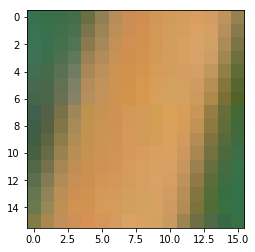

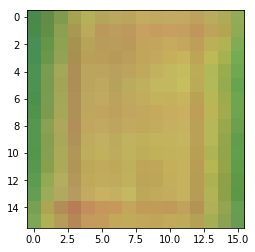

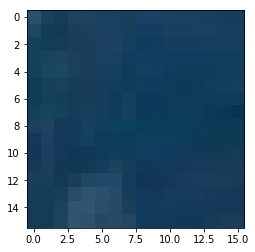

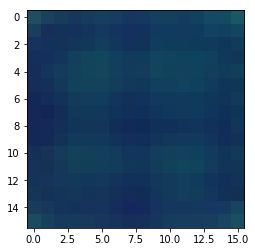

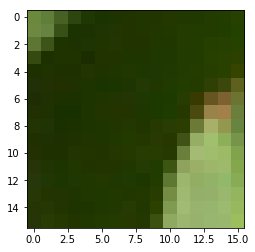

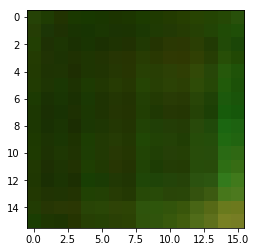

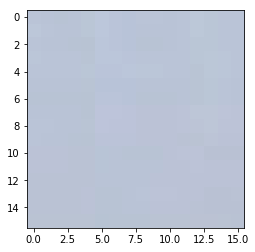

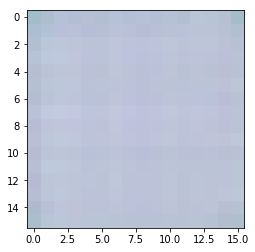

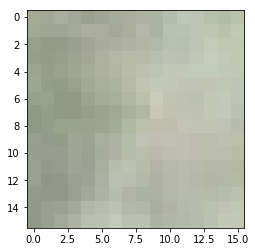

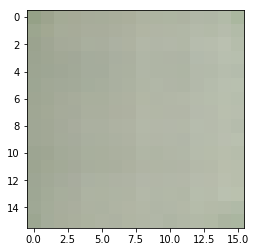

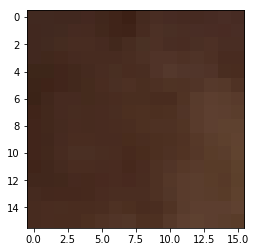

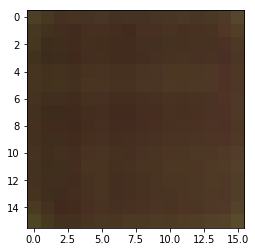

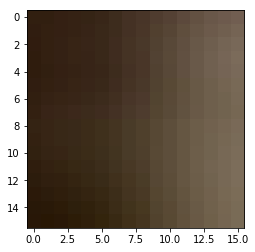

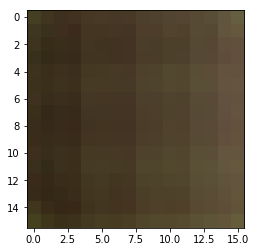

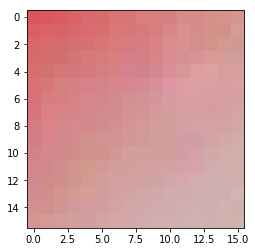

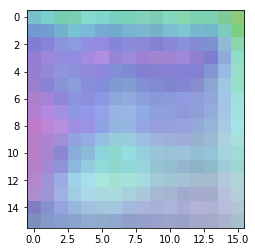

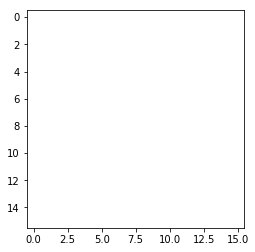

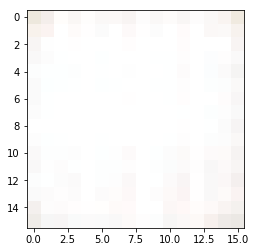

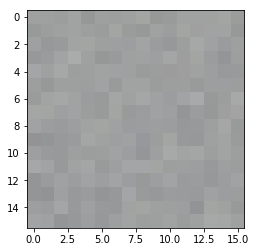

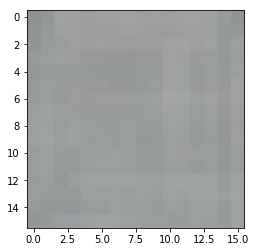

<Figure size 432x288 with 0 Axes>

In [24]:
# Plot original images and masks
count = 0;
for i in range(50,100):
    imgnum = i*100
    test_img = testDataset[0][imgnum]
    lx = np.gradient(test_img, axis=0)
    ly = np.gradient(test_img, axis=1)
    t=np.sum(lx**2+ly**2)/(16*16)
    if t>0.1:
        test_img_show = np.transpose(test_img, axes=[1, 2, 0]) + 0.5
        test_img_show = matplotlib.colors.hsv_to_rgb(test_img_show)
        plt.imshow(test_img_show)
        plt.figure()
        #Predict a new image
        pred_img = predict_img(net, test_img)
        pred_img_show = np.transpose(pred_img, axes=[1, 2, 0]) +0.5
        pred_img_show = matplotlib.colors.hsv_to_rgb(pred_img_show)
        plt.imshow(pred_img_show)
        plt.figure()
        count= count+1
    if count == 10:
        break

tensor([[ 0.4898,  0.4947,  0.4959,  0.4916,  0.4941, -0.4939, -0.4937,  0.4983,
          0.4946, -0.4981, -0.4920, -0.5000, -0.4978, -0.4854, -0.4887, -0.4877],
        [ 0.4932,  0.4944,  0.4957,  0.4910,  0.4908, -0.4968, -0.4950,  0.4983,
          0.4946,  0.4963,  0.4979,  0.4977, -0.4954, -0.4803, -0.4792, -0.4818],
        [-0.5000, -0.4985, -0.4970,  0.4951,  0.4935, -0.4966, -0.4947, -0.5000,
          0.4908,  0.4941,  0.4937,  0.4977, -0.4954, -0.4859, -0.4773, -0.4781],
        [-0.4955, -0.4922, -0.4920, -0.5000,  0.4982, -0.4963, -0.4981,  0.4863,
          0.4847,  0.4938,  0.4912,  0.4952,  0.4975, -0.4922, -0.4892, -0.4879],
        [-0.4984, -0.4950, -0.4965,  0.4963,  0.4908, -0.5000,  0.4941,  0.4799,
          0.4742,  0.4827,  0.4844,  0.4949,  0.4973,  0.4944, -0.4972, -0.4940],
        [ 0.4951,  0.4983, -0.4981,  0.4847,  0.4828,  0.4877,  0.4919,  0.4771,
          0.4722,  0.4745,  0.4722,  0.4866,  0.4944,  0.4887,  0.4944,  0.4970],
        [ 0.4788,  0.4

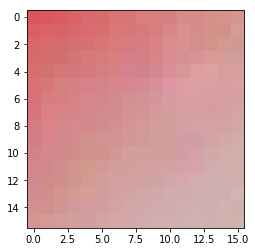

In [301]:
test_img = testDataset[0][5800]
X_img = torch.from_numpy(test_img)
X_img = X_img.type(torch.FloatTensor)
pred_img = predict_img(net, test_img)
test_img_show = np.transpose(test_img, axes=[1, 2, 0]) + 0.5
test_img_show = matplotlib.colors.hsv_to_rgb(test_img_show)
plt.imshow(test_img_show)
diff = X_img[0]
print(diff)

torch.Size([3, 15, 15])
torch.Size([3, 15, 15])
tensor([[[ 0.0000,  0.0000,  0.0000,  0.0118,  0.0000,  0.0000, -0.0078,
          -0.0039,  0.0000,  0.0000,  0.0000, -0.0039,  0.0000,  0.0078,
          -0.0078],
         [ 0.0039,  0.0000,  0.0039,  0.0039,  0.0078,  0.0000,  0.0000,
           0.0000, -0.0078,  0.0000,  0.0000, -0.0039, -0.0039,  0.0078,
          -0.0039],
         [-0.0039,  0.0000,  0.0078,  0.0078,  0.0078,  0.0000,  0.0000,
           0.0000,  0.0039, -0.0078,  0.0000, -0.0039, -0.0039,  0.0118,
          -0.0039],
         [ 0.0039,  0.0000,  0.0000,  0.0000,  0.0000,  0.0078,  0.0000,
           0.0039, -0.0118,  0.0000,  0.0078,  0.0078, -0.0039,  0.0078,
          -0.0039],
         [ 0.0000,  0.0039,  0.0000,  0.0000,  0.0078,  0.0039,  0.0000,
          -0.0039, -0.0039, -0.0039,  0.0078,  0.0039,  0.0000,  0.0078,
          -0.0039],
         [ 0.0039,  0.0000,  0.0039,  0.0000,  0.0039,  0.0000,  0.0039,
           0.0000, -0.0039,  0.0000,  0.0000,  0.

<Figure size 432x288 with 0 Axes>

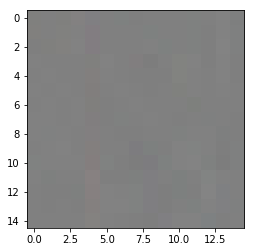

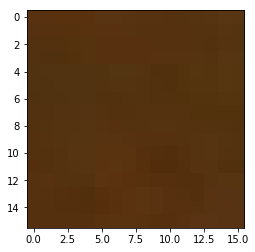

<Figure size 432x288 with 0 Axes>

In [182]:
batch_size = 50
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
for i, b in enumerate(train_loader):
    ################################################ [TODO] ###################################################
    # Get images and masks from each batch
    imgs = b['img']
    label = b['label']
    Gx_in, Gx_target, Gy_in, Gy_target= grad_loss(imgs,imgs)
    print(Gx_in.shape)
    save = imgs[49]
    if i == 1:
        break
print(Gx_in)
test_img_show = np.transpose(Gx_in, axes=[1, 2, 0]) + 128/255
plt.imshow(test_img_show)
plt.figure()       
test_img_show = np.transpose(save, axes=[1, 2, 0]) + 128/255
plt.imshow(test_img_show)
plt.figure()      

In [48]:
###ORIGINAL IMAGE

In [ ]:
val_dice = eval_net(net, val_loader)
print('Validation Dice Coeff: {}'.format(val_dice))

In [223]:
t = tf.constant([[[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]],
                [[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]]])
print(t.shape)
paddings = tf.constant([[0, 0,],[0, 0,],[1, 1,], [2, 2]])
p = tf.pad(t, paddings, "SYMMETRIC")
print(p.shape)
print(tf.contrib.framework.is_tensor(p))

(2, 2, 2, 3)
(2, 2, 4, 7)
True


In [42]:
a,b,c = 0.6, 0.4, 0.3


In [39]:
###Saving Parameters 3 only MSE 4 MSE + GRad loss, 7HSV grad loss only
PATH = './model/modelparamsHSVGrad2_1.pth'
torch.save(net, PATH)

C:\Users\jlmao\Anaconda3\envs\ImageVideoProcessing\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\jlmao\Anaconda3\envs\ImageVideoProcessing\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type single_conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\jlmao\Anaconda3\envs\ImageVideoProcessing\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type resize. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\jlmao\Anaconda3\envs\ImageVideoProcessing\lib\site-packages\torch\serialization.py:251: UserWarning: Couldn't retrieve source code for container of type upT. It won't be ch

In [23]:
# Loading parameters

PATH = './model/HSV_standard_UpT_3filt_100.pth' #Using grad2
#PATH = './model/HSV_filt3_grad1_Epoch100.pth'
net = UNet(3)
net.load_state_dict(torch.load(PATH))
net.eval()

UNet(
  (inc): single_conv(
    (conv): Sequential(
      (0): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): Tanh()
    )
  )
  (down1): resize(
    (up): Upsample(scale_factor=bilinear, mode=nearest)
    (conv): Sequential(
      (0): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(6, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): Tanh()
    )
  )
  (down2): resize(
    (up): Upsample(scale_factor=bilinear, mode=nearest)
    (conv): Sequential(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
      (2): Tanh()
    )
  )
  (down3): resize(
    (up): Upsample(scale_factor=bilinear, mode=nearest)
    (conv): Sequential(
      (0): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Con

In [304]:
a = (1.1 %1)

In [305]:
print(a)

0.10000000000000009
